# Mutual Fund & ETFs Analysis
---

# Part 2 - Exploratory Data Analysis

## Content
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Feature Selection](#Feature-Selection)

## Links to Other Notebooks

- [Part 1: Data Cleaning](Part_1_Cleaning.ipynb)
- [Part 3: Modeling: Mutual Fund v1](Part_3_Modeling_MF_v1.ipynb)
- [Part 4: Modeling: Mutual Fund v2](Part_4_Modeling_MF_v2.ipynb)
- [Part 5: Modeling: ETFs v1](Part_5_Modeling_ETF_v1.ipynb)
- [Part 6: Modeling: ETFs v2](Part_6_Modeling_ETF_v2.ipynb)
- [Part 7: Evaluation & Conclusion](Part_7_Conclusion.ipynb)

### Libraries

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns

%matplotlib inline

import re
import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# set display options
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_colwidth", 500)

### Load datasets

In [2]:
mutual_fund = pd.read_csv('../datasets/mutual_fund_clean.csv')
etf = pd.read_csv('../datasets/etf_clean.csv')

## Exploratory Data Analysis

### Overview 

In [3]:
mutual_fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23567 entries, 0 to 23566
Columns: 284 entries, fund_symbol to peer_governance_max
dtypes: float64(269), object(15)
memory usage: 51.1+ MB


In [4]:
etf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Columns: 113 entries, fund_symbol to fund_treynor_ratio_10years
dtypes: float64(99), int64(1), object(13)
memory usage: 1.1+ MB


Overall, there is significantly more data on mutual funds compared to exchange-traded funds (ETFs). Hence if we were to do a classification model to predict mutual funds vs. ETFs, we would see a huge class imbalance. Furthermore, in the data cleaning process we saw many missing values and relatively newer funds. 

Hence it would be more meaningful to understand the columns in each dataset more closely, and then we can model each dataset separately.

### About fund management

#### `MutualFunds.csv`

First, let's take a look at the mutual fund's management background:

In [5]:
mutual_fund['fund_short_name'].value_counts().head(50)

None                               817
Fidelity Advisor Freedom Blend     145
American Century International      87
Columbia Adaptive Retirement 20     72
American Century Strategic Allo     70
American Century Short Duration     67
Columbia Capital Allocation Mod     60
Sanford C. Bernstein Fund, Inc.     48
American Beacon Bridgeway Large     48
AB Municipal Income Fund, Inc.      48
MFS Blended Research Small Cap      47
American Century Emerging Marke     44
AB Cap Fund, Inc. - AB Select U     43
Fidelity Advisor International      42
Fidelity Advisor Asset Manager      42
American Century One Choice 205     40
American Funds Moderate Growth      40
MainStay Epoch U.S. Equity Yiel     40
American Funds Corporate Bond F     40
Columbia Small Cap Value Fund I     39
American Funds Strategic Bond F     39
American Century One Choice 204     38
American Funds Emerging Markets     37
MFS Blended Research Mid Cap Eq     36
MFS Emerging Markets Debt Local     36
MFS Blended Research Grow

In [6]:
mutual_fund['fund_long_name'].value_counts().head(30)

None                                                                       5
Parametric Commodity Strategy Fund Investor Class                          4
North Square Advisory Research All Cap Value Fund I                        4
American Century Emerging Markets Fund R5 Class                            4
UBS Global Allocation Fund Class P                                         4
Eaton Vance Income Fund of Boston Class C                                  4
Aberdeen International Small Cap Fund Class C                              4
American Funds Moderate Growth and Income Portfolio Class C                4
American Century Emerging Markets Fund C Class                             4
BNY Mellon Sustainable Balanced Fund Class Service Class                   4
Columbia High Yield Bond Fund Advisor Class                                4
Wells Fargo Global Small Cap Fund Class Admin                              4
Virtus AllianzGI Short Duration High Income Fund Class A                   4

Based on the `fund_short_name`, it's quite interesting to see that there are a few key players in the industry. The average seems number of funds is around 20-40, but we'll take a closer look at the top three:  **Fidelity Advisor Freedom Blend, American Century International and
Columbia Adaptive Retirement 20**

Meanwhile in the `fund_long_name`, we can see more details on the type of funds and portfolio. Most of them only have about four.

Next, let's look at the `fund_family`:

In [7]:
mutual_fund['fund_family'].value_counts().head(10)

American Century Investments    1819
Fidelity Investments            1775
Columbia Threadneedle           1657
American Funds                  1562
BlackRock                       1118
Eaton Vance                     1069
AllianceBernstein                898
BNY Mellon                       774
Invesco                          645
Delaware Funds by Macquarie      593
Name: fund_family, dtype: int64

Reaffirming the earlier findings, we'll be taking a closer look at: **American Century Investments, Fidelity Investments and Columbia Threadneedle**

Meanwhile, let's look at the top fund manager by volume:

In [8]:
mutual_fund['management_name'].value_counts().head(10)

Andrew F. Dierdorf    562
Wesley K.-S. Phoa     319
Jonathan W. Sage      262
Scott A. Wilson       256
Jed S. Fogdall        245
Michelle J. Black     230
Radu Gabudean         181
John Calamos          158
Jeffrey Houston       152
Adam A. Weigold       132
Name: management_name, dtype: int64

In [9]:
# view Andrew's bio

mutual_fund[(mutual_fund['management_name'] == 'Andrew F. Dierdorf')][['management_name', 'management_bio']]

management_name  \
10283  Andrew F. Dierdorf   
10301  Andrew F. Dierdorf   
10304  Andrew F. Dierdorf   
10305  Andrew F. Dierdorf   
10371  Andrew F. Dierdorf   
...                   ...   
23487  Andrew F. Dierdorf   
23502  Andrew F. Dierdorf   
23546  Andrew F. Dierdorf   
23548  Andrew F. Dierdorf   
23553  Andrew F. Dierdorf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            management_bio  
10283  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other than Fidelity Freedom© Index 2055 Fund, Fidelity Freedom© Index 2060 Fund, and Fidelity Freedom© Index 2065 Fund). He has managed Fidelity Freedom© Index 2055 Fund since June 2011, Fidelity Freedom© Index 2060 Fund since August 2014, and Fidelity Freedom© Index 2065 Fund since June 2019. He also manages other funds. Since joining Fidelity Investments in 2004, Mr. Dierdorf has worked as a portfolio mana...  
10301  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other than Fidelity Freedom© Index 2055 Fund, Fidelity Freedom© Index 2060 Fund, and Fidelity Freedom© Index 2065 Fund). He has managed Fidelity Freedom© Index 2055 Fund since June 2011, Fidelity Freedom© Index 2060 Fund since August 2014, and Fidelity Freedom© Index 2065 Fund since June 2019. He also manages other funds. Since joining Fidelity Investments in 2004, Mr. Dierdorf has worked as a portfolio mana...  
10304  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other than Fidelity Freedom© Index 2055 Fund, Fidelity Freedom© Index 2060 Fund, and Fidelity Freedom© Index 2065 Fund). He has managed Fidelity Freedom© Index 2055 Fund since June 2011, Fidelity Freedom© Index 2060 Fund since August 2014, and Fidelity Freedom© Index 2065 Fund since June 2019. He also manages other funds. Since joining Fidelity Investments in 2004, Mr. Dierdorf has worked as a portfolio mana...  
10305  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other than Fidelity Freedom© Index 2055 Fund, Fidelity Freedom© Index 2060 Fund, and Fidelity Freedom© Index 2065 Fund). He has managed Fidelity Freedom© Index 2055 Fund since June 2011, Fidelity Freedom© Index 2060 Fund since August 2014, and Fidelity Freedom© Index 2065 Fund since June 2019. He also manages other funds. Since joining Fidelity Investments in 2004, Mr. Dierdorf has worked as a portfolio mana...  
10371  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other than Fidelity Freedom© Index 2055 Fund, Fidelity Freedom© Index 2060 Fund, and Fidelity Freedom© Index 2065 Fund). He has managed Fidelity Freedom© Index 2055 Fund since June 2011, Fidelity Freedom© Index 2060 Fund since August 2014, and Fidelity Freedom© Index 2065 Fund since June 2019. He also manages other funds. Since joining Fidelity Investments in 2004, Mr. Dierdorf has worked as a portfolio mana...  
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ...  
23487  Andrew Dierdorf is co-manager of each fund, which he has managed since October 2009 (other 

As we've found earlier, [Andrew Dierdorf](https://www.planadviser.com/thought-leadership/fid-fidelity-research-reveals-target-date-strategies-can-help-address-plan-sponsors-top-concerns/) from Fidelity Investments is managing a significant portion of the mutual funds. 

Now let's look at the invesment strategy:

In [10]:
mutual_fund['investment_strategy'].head()

0              The investment seeks total return in excess of inflation through capital growth and current income. The fund will invest at least 80% of its net assets, plus the amount of any borrowings for investment purposes, in a combination of investments that the Advisor believes offer exposure to "real assets." It generally invests between 25% and 75% of fund assets in securities of foreign issuers, including up to 10% of fund assets in issuers located in countries with new or emerging markets.
1    The investment seeks long-term capital appreciation. The fund seeks to achieve its objective by normally investing at least 80% of its net assets (plus borrowings made for investment purposes) in health sciences-related companies. The portfolio manager considers health sciences-related companies to include companies that design, manufacture or sell products or services used for or in connection with healthcare, medicine or life sciences. The fund will invest primarily in common stocks 

We won't be able to learn more about the fund management from the investment strategy, however we can do a deeper dive on commonly used terms later on.

Let's take a closer look at the top three mutual fund management: **Fidelity Investments, American Century Investments and Columbia Threadneedle**

##### Fidelity Invesments

In [11]:
mutual_fund[mutual_fund['fund_short_name'] == "Fidelity Advisor Freedom Blend "].describe(include='all')

fund_symbol                  fund_short_name  \
count          145                              145   
unique         145                                1   
top          JMUAX  Fidelity Advisor Freedom Blend    
freq             1                              145   
mean           NaN                              NaN   
std            NaN                              NaN   
min            NaN                              NaN   
25%            NaN                              NaN   
50%            NaN                              NaN   
75%            NaN                              NaN   
max            NaN                              NaN   

                                          fund_long_name  initial_investment  \
count                                                145        1.450000e+02   
unique                                                81                 NaN   
top     Fidelity Advisor Freedom Blend 2065 Fund Class A                 NaN   
freq                                                   3                 NaN   
mean                                                 NaN        1.013347e+06   
std                                                  NaN        3.220271e+06   
min                                                  NaN        0.000000e+00   
25%                                                  NaN        0.000000e+00   
50%                                                  NaN        1.000000e+03   
75%                                                  NaN        1.000000e+06   
max                                                  NaN        1.500000e+07   

        subsequent_investment fund_category           fund_family  \
count              145.000000           145                   145   
unique                    NaN            46                     1   
top                       NaN  Large Growth  Fidelity Investments   
freq                      NaN            14                   145   
mean              1414.482759           NaN                   NaN   
std              11699.760974           NaN                   NaN   
min                  0.000000           NaN                   NaN   
25%                  0.000000           NaN                   NaN   
50%                  0.000000           NaN                   NaN   
75%                 50.000000           NaN                   NaN   
max             100000.000000           NaN                   NaN   

           management_name  \
count                  145   
unique                   1   
top     Andrew F. Dierdorf   
freq                   145   
mean                   NaN   
std                    NaN   
min                    NaN   
25%                    NaN   
50%                    NaN   
75%                    NaN   
max                    NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             management_bio  \
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   145   
unique                                                                                                                                                                       

Overview of `Fidelity Advisor Freedom Blend`:
- The top 3 fund is [`Fidelity Advisor Freedom Blend 2065 Fund Class A`](https://institutional.fidelity.com/app/funds-and-products/3419/fidelity-advisor-freedom-blend-2065-fund-class-a-fazax.html)
- Most of the mutual fund are considered `Large Growth`, which means that the fund mostly invest in larger companies that are expected to grow fast - this is usually applicable for technology companies
- Two-thirds (60%) of the investments are considered `Large` while more than half (54%) have a Blend portfolio
- All 145 of the mutual funds are managed by Andrew Dierdoft from Fidelity Invesments
- Nearly 20% (27 out of 145) of the funds management started in December 2019
- The average total net assets is USD321,258,700,000
- The average Morningstar overall rating is 2.7 out of 5, while the average risk rating is 2.9 out of 5 and return rating is 2.7 out of 5 - these are all average ratings, which may have been lower after we imputed the missing values
- The average `fund_annual_report_net_expense_ratio` is 1.0%, representing the average operating fees that are charged to investors
- The highest average asset breakdown is stocks (51.7%), followed by bonds (27.2%) and cash (5.9%)
- The top three average sector breakdown is technology (12.9%), financial services (11.6%) and healthcare (7.7%)
- In terms of bond ratings, most of the mutual funds have an AAA rating (14.2%), followed by BBB rating (9.6%) and A rating (7.1%)
- The average fund return in the last financial year is 8.1%
- The average sustainability score is 13.4 - which is considered low. The ideal score should be above 50 ([source](https://www.investopedia.com/terms/m/morningstar-sustainability-rating.asp)) 

What about their performance:

In [12]:
# get column index for performance metrics

mutual_fund.columns.get_loc('fund_alpha_3years')

233

In [13]:
# get column index for performance metrics

mutual_fund.columns.get_loc('fund_treynor_ratio_3years')

239

In [14]:
# view summary statistics of performance metrics - 3 years

mutual_fund.iloc[:,233:240][mutual_fund['fund_short_name'] == "Fidelity Advisor Freedom Blend "].describe(include='all')

fund_alpha_3years  fund_beta_3years  fund_mean_annual_return_3years  \
count         145.000000        145.000000                      145.000000   
mean           -1.388828          0.964345                        0.843448   
std             3.707729          0.467946                        0.597817   
min           -13.400000         -0.810000                       -1.400000   
25%            -2.450000          0.760000                        0.450000   
50%            -0.930000          1.030000                        0.780000   
75%             0.450000          1.260000                        1.170000   
max             8.580000          2.660000                        2.320000   

       fund_r_squared_3years  fund_stdev_3years  fund_sharpe_ratio_3years  \
count             145.000000         145.000000                145.000000   
mean               76.491103          13.254621                  0.667931   
std                31.585316           7.305353                  0.373943   
min                 0.000000           0.000000                 -1.150000   
25%                75.170000           7.820000                  0.520000   
50%                90.610000          14.420000                  0.730000   
75%                97.620000          18.650000                  0.860000   
max                99.260000          31.170000                  1.270000   

       fund_treynor_ratio_3years  
count                 145.000000  
mean                    8.912138  
std                     6.153541  
min                    -3.050000  
25%                     4.830000  
50%                     8.060000  
75%                     9.480000  
max                    33.520000

In [15]:
# view summary statistics of performance metrics - 5 years

mutual_fund.iloc[:,240:247][mutual_fund['fund_short_name'] == "Fidelity Advisor Freedom Blend "].describe(include='all')

fund_alpha_5years  fund_beta_5years  fund_mean_annual_return_5years  \
count         145.000000        145.000000                      145.000000   
mean           -0.423793          0.859172                        0.761862   
std             2.801500          0.506530                        0.588572   
min            -9.580000         -0.820000                       -1.200000   
25%            -1.260000          0.640000                        0.300000   
50%            -0.340000          0.970000                        0.690000   
75%             0.790000          1.200000                        1.120000   
max             6.520000          2.480000                        1.960000   

       fund_r_squared_5years  fund_stdev_5years  fund_sharpe_ratio_5years  \
count             145.000000         145.000000                145.000000   
mean               70.196345          10.211241                  0.674966   
std                36.147460           6.379350                  0.412274   
min                 0.000000           0.000000                 -1.220000   
25%                71.800000           4.940000                  0.510000   
50%                86.800000           9.780000                  0.750000   
75%                95.520000          15.330000                  0.910000   
max                99.170000          25.190000                  1.430000   

       fund_treynor_ratio_5years  
count                 145.000000  
mean                    8.960138  
std                     6.590279  
min                    -3.290000  
25%                     4.220000  
50%                     8.190000  
75%                    11.370000  
max                    31.350000

In [16]:
# view summary statistics of performance metrics - 10 years

mutual_fund.iloc[:,247:254][mutual_fund['fund_short_name'] == "Fidelity Advisor Freedom Blend "].describe(include='all')

fund_alpha_10years  fund_beta_10years  fund_mean_annual_return_10years  \
count          145.000000         145.000000                       145.000000   
mean            -0.534690           0.622414                         0.454690   
std              2.261792           0.588526                         0.512606   
min            -13.810000          -0.820000                        -1.070000   
25%             -0.850000           0.000000                         0.000000   
50%              0.000000           0.890000                         0.330000   
75%              0.000000           1.080000                         0.830000   
max              8.170000           2.520000                         1.760000   

       fund_r_squared_10years  fund_stdev_10years  fund_sharpe_ratio_10years  \
count               145.00000          145.000000                 145.000000   
mean                 51.29200            6.853862                   0.493931   
std                  43.26997            6.731521                   0.460972   
min                   0.00000            0.000000                  -1.160000   
25%                   0.00000            0.000000                   0.000000   
50%                  76.87000            4.860000                   0.650000   
75%                  91.90000           14.260000                   0.820000   
max                  98.44000           22.140000                   1.380000   

       fund_treynor_ratio_10years  
count                  145.000000  
mean                     6.499517  
std                     10.928174  
min                    -15.030000  
25%                      0.000000  
50%                      5.270000  
75%                      8.520000  
max                     86.330000

When we look at `Fidelity Advisor Freedom Blend`'s aggregated performance over the years:
- Alpha values represent how well the stocks have performed against its benchmark index, and in principle positive and higher value are better indicators. Based on the tables above, all alpha values indicate that the funds have performed below its benchmark - especially the recent three-year
- Beta values represent volatility of the fund, which usually hovers around 1 but it is not as clear cut compared to alpha values. Lower beta would be favored by risk-averse investors while higher beta is more favored by risk-tolerant investors. For the funds under this group, most of them appear to be on the 'safer' side, though the recent three years show that there are more risky portfolio
- As for the mean annual return, we can see that the average percentage decrease over the years, similarly to the R-squared
- When we look at the standard deviation, we can see that the three-year results have more variation, which could be explained by the more-risky portfolio
- Sharpe ratio refers to an investment's return compared to its risk, the higher the better. The ratio is about the same for three- and five-year, but is much lower for 10-year - suggesting that shorter-term investments with this mutual fund portfolio may be better for investors
- Treynor ratio refers to the excess return generated for each unit of risk in portfolio, higher value is better because investors would receive higher return relative to the risk taken. The three- and five-year figures are much higher, but is much lower for 10-year, also suggesting that it's better to take more risks in the shorter run than long run.

##### American Century International

In [17]:
mutual_fund[mutual_fund['fund_short_name'] == "American Century International "].describe(include='all')

fund_symbol                  fund_short_name  \
count           87                               87   
unique          87                                1   
top          ATYGX  American Century International    
freq             1                               87   
mean           NaN                              NaN   
std            NaN                              NaN   
min            NaN                              NaN   
25%            NaN                              NaN   
50%            NaN                              NaN   
75%            NaN                              NaN   
max            NaN                              NaN   

                                            fund_long_name  \
count                                                   87   
unique                                                  22   
top     American Century International Growth Fund C Class   
freq                                                     4   
mean                                                   NaN   
std                                                    NaN   
min                                                    NaN   
25%                                                    NaN   
50%                                                    NaN   
75%                                                    NaN   
max                                                    NaN   

        initial_investment  subsequent_investment fund_category  \
count         8.700000e+01              87.000000            87   
unique                 NaN                    NaN            36   
top                    NaN                    NaN    World Bond   
freq                   NaN                    NaN            11   
mean          2.321164e+07              35.344828           NaN   
std           2.144003e+08              76.965687           NaN   
min           0.000000e+00               0.000000           NaN   
25%           0.000000e+00               0.000000           NaN   
50%           1.000000e+03               0.000000           NaN   
75%           2.500000e+03              50.000000           NaN   
max           2.000000e+09             500.000000           NaN   

                         fund_family management_name  \
count                             87              87   
unique                             1               4   
top     American Century Investments   Simon Chester   
freq                              87              32   
mean                             NaN             NaN   
std                              NaN             NaN   
min                              NaN             NaN   
25%                              NaN             NaN   
50%                              NaN             NaN   
75%                              NaN             NaN   
max                              NaN             NaN   

                                                                                                                                                                                                                                                                                                                                          management_bio  \
count                                                                                                                                                                                                                                                                                                                                                 87   
unique                                                                                                                                                                                                                                                                                                                                                 4   
top     Simon Chester, Vice President and Portfolio Manager, has served on team

Overview of `American Century Investments`:
- The top 4 fund is [`American Century International Value Fund R6 Class`](https://www.americancentury.com/invest/funds/international-value/?shareClass=investorClass) that invests in larger companies
- Most of the mutual fund are considered [`World Bond`](https://www.investopedia.com/terms/w/world_fund.asp), which means that a type of mutual fund or other investment company that invests in securities that are traded in several different countries
- All 87 funds are managed by American Century Investments, and about 37% of the funds are managed by Simon Chester
- 56% (49 out of 87) of the investments are considered `Large` while 40% (35 out of 87) have a Blend portfolio
- The average total net assets is USD11,012,630,000
- The average Morningstar overall rating is 2.8 out of 5, while the average risk rating is 2.9 out of 5 and return rating is 2.8 out of 5 - these are all average ratings, which may have been lower after we imputed the missing values
- The average `fund_annual_report_net_expense_ratio` is 1.1%, representing the average operating fees that are charged to investors
- The highest average asset breakdown is stocks (55.6%), followed by bonds (22.9%) and cash (3.7%)
- The top three average sector breakdown is technology (11.6%), financial services (11.5%) and industrials (10.3%)
- In terms of bond ratings, most of the mutual funds have an AAA rating (19.8%), followed by BBB rating (10.3%) and AA rating (7.5%)
- The average fund return in the last financial year is 6.8%
- The average sustainability score is 14.7 - which is considered low. The ideal score should be above 50 ([source](https://www.investopedia.com/terms/m/morningstar-sustainability-rating.asp)) 

In [18]:
# view summary statistics of performance metrics - 3 years

mutual_fund.iloc[:,233:240][mutual_fund['fund_short_name'] == "American Century International "].describe(include='all')

fund_alpha_3years  fund_beta_3years  fund_mean_annual_return_3years  \
count          87.000000         87.000000                       87.000000   
mean           -1.357011          0.989885                        0.762299   
std             4.331156          0.336295                        0.440007   
min           -16.840000          0.000000                        0.000000   
25%            -2.690000          0.935000                        0.420000   
50%            -0.490000          1.040000                        0.740000   
75%             0.715000          1.160000                        1.085000   
max            10.650000          1.530000                        2.300000   

       fund_r_squared_3years  fund_stdev_3years  fund_sharpe_ratio_3years  \
count              87.000000          87.000000                 87.000000   
mean               74.827241          12.935172                  0.632529   
std                30.131914           7.968252                  0.329334   
min                 0.000000           0.000000                  0.000000   
25%                55.850000           6.730000                  0.440000   
50%                89.820000          12.030000                  0.670000   
75%                96.450000          18.880000                  0.815000   
max               100.000000          32.570000                  1.860000   

       fund_treynor_ratio_3years  
count                  87.000000  
mean                    7.187816  
std                     4.824186  
min                     0.000000  
25%                     3.415000  
50%                     7.510000  
75%                    10.720000  
max                    24.310000

In [19]:
# view summary statistics of performance metrics - 5 years

mutual_fund.iloc[:,240:247][mutual_fund['fund_short_name'] == "American Century International "].describe(include='all')

fund_alpha_5years  fund_beta_5years  fund_mean_annual_return_5years  \
count          87.000000         87.000000                       87.000000   
mean           -0.882644          0.977126                        0.701839   
std             3.365080          0.346735                        0.481993   
min           -11.500000          0.000000                        0.000000   
25%            -2.500000          0.935000                        0.205000   
50%            -0.360000          1.020000                        0.740000   
75%             0.815000          1.225000                        1.135000   
max            10.570000          1.470000                        2.240000   

       fund_r_squared_5years  fund_stdev_5years  fund_sharpe_ratio_5years  \
count              87.000000          87.000000                 87.000000   
mean               72.651609          10.665977                  0.602989   
std                30.476952           6.421820                  0.355920   
min                 0.000000           0.000000                 -0.100000   
25%                52.395000           6.300000                  0.375000   
50%                88.480000           9.610000                  0.670000   
75%                95.505000          15.450000                  0.885000   
max               100.000000          26.200000                  1.430000   

       fund_treynor_ratio_5years  
count                  87.000000  
mean                    6.709540  
std                     5.282316  
min                    -3.780000  
25%                     1.720000  
50%                     7.080000  
75%                    10.395000  
max                    24.540000

In [20]:
# view summary statistics of performance metrics - 10 years

mutual_fund.iloc[:,247:254][mutual_fund['fund_short_name'] == "American Century International "].describe(include='all')

fund_alpha_10years  fund_beta_10years  fund_mean_annual_return_10years  \
count           87.000000          87.000000                        87.000000   
mean            -0.697126           0.805862                         0.437931   
std              2.742343           0.462293                         0.387149   
min             -9.980000           0.000000                        -0.030000   
25%             -2.060000           0.735000                         0.020000   
50%             -0.130000           1.000000                         0.410000   
75%              0.120000           1.110000                         0.740000   
max              6.400000           1.410000                         1.490000   

       fund_r_squared_10years  fund_stdev_10years  fund_sharpe_ratio_10years  \
count               87.000000            87.00000                  87.000000   
mean                59.913218             8.48069                   0.452529   
std                 39.197944             6.79127                   0.380591   
min                  0.000000             0.00000                  -0.150000   
25%                 25.365000             3.17000                   0.000000   
50%                 79.610000             6.61000                   0.550000   
75%                 93.270000            14.95500                   0.755000   
max                 99.990000            22.12000                   1.120000   

       fund_treynor_ratio_10years  
count                   87.000000  
mean                     4.285287  
std                      4.186003  
min                     -1.060000  
25%                      0.000000  
50%                      3.340000  
75%                      7.650000  
max                     15.500000

When we look at `American Century International`'s aggregated performance over the years:
- Based on the tables above, all alpha values indicate that the funds have performed below its benchmark - especially the recent three-year
- The beta values indicate that the portfolio risk have been relatively similar over the years, much closer in three- and five-year
- As for the mean annual return, we can see that the average percentage decrease over the years, similarly to the R-squared. Seeing that the portfolio risks are higher on the shorter run, it would make more sense for the return to be higher as well
- When we look at the standard deviation, we can see that the three-year results have the most variation, which could be explained by the more-risky portfolio
- Both the Sharpe and Treynor ratios are much higher in the shorter-term, indicating that the shorter-term investments may work better for investors

##### Columbia Adaptive Retirement 20

In [21]:
mutual_fund[mutual_fund['fund_short_name'] == "Columbia Adaptive Retirement 20"].describe(include='all')

fund_symbol                  fund_short_name  \
count           72                               72   
unique          72                                1   
top          MPLRX  Columbia Adaptive Retirement 20   
freq             1                               72   
mean           NaN                              NaN   
std            NaN                              NaN   
min            NaN                              NaN   
25%            NaN                              NaN   
50%            NaN                              NaN   
75%            NaN                              NaN   
max            NaN                              NaN   

                                                      fund_long_name  \
count                                                             72   
unique                                                            18   
top     Columbia Adaptive Retirement 2050 Fund Institutional 3 Class   
freq                                                               4   
mean                                                             NaN   
std                                                              NaN   
min                                                              NaN   
25%                                                              NaN   
50%                                                              NaN   
75%                                                              NaN   
max                                                              NaN   

        initial_investment  subsequent_investment fund_category  \
count         7.200000e+01              72.000000            72   
unique                 NaN                    NaN            32   
top                    NaN                    NaN  Large Growth   
freq                   NaN                    NaN             6   
mean          7.489132e+05             127.777778           NaN   
std           1.787666e+06             312.406481           NaN   
min           0.000000e+00               0.000000           NaN   
25%           1.875000e+02               0.000000           NaN   
50%           2.000000e+03               0.000000           NaN   
75%           1.000000e+06              50.000000           NaN   
max           1.000000e+07            1000.000000           NaN   

                  fund_family  management_name  \
count                      72               72   
unique                      1                1   
top     Columbia Threadneedle  Joshua B. Kutin   
freq                       72               72   
mean                      NaN              NaN   
std                       NaN              NaN   
min                       NaN              NaN   
25%                       NaN              NaN   
50%                       NaN              NaN   
75%                       NaN              NaN   
max                       NaN              NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             management_bio  \
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    72   
unique                                               

Overview of `Columbia Adaptive Retirement 20`:
- The top 4 fund is [`Columbia Adaptive Retirement 2045 Fund Advisor Class`](https://www.columbiathreadneedleus.com/investment-products/mutual-funds/Columbia-Adaptive-Retirement-2040-Fund/Class-Advisor/details/?cusip=19767X506), which focuses on allocating portfolio with a target retirement in 2045
- Most of the mutual fund invests in companies in the infrastructure sector
- All 72 funds are managed by Joshua Kutin from Columbia Threadneedle
- 49% (35 out of 72) of the investments are considered `Large` while 74% (53 out of 72) have a Blend portfolio
- The average total net assets is USD1,023,767,000
- The average Morningstar overall rating is 2.8 out of 5, while the average risk rating is 2.1 out of 5 and return rating is 2.8 out of 5 - these are all average ratings, which may have been lower after we imputed the missing values
- The average `fund_annual_report_net_expense_ratio` is 0.9%, representing the average operating fees that are charged to investors
- The highest average asset breakdown is stocks (36%), followed by bonds (29%) and cash (6%)
- The top three average sector breakdown is technology (11%), financial services (8%) and utilities (8%)
- In terms of bond ratings, most of the mutual funds have an AA rating (7.6%), followed by AAA rating (7.5%) and A rating (6.7%)
- The average fund return in the last financial year is 8.0%
- The average sustainability score is 11.5 - which is considered low. The ideal score should be above 50 ([source](https://www.investopedia.com/terms/m/morningstar-sustainability-rating.asp)) 

In [22]:
# view summary statistics of performance metrics - 3 years

mutual_fund.iloc[:,233:240][mutual_fund['fund_short_name'] == "Columbia Adaptive Retirement 20"].describe(include='all')

fund_alpha_3years  fund_beta_3years  fund_mean_annual_return_3years  \
count          72.000000         72.000000                       72.000000   
mean           -0.225278          0.814583                        0.727361   
std             3.998955          0.437657                        0.575216   
min           -14.910000          0.000000                       -0.100000   
25%            -0.742500          0.585000                        0.367500   
50%             0.000000          0.975000                        0.700000   
75%             2.417500          1.065000                        1.120000   
max             5.600000          1.590000                        2.060000   

       fund_r_squared_3years  fund_stdev_3years  fund_sharpe_ratio_3years  \
count              72.000000          72.000000                 72.000000   
mean               69.465694          10.486667                  0.686944   
std                33.270218           8.308053                  0.430043   
min                 0.000000           0.000000                 -0.190000   
25%                70.952500           4.125000                  0.450000   
50%                76.305000           9.220000                  0.785000   
75%                92.782500          17.595000                  1.080000   
max                99.610000          28.220000                  1.210000   

       fund_treynor_ratio_3years  
count                  72.000000  
mean                    8.207778  
std                     7.207162  
min                    -3.880000  
25%                     2.755000  
50%                     7.800000  
75%                    14.450000  
max                    24.010000

In [23]:
# view summary statistics of performance metrics - 5 years

mutual_fund.iloc[:,240:247][mutual_fund['fund_short_name'] == "Columbia Adaptive Retirement 20"].describe(include='all')

fund_alpha_5years  fund_beta_5years  fund_mean_annual_return_5years  \
count          72.000000         72.000000                       72.000000   
mean           -0.460694          0.603056                        0.440139   
std             2.374245          0.538934                        0.579705   
min           -10.720000          0.000000                        0.000000   
25%            -0.492500          0.000000                        0.000000   
50%             0.000000          0.945000                        0.235000   
75%             0.000000          1.032500                        0.767500   
max             4.840000          1.550000                        1.870000   

       fund_r_squared_5years  fund_stdev_5years  fund_sharpe_ratio_5years  \
count              72.000000          72.000000                 72.000000   
mean               49.531528           6.632639                  0.378056   
std                43.469192           7.704791                  0.416267   
min                 0.000000           0.000000                  0.000000   
25%                 0.000000           0.000000                  0.000000   
50%                72.680000           3.860000                  0.265000   
75%                91.542500          14.685000                  0.662500   
max                99.690000          23.010000                  1.340000   

       fund_treynor_ratio_5years  
count                  72.000000  
mean                    4.324306  
std                     6.439956  
min                    -0.950000  
25%                     0.000000  
50%                     0.810000  
75%                     7.837500  
max                    22.080000

In [24]:
# view summary statistics of performance metrics - 10 years

mutual_fund.iloc[:,247:254][mutual_fund['fund_short_name'] == "Columbia Adaptive Retirement 20"].describe(include='all')

fund_alpha_10years  fund_beta_10years  fund_mean_annual_return_10years  \
count           72.000000          72.000000                        72.000000   
mean            -0.465000           0.564583                         0.318889   
std              1.707236           0.528354                         0.460873   
min             -7.420000           0.000000                        -0.470000   
25%             -0.592500           0.000000                         0.000000   
50%              0.000000           0.790000                         0.135000   
75%              0.000000           1.060000                         0.507500   
max              3.160000           1.270000                         1.460000   

       fund_r_squared_10years  fund_stdev_10years  fund_sharpe_ratio_10years  \
count               72.000000            72.00000                  72.000000   
mean                46.241389             5.81375                   0.387500   
std                 43.271178             7.12401                   0.433072   
min                  0.000000             0.00000                  -0.300000   
25%                  0.000000             0.00000                   0.000000   
50%                 56.260000             3.05000                   0.305000   
75%                 90.552500            13.64500                   0.805000   
max                 99.700000            20.94000                   1.160000   

       fund_treynor_ratio_10years  
count                   72.000000  
mean                     3.293611  
std                      5.090581  
min                     -6.440000  
25%                      0.000000  
50%                      1.615000  
75%                      6.332500  
max                     16.050000

When we look at `Columbia Adaptive Retirement 20`'s aggregated performance over the years:
- Based on the tables above, all alpha values indicate that the funds have performed below its benchmark - the values are much more stable in the five- and ten-year mark
- The beta values are much higher in the shorter term, as expected
- As for the mean annual return, we can see that the average percentage decrease over the years, similarly to the R-squared, also as expected
- When we look at the standard deviation, we can see that the three-year results have the most variation, which could be explained by the more-risky portfolio
- Similar to the beta values, both the Sharpe and Treynor ratios are much higher in the shorter-term and stablized in the longer term

#### `ETFs.csv`

Now we'll look at the ETF dataset management information:

In [25]:
etf['fund_short_name'].value_counts().head(20)

None                               64
American Century Strategic Allo    16
American Century Short Duration    11
AB Cap Fund, Inc. - AB Select U     9
Sanford C. Bernstein Fund, Inc.     9
American Century International      9
AB Bond Fund, Inc. - AB Bond In     8
American Century One Choice 203     7
AB Bond Fund, Inc. - AB Total R     7
American Century Small Cap Valu     7
Lord Abbett Multi-Asset Balance     7
DWS RREEF Real Assets Fund - Cl     7
AB Municipal Income Fund, Inc.      7
American Century One Choice 205     6
Invesco Balanced-Risk Allocatio     6
The AB Portfolios - AB Conserva     6
American Century Equity Income      6
AllianzGI Global Dynamic Alloca     5
American Century Mid Cap Value      5
AB Bond Fund, Inc. - AB All Mar     5
Name: fund_short_name, dtype: int64

In [26]:
etf['fund_long_name'].value_counts().head(30)

Artisan Select Equity Fund Institutional Shares                      1
AB Select US Equity Portfolio Class I                                1
BlackRock 20/80 Target Allocation Fund Investor A Shares             1
American Century Strategic Allocation: Conservative Fund R5 Class    1
AB Discovery Value Fund Class R                                      1
American Funds Fundamental Investors Class A                         1
Aberdeen International Small Cap Fund Institutional Class            1
American Beacon The London Company Income Equity Fund Class R6       1
Bridge Builder Small/Mid Cap Value Fund                              1
BlackRock Retirement Income 2030 Fund Investor A                     1
American Beacon Small Cap Value Fund Class Y                         1
Virtus NFJ Small-Cap Value Fund Class R6                             1
American Beacon Balanced Fund Investor Class                         1
Columbia Acorn USA Fund Institutional Class                          1
AQR La

Unfortunately many of the fund shortened name is missing. Let's take a look at the `fund_family` column:

In [27]:
etf['fund_family'].value_counts().head(10)

American Century Investments    267
BlackRock                       134
AllianceBernstein               129
Invesco                          70
Virtus                           50
American Funds                   49
American Beacon                  37
Alger                            35
Artisan                          29
Baillie Gifford Funds            26
Name: fund_family, dtype: int64

Interestingly, topping the list in ETF is **American Century Investments** again. We'll have a look at their ETFs, along with **BlackRock and Alliance Bernstein.**

##### American Century Investments

In [28]:
etf[etf['fund_family'] == "American Century Investments"].describe(include='all')

fund_symbol fund_short_name  \
count          267             267   
unique         267             113   
top            CSF            None   
freq             1              37   
mean           NaN             NaN   
std            NaN             NaN   
min            NaN             NaN   
25%            NaN             NaN   
50%            NaN             NaN   
75%            NaN             NaN   
max            NaN             NaN   

                                              fund_long_name fund_category  \
count                                                    267           267   
unique                                                   267            56   
top     American Century Focused Global Growth Fund R5 Class          None   
freq                                                       1            72   
mean                                                     NaN           NaN   
std                                                      NaN           NaN   
min                                                      NaN           NaN   
25%                                                      NaN           NaN   
50%                                                      NaN           NaN   
75%                                                      NaN           NaN   
max                                                      NaN           NaN   

                         fund_family exchange_code exchange_name  \
count                            267           267           267   
unique                             1             3             3   
top     American Century Investments           PCX      NYSEArca   
freq                             267           165           165   
mean                             NaN           NaN           NaN   
std                              NaN           NaN           NaN   
min                              NaN           NaN           NaN   
25%                              NaN           NaN           NaN   
50%                              NaN           NaN           NaN   
75%                              NaN           NaN           NaN   
max                              NaN           NaN           NaN   

        avg_vol_3month  avg_vol_10day  total_net_assets  day50_moving_average  \
count     2.670000e+02   2.670000e+02      2.670000e+02            267.000000   
unique             NaN            NaN               NaN                   NaN   
top                NaN            NaN               NaN                   NaN   
freq               NaN            NaN               NaN                   NaN   
mean      4.945051e+05   6.411684e+05      2.175028e+09             45.086558   
std       3.135163e+06   4.448242e+06      1.304324e+10             41.015427   
min       1.900000e+01   0.000000e+00      0.000000e+00              7.718000   
25%       2.682500e+03   2.420000e+03      1.675336e+07             26.355000   
50%       1.220300e+04   1.249000e+04      6.469172e+07             32.907000   
75%       7.865100e+04   1.070850e+05      4.729557e+08             49.988000   
max       4.637467e+07   6.787476e+07      1.745107e+11            380.764000   

        day200_moving_average  week52_high_low_change  \
count              267.000000              267.000000   
unique                    NaN                     NaN   
top                       NaN                     NaN   
freq                      NaN                     NaN   
mean                44.573157               11.721610   
std                 39.103014               15.211788   
min                  8.595000                0.720000   
25%                 26.118500                3.560000   
50%                 32.651000                7.340000   
75%                 49.547500               12.557500   
max                353.984000              111.260000   

        week52_high_low_change_perc  week52_high  week52_high_change  \
count                    267.000000   267.000000          267.0000

Overview of `American Century Investments`:
- Most their ETFs are traded on NYSEArca - PCX
- The average total net assets is USD2,175,028,000 - which is nearly USD9mil lower than the average total net assets in its mutual funds
- 54% (143 out of 267) of the investments are considered `Large`, while 40% (108 out of 267) have a Blend portfolio
- The average `fund_annual_report_net_expense_ratio` is 0.5%, representing the average operating fees that are charged to investors - this is lower than the 1.1% charged for managing mutual funds
- The  average asset breakdown is stocks (56.1%) and bonds (4%)
- The top three average sector breakdown is technology (12.5%), financial services (10.4%) and consumer cyclical (10.3%)
- In terms of bond ratings, most of the mutual funds have an AAA rating (2.6%) and BBB rating (2.6%)
- The average fund return in the last financial year is 7.7% - higher than the American Century Investment's average mutual fund of 6.8%

In [29]:
# get column index for performance metrics

etf.columns.get_loc('fund_alpha_3years')

92

In [30]:
# get column index for performance metrics

etf.columns.get_loc('fund_treynor_ratio_3years')

98

In [31]:
# view summary statistics of performance metrics - 3 years

etf.iloc[:,92:99][etf['fund_family'] == "American Century Investments"].describe(include='all')

fund_alpha_3years  fund_beta_3years  fund_mean_annual_return_3years  \
count         267.000000        267.000000                      267.000000   
mean           -0.752659          0.539663                        0.527753   
std             6.536334          0.769916                        0.830911   
min           -34.740000         -2.320000                       -4.160000   
25%            -1.355000          0.000000                        0.000000   
50%             0.000000          0.030000                        0.170000   
75%             0.000000          1.020000                        0.995000   
max            33.290000          4.680000                        4.040000   

       fund_r_squared_3years  fund_stdev_3years  fund_sharpe_ratio_3years  \
count             267.000000         267.000000                267.000000   
mean               37.960337          11.775543                  0.294757   
std                40.487439          15.740770                  0.394396   
min                 0.000000           0.000000                 -1.060000   
25%                 0.000000           0.000000                  0.000000   
50%                 6.680000           4.700000                  0.040000   
75%                81.485000          19.775000                  0.580000   
max                99.860000         114.290000                  1.310000   

       fund_treynor_ratio_3years  
count                 267.000000  
mean                    5.549213  
std                    10.187875  
min                   -17.720000  
25%                     0.000000  
50%                     0.000000  
75%                     8.910000  
max                   118.820000

In [32]:
# view summary statistics of performance metrics - 5 years

etf.iloc[:,99:106][etf['fund_family'] == "American Century Investments"].describe(include='all')

fund_alpha_5years  fund_beta_5years  fund_mean_annual_return_5years  \
count         267.000000        267.000000                      267.000000   
mean           -0.482022          0.373745                        0.334307   
std             5.670836          0.708101                        0.728198   
min           -51.280000         -2.110000                       -4.100000   
25%             0.000000          0.000000                        0.000000   
50%             0.000000          0.000000                        0.000000   
75%             0.000000          0.915000                        0.645000   
max            25.260000          4.490000                        3.740000   

       fund_r_squared_5years  fund_stdev_5years  fund_sharpe_ratio_5years  \
count             267.000000         267.000000                267.000000   
mean               25.754607           7.351011                  0.220300   
std                36.529705          12.767485                  0.391881   
min                 0.000000           0.000000                 -1.180000   
25%                 0.000000           0.000000                  0.000000   
50%                 0.000000           0.000000                  0.000000   
75%                64.025000          14.700000                  0.520000   
max                99.850000         104.290000                  1.480000   

       fund_treynor_ratio_5years  
count                 267.000000  
mean                    3.992322  
std                     7.291242  
min                   -19.730000  
25%                     0.000000  
50%                     0.000000  
75%                     7.595000  
max                    40.030000

In [33]:
# view summary statistics of performance metrics - 10 years

etf.iloc[:,106:113][etf['fund_family'] == "American Century Investments"].describe(include='all')

fund_alpha_10years  fund_beta_10years  fund_mean_annual_return_10years  \
count          267.000000         267.000000                       267.000000   
mean            -0.129176           0.173221                         0.088951   
std              2.140533           0.612388                         0.395659   
min            -19.800000          -2.590000                        -2.500000   
25%              0.000000           0.000000                         0.000000   
50%              0.000000           0.000000                         0.000000   
75%              0.000000           0.000000                         0.000000   
max              9.610000           5.120000                         1.720000   

       fund_r_squared_10years  fund_stdev_10years  fund_sharpe_ratio_10years  \
count              267.000000          267.000000                 267.000000   
mean                12.389925            3.384045                   0.082247   
std                 28.248583            8.680449                   0.276319   
min                  0.000000            0.000000                  -0.990000   
25%                  0.000000            0.000000                   0.000000   
50%                  0.000000            0.000000                   0.000000   
75%                  0.000000            0.000000                   0.000000   
max                 99.670000           60.640000                   1.280000   

       fund_treynor_ratio_10years  
count                  267.000000  
mean                     1.226704  
std                      3.882384  
min                     -7.760000  
25%                      0.000000  
50%                      0.000000  
75%                      0.000000  
max                     19.750000

When we look at `American Century Investments`'s aggregated performance over the years:
- Based on the tables above, all alpha values indicate that the funds have performed below its benchmark - especially the recent three-year
- The beta values indicate that the portfolio risk is higher when the time frame is shorter and the risk decreases with time
- As for the mean annual return, we can see that the average percentage decrease over the years, similarly to the R-squared. Seeing that the portfolio risks are higher on the shorter run, it would make more sense for the return to be higher as well
- When we look at the standard deviation, we can see that the three-year results have the most variation, which could be explained by the more-risky portfolio
- Both the Sharpe and Treynor ratios are much higher in the shorter-term, indicating that the shorter-term investments may work better for investors

##### BlackRock

In [34]:
etf[etf['fund_family'] == "BlackRock"].describe(include='all')

fund_symbol fund_short_name  \
count          134             134   
unique         134              71   
top           UIVM            None   
freq             1               6   
mean           NaN             NaN   
std            NaN             NaN   
min            NaN             NaN   
25%            NaN             NaN   
50%            NaN             NaN   
75%            NaN             NaN   
max            NaN             NaN   

                                             fund_long_name fund_category  \
count                                                   134           134   
unique                                                  134            46   
top     BlackRock Total Emerging Markets Fund Institutional          None   
freq                                                      1            33   
mean                                                    NaN           NaN   
std                                                     NaN           NaN   
min                                                     NaN           NaN   
25%                                                     NaN           NaN   
50%                                                     NaN           NaN   
75%                                                     NaN           NaN   
max                                                     NaN           NaN   

       fund_family exchange_code exchange_name  avg_vol_3month  avg_vol_10day  \
count          134           134           134    1.340000e+02   1.340000e+02   
unique           1             4             4             NaN            NaN   
top      BlackRock           PCX      NYSEArca             NaN            NaN   
freq           134            95            95             NaN            NaN   
mean           NaN           NaN           NaN    1.105953e+06   1.392138e+06   
std            NaN           NaN           NaN    7.131194e+06   9.099494e+06   
min            NaN           NaN           NaN    3.900000e+01   0.000000e+00   
25%            NaN           NaN           NaN    3.131500e+03   4.550000e+03   
50%            NaN           NaN           NaN    1.798250e+04   2.374500e+04   
75%            NaN           NaN           NaN    9.566725e+04   1.342275e+05   
max            NaN           NaN           NaN    7.694046e+07   1.009386e+08   

        total_net_assets  day50_moving_average  day200_moving_average  \
count       1.340000e+02            134.000000             134.000000   
unique               NaN                   NaN                    NaN   
top                  NaN                   NaN                    NaN   
freq                 NaN                   NaN                    NaN   
mean        1.018369e+10             62.896918              61.173433   
std         7.245744e+10             75.374029              71.567095   
min         2.500000e+01              1.327000               1.325000   
25%         3.001766e+07             26.777250              26.699000   
50%         1.011695e+08             33.177500              33.118500   
75%         7.608637e+08             60.150500              60.665250   
max         7.534100e+11            453.306000             429.572000   

        week52_high_low_change  week52_high_low_change_perc  week52_high  \
count               134.000000                   134.000000   134.000000   
unique                     NaN                          NaN          NaN   
top                        NaN                          NaN          NaN   
freq                       NaN                          NaN          NaN   
mean                 16.452127                     0.238174    68.363963   
std                  22.327446                     0.158628    80.329551   
min                   0.510000                     0.009660     2.150000   
25%                   4.220250                     0.147508    28.800250   
50%                   8.030500                     0.208090    36.880000   
75%            

Overview of `BlackRock`:
- Most their ETFs are traded on NYSEArca - PCX
- The average total net assets is USD10,183,690,000
- 48% (64 out of 134) of the investments are considered `Large`, while 33% (44 out of 134) have a Blend portfolio
- The average `fund_annual_report_net_expense_ratio` is 0.5%, representing the average operating fees that are charged to investors 
- The  average asset breakdown is stocks (55.5%) and bonds (5.5%)
- The top three average sector breakdown is technology (11.9%), financial services (9.8%) and consumer cyclical (9.8%)
- In terms of bond ratings, most of the mutual funds have an AAA rating (6.2%), followed by BBB rating (2.3%)
- The average fund return in the last financial year is 9.8% 

In [35]:
# view summary statistics of performance metrics - 3 years

etf.iloc[:,92:99][etf['fund_family'] == "BlackRock"].describe(include='all')

fund_alpha_3years  fund_beta_3years  fund_mean_annual_return_3years  \
count         134.000000        134.000000                      134.000000   
mean           -1.894701          0.368881                        0.470000   
std             7.090713          2.515217                        0.972436   
min           -48.850000        -26.860000                       -5.440000   
25%            -3.180000          0.000000                        0.000000   
50%             0.000000          0.490000                        0.345000   
75%             0.000000          1.075000                        1.125000   
max            17.540000          4.940000                        3.000000   

       fund_r_squared_3years  fund_stdev_3years  fund_sharpe_ratio_3years  \
count             134.000000         134.000000                134.000000   
mean               39.469701          13.371791                  0.319701   
std                39.347662          16.144197                  0.431206   
min                 0.000000           0.000000                 -1.390000   
25%                 0.000000           0.000000                  0.000000   
50%                35.140000          12.365000                  0.225000   
75%                80.547500          20.732500                  0.615000   
max               100.000000         100.060000                  1.540000   

       fund_treynor_ratio_3years  
count                 134.000000  
mean                    7.122537  
std                    15.999642  
min                   -11.390000  
25%                     0.000000  
50%                     3.030000  
75%                     9.975000  
max                   159.610000

In [36]:
# view summary statistics of performance metrics - 5 years

etf.iloc[:,99:106][etf['fund_family'] == "BlackRock"].describe(include='all')

fund_alpha_5years  fund_beta_5years  fund_mean_annual_return_5years  \
count         134.000000        134.000000                      134.000000   
mean           -1.099478          0.363433                        0.403582   
std             5.027069          1.570596                        0.805159   
min           -24.890000        -15.170000                       -4.780000   
25%            -0.782500          0.000000                        0.000000   
50%             0.000000          0.000000                        0.000000   
75%             0.000000          1.007500                        0.930000   
max            16.590000          4.690000                        2.870000   

       fund_r_squared_5years  fund_stdev_5years  fund_sharpe_ratio_5years  \
count             134.000000         134.000000                134.000000   
mean               30.852164          10.049851                  0.278507   
std                37.109825          13.854657                  0.424757   
min                 0.000000           0.000000                 -1.500000   
25%                 0.000000           0.000000                  0.000000   
50%                 0.285000           1.640000                  0.000000   
75%                67.680000          16.970000                  0.637500   
max               100.000000          81.610000                  1.530000   

       fund_treynor_ratio_5years  
count                 134.000000  
mean                    4.757388  
std                     7.675029  
min                   -14.920000  
25%                     0.000000  
50%                     0.000000  
75%                    10.535000  
max                    29.450000

In [37]:
# view summary statistics of performance metrics - 10 years

etf.iloc[:,106:113][etf['fund_family'] == "BlackRock"].describe(include='all')

fund_alpha_10years  fund_beta_10years  fund_mean_annual_return_10years  \
count          134.000000         134.000000                       134.000000   
mean            -0.588358           0.298060                         0.153582   
std              3.211819           0.697434                         0.580527   
min            -20.700000          -2.500000                        -4.200000   
25%              0.000000           0.000000                         0.000000   
50%              0.000000           0.000000                         0.000000   
75%              0.000000           0.652500                         0.000000   
max             13.320000           3.570000                         1.520000   

       fund_r_squared_10years  fund_stdev_10years  fund_sharpe_ratio_10years  \
count              134.000000          134.000000                 134.000000   
mean                20.187985            5.836418                   0.134478   
std                 34.292608           11.156413                   0.339122   
min                  0.000000            0.000000                  -1.410000   
25%                  0.000000            0.000000                   0.000000   
50%                  0.000000            0.000000                   0.000000   
75%                 40.565000           13.140000                   0.000000   
max                100.000000           70.970000                   1.240000   

       fund_treynor_ratio_10years  
count                  134.000000  
mean                     1.712164  
std                      4.854510  
min                    -11.050000  
25%                      0.000000  
50%                      0.000000  
75%                      0.000000  
max                     18.110000

When we look at `BlackRock`'s aggregated performance over the years:
- Based on the tables above, all alpha values indicate that the funds have performed below its benchmark - especially the recent three-year
- The beta values appear similar in 3- and 5-year columns, while the risk decreases in the 10-year column
- As for the mean annual return, we can see that the average percentage decrease over the years, similarly to the R-squared. Seeing that the portfolio risks are higher on the shorter run, it would make more sense for the return to be higher as well
- When we look at the standard deviation, we can see that the three-year results have the most variation, which could be explained by the more-risky portfolio
- Both the Sharpe and Treynor ratios are much higher in the shorter-term, indicating that the shorter-term investments may work better for investors

##### Alliance Bernstein

In [38]:
etf[etf['fund_family'] == "AllianceBernstein"].describe(include='all')

fund_symbol                  fund_short_name  \
count          129                              129   
unique         129                               43   
top            BNE  Sanford C. Bernstein Fund, Inc.   
freq             1                                9   
mean           NaN                              NaN   
std            NaN                              NaN   
min            NaN                              NaN   
25%            NaN                              NaN   
50%            NaN                              NaN   
75%            NaN                              NaN   
max            NaN                              NaN   

                                                  fund_long_name  \
count                                                        129   
unique                                                       129   
top     AB Tax-Managed All Market Income Portfolio Advisor Class   
freq                                                           1   
mean                                                         NaN   
std                                                          NaN   
min                                                          NaN   
25%                                                          NaN   
50%                                                          NaN   
75%                                                          NaN   
max                                                          NaN   

       fund_category        fund_family exchange_code exchange_name  \
count            129                129           129           129   
unique            41                  1             3             3   
top             None  AllianceBernstein           PCX      NYSEArca   
freq              56                129            67            67   
mean             NaN                NaN           NaN           NaN   
std              NaN                NaN           NaN           NaN   
min              NaN                NaN           NaN           NaN   
25%              NaN                NaN           NaN           NaN   
50%              NaN                NaN           NaN           NaN   
75%              NaN                NaN           NaN           NaN   
max              NaN                NaN           NaN           NaN   

        avg_vol_3month  avg_vol_10day  total_net_assets  day50_moving_average  \
count     1.290000e+02   1.290000e+02      1.290000e+02            129.000000   
unique             NaN            NaN               NaN                   NaN   
top                NaN            NaN               NaN                   NaN   
freq               NaN            NaN               NaN                   NaN   
mean      1.048486e+05   1.133657e+05      6.919193e+08             35.872031   
std       2.312658e+05   2.677382e+05      2.395597e+09             20.404817   
min       1.800000e+02   1.300000e+02      2.000000e+01              8.606000   
25%       5.456000e+03   3.690000e+03      2.279999e+07             24.683000   
50%       2.195300e+04   2.081000e+04      8.131096e+07             29.432000   
75%       8.347500e+04   9.962000e+04      3.080026e+08             40.974000   
max       1.796214e+06   2.301760e+06      2.271405e+10            127.241000   

        day200_moving_average  week52_high_low_change  \
count              129.000000              129.000000   
unique                    NaN                     NaN   
top                       NaN                     NaN   
freq                      NaN                     NaN   
mean                35.446992                8.016302   
std                 19.790528                9.972366   
min                  8.597000                0.120000   
25%                 24.773000                1.950000   
50%                 29.115000                5.110000   
75%                 40.704000                9.840000   
max                117.720000               77.650000   

        week52_hig

Overview of `Alliance Bernstein`:
- Most their ETFs are traded on NYSEArca - PCX
- The average total net assets is USD691,919,300
- 38% (49 out of 129) of the investments are considered `Large`, while 33% (43 out of 129) have a Blend portfolio
- The average `fund_annual_report_net_expense_ratio` is 0.6%, representing the average operating fees that are charged to investors 
- The  average asset breakdown is stocks (41%) and bonds (11.6%)
- The top three average sector breakdown is technology (10%), financial services (8.3%) and healthcare (8.2%)
- In terms of bond ratings, most of the mutual funds have a BBB rating (4.8%), followed by A rating (3.8%) and AA rating (3.1%)
- The average fund return in the last financial year is 6.1% 

### Investment strategy

#### `MutualFunds.csv`

In [39]:
mutual_fund['investment_strategy'].head()

0              The investment seeks total return in excess of inflation through capital growth and current income. The fund will invest at least 80% of its net assets, plus the amount of any borrowings for investment purposes, in a combination of investments that the Advisor believes offer exposure to "real assets." It generally invests between 25% and 75% of fund assets in securities of foreign issuers, including up to 10% of fund assets in issuers located in countries with new or emerging markets.
1    The investment seeks long-term capital appreciation. The fund seeks to achieve its objective by normally investing at least 80% of its net assets (plus borrowings made for investment purposes) in health sciences-related companies. The portfolio manager considers health sciences-related companies to include companies that design, manufacture or sell products or services used for or in connection with healthcare, medicine or life sciences. The fund will invest primarily in common stocks 

Based on a few of the lines, we can see that many common phrases and words that we can remove before taking a closer look at top words/ phrases. 

In [40]:
mutual_fund['updated_inv_strategy'] = mutual_fund['investment_strategy'].str.extract(r"^The investment seeks\s(.*)")

In [41]:
def preprocessing(text): 
    
    # remove the starting phrase 'The investment seeks'
    # updated_text = text.str.extract(r"^The investment seeks\s(.*)")
    
    # convert to lowercase
    lower_text = text.lower()
    
    # remove punctuation 
    nopunct_text = re.sub("[^a-z]", " ", lower_text)
    
    # tokenization
    tokens = re.split('\W', nopunct_text)
    
    # lemmatize words
    lemmatized = [wn.lemmatize(word) for word in tokens]
    
    # remove stopwords
    nostop_text = [word for word in tokens if word not in stopwords]
    
    # remove commonly used words
    words = ['invest', 'invests', 'investment', 'investments', 'fund', 'funds', 'mutual', 'net', 'asset', 'assets', 'securities', 'equity', 'equities', 'normal', 'market', 'condition', 'conditions', 'circumstances']
    clean_text = [word for word in nostop_text if word not in words]
    
    return (' '.join(clean_text) )

In [42]:
mutual_fund['updated_inv_strategy'] = mutual_fund['updated_inv_strategy'].map(preprocessing)

In [43]:
mutual_fund['updated_inv_strategy']

0                                                                                                                                                       total return excess inflation capital growth current income  least      plus amount borrowings purposes  combination advisor believes offer exposure  real   generally         foreign issuers  including     issuers located countries new emerging markets 
1                                                     long term capital appreciation  seeks achieve objective normally investing least      plus borrowings made purposes  health sciences related companies  portfolio manager considers health sciences related companies include companies design  manufacture sell products services used connection healthcare  medicine life sciences  primarily common stocks 
2                                                                                                highest total return consistent mix     meaning seeks achieve objective investing exchange 

In [44]:
# Function to get top words for a singular word, bigram, trigram, four-gram, five-gram

def top_words(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_words(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','frequency'])
    plt.figure(figsize=(8,8))
    sns.barplot(data=temp_df, y='word', x='frequency', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=20)

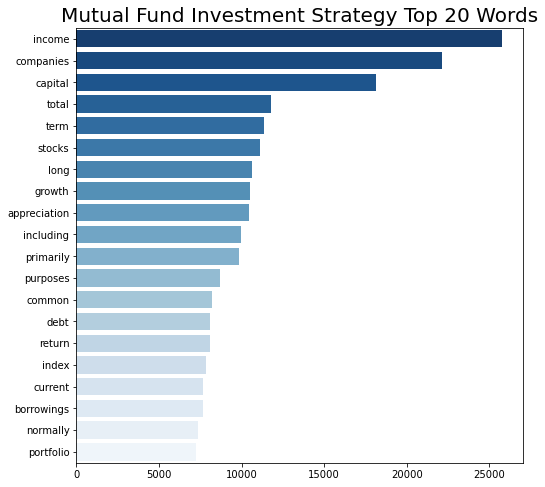

In [45]:
top_words(mutual_fund, 'updated_inv_strategy', 20, 1, 'Mutual Fund Investment Strategy Top 20 Words', 'Blues_r')

It's not surprising to see that the top keywords are about: `income`, `companies`, and `capital`. Let's take a look at the phrases for more meaningful interpretation of the investment strategy:

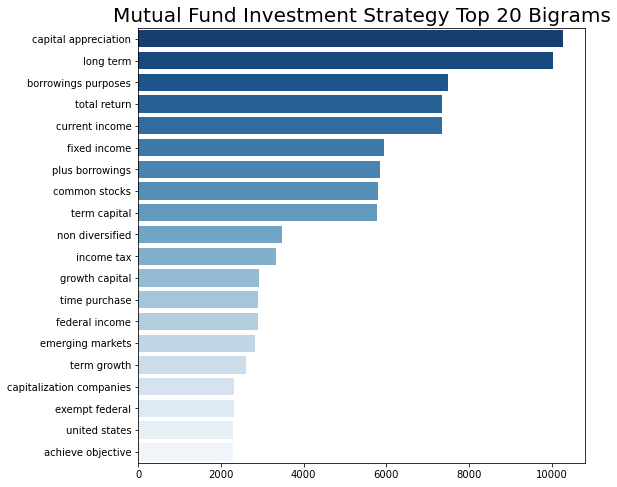

In [46]:
top_words(mutual_fund, 'updated_inv_strategy', 20, 2, 'Mutual Fund Investment Strategy Top 20 Bigrams', 'Blues_r')

In [47]:
top_words(mutual_fund, 'updated_inv_strategy', 20, 3, 'Mutual Fund Investment Strategy Top 20 Trigrams', 'Blues_r')

In [48]:
top_words(mutual_fund, 'updated_inv_strategy', 20, 4, 'Mutual Fund Investment Strategy Top 20 Four-grams', 'Blues_r')

In [49]:
top_words(mutual_fund, 'updated_inv_strategy', 20, 5, 'Mutual Fund Investment Strategy Top 20 Five-grams', 'Blues_r')

From the n-grams chart, we can see that most of the investment strategy usually points to a few things:
- The fund manager would focus on `long term capital appreciation` and `long term capital growth`, focusing on a composition of stocks with high growth value potential
- Quite a number of the mutual funds earnings are `exempted from federal income tax`
- Fund managers rely heavily `fundamental analysis factors` to make investment decisions

Based on the frequency of phrases in the four-grams and five-grams, it seems that many of the phrases are repeated. These suggest that the same fund managers are likely submitting the same `investment strategy` across different portfolio, which could have been done for convenience purpose.

Now we'll look at the ETF dataset:

#### `ETFs.csv`

In [50]:
etf['investment_strategy'].head()

0              The investment seeks total return in excess of inflation through capital growth and current income. The fund will invest at least 80% of its net assets, plus the amount of any borrowings for investment purposes, in a combination of investments that the Advisor believes offer exposure to "real assets." It generally invests between 25% and 75% of fund assets in securities of foreign issuers, including up to 10% of fund assets in issuers located in countries with new or emerging markets.
1    The investment seeks long-term capital appreciation. The fund seeks to achieve its objective by normally investing at least 80% of its net assets (plus borrowings made for investment purposes) in health sciences-related companies. The portfolio manager considers health sciences-related companies to include companies that design, manufacture or sell products or services used for or in connection with healthcare, medicine or life sciences. The fund will invest primarily in common stocks 

We'll apply the same processing steps to this dataset as well.

In [51]:
etf['updated_inv_strategy'] = etf['investment_strategy'].str.extract(r"^The investment seeks\s(.*)")

In [52]:
etf['updated_inv_strategy'] = etf['updated_inv_strategy'].map(preprocessing)

In [53]:
etf['updated_inv_strategy'] 

0                                                                                                                              total return excess inflation capital growth current income  least      plus amount borrowings purposes  combination advisor believes offer exposure  real   generally         foreign issuers  including     issuers located countries new emerging markets 
1                            long term capital appreciation  seeks achieve objective normally investing least      plus borrowings made purposes  health sciences related companies  portfolio manager considers health sciences related companies include companies design  manufacture sell products services used connection healthcare  medicine life sciences  primarily common stocks 
2                                                                       highest total return consistent mix     meaning seeks achieve objective investing exchange traded  etfs  advised american century  collectively  underlying  represent

In [54]:
top_words(etf, 'updated_inv_strategy', 20, 2, 'ETF Investment Strategy Top 20 Bigrams', 'Reds_r')

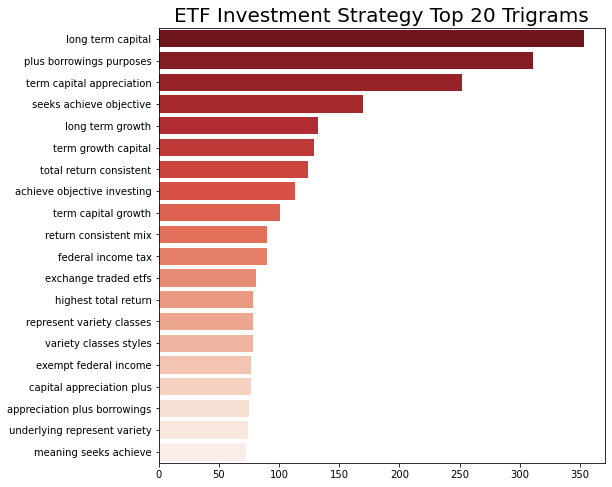

In [55]:
top_words(etf, 'updated_inv_strategy', 20, 3, 'ETF Investment Strategy Top 20 Trigrams', 'Reds_r')

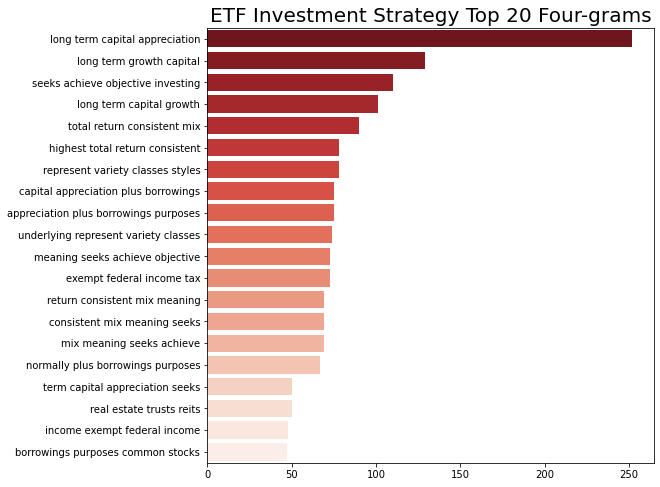

In [56]:
top_words(etf, 'updated_inv_strategy', 20, 4, 'ETF Investment Strategy Top 20 Four-grams', 'Reds_r')

In [57]:
top_words(etf, 'updated_inv_strategy', 20, 5, 'ETF Investment Strategy Top 20 Five-grams', 'Reds_r')

From the n-grams chart, we can see that ETF investment strategy is not too different from mutual fund, which also focuses on `long term capital appreciation` and are also `exempted from federal income tax`.

Though interestingly, we also see for ETF specifically that:
- Mentions of `consistent mix` as passively managed funds, indicating that the management may use this phrase to reassure investors that the portfolio re-allocation will not vary too much
- The ETF also focuses on identifying `underlying stock` and aims to `draw growth value`

### Initial & subsequent investment

Next we'll take a look at the `initial_investment` and `subsequent_investment` (only in `MutualFunds.csv`) to better understand the level of invesment required of the investors. We'll be removing the zero values from the data as it would impact the visualization.

In [58]:
no_zero_initial = mutual_fund.copy()
no_zero_initial = no_zero_initial.drop(no_zero_initial[no_zero_initial['initial_investment'] == 0].index)

In [59]:
no_zero_initial['initial_investment'].describe()

count    1.632300e+04
mean     5.213848e+06
std      9.298889e+07
min      1.000000e+01
25%      1.000000e+03
50%      2.500000e+03
75%      5.000000e+05
max      5.000000e+09
Name: initial_investment, dtype: float64

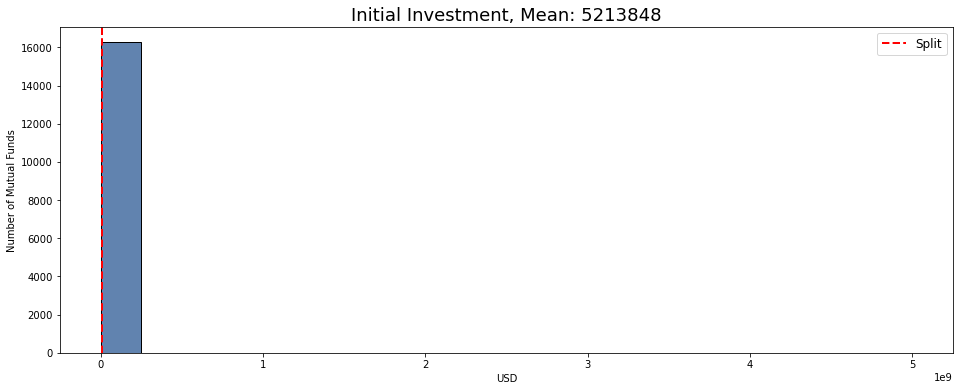

In [60]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_initial['initial_investment'], bins=20, color='#2c5a94')
mean = no_zero_initial['initial_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Initial Investment, Mean: {round(mean)}', fontsize=18)
plt.show()

The histogram for `initial_investment` is centering around 0 and there are probably outliers that we can handle so we can view the column's distribution.

In [61]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.boxplot(no_zero_initial['initial_investment'], color='#2c5a94')
mean = no_zero_initial['initial_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Initial Investment, Mean: {round(mean)}', fontsize=18)
plt.show()

Based on the boxplots, we can see there are several abnormally large figures. We'll attempt to remove the values above USD2 million and see what happens to the distribution. 

In [62]:
no_outlier_initial = no_zero_initial.drop(no_zero_initial[no_zero_initial['initial_investment'] > 1000000000].index)

In [63]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_outlier_initial['initial_investment'], bins=20, color='#2c5a94')
mean = no_outlier_initial['initial_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Initial Investment, Mean: {round(mean)} (no outliers)', fontsize=18)
plt.show()

Unfortunately, that didn't make much difference to our chart - except dropping the average initial investment to USD2,306,670.

In [64]:
no_zero_subsq = mutual_fund.copy()
no_zero_subsq = no_zero_subsq.drop(no_zero_subsq[no_zero_subsq['subsequent_investment'] == 0].index)

In [65]:
no_zero_subsq['subsequent_investment'].describe()

count      8852.000000
mean       1013.038861
std       11030.063850
min           1.000000
25%          50.000000
50%          50.000000
75%         100.000000
max      500000.000000
Name: subsequent_investment, dtype: float64

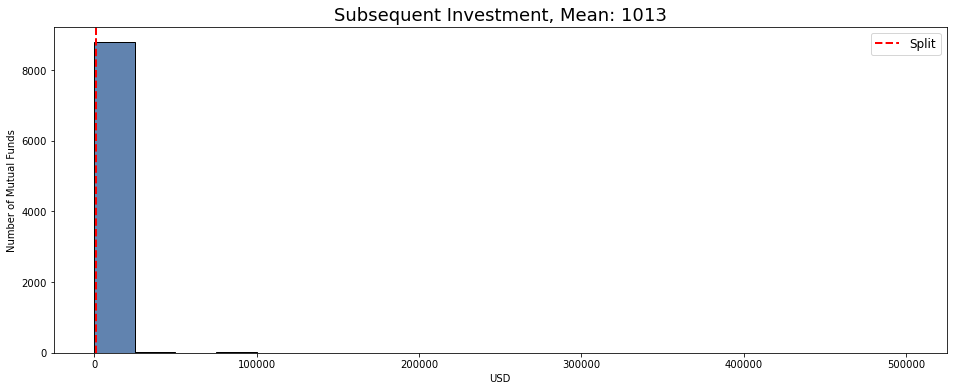

In [66]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_subsq['subsequent_investment'], bins=20, color='#2c5a94')
mean = no_zero_subsq['subsequent_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Subsequent Investment, Mean: {round(mean)}', fontsize=18)
plt.show()

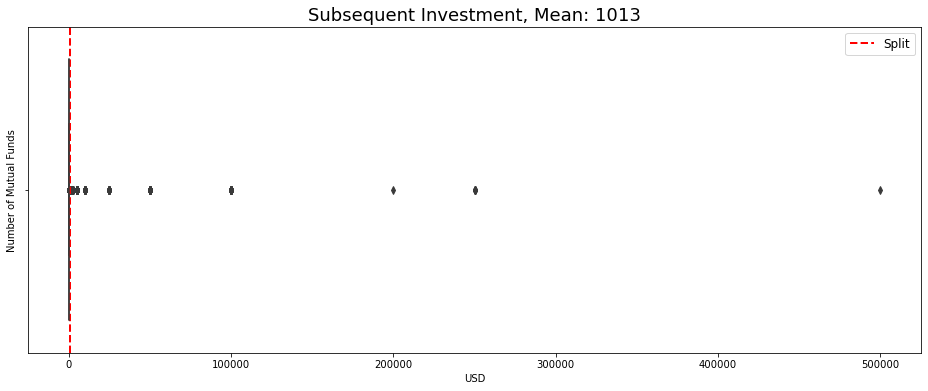

In [67]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.boxplot(no_zero_subsq['subsequent_investment'], color='#2c5a94')
mean = no_zero_subsq['subsequent_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Subsequent Investment, Mean: {round(mean)}', fontsize=18)
plt.show()

We'll attempt to remove outliers from the subsequent investment column, but we suspect it won't make much difference.

In [68]:
no_outlier_subsq = no_zero_subsq.drop(no_zero_subsq[no_zero_subsq['subsequent_investment'] > 200000].index)

In [69]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_outlier_subsq['subsequent_investment'], bins=20, color='#2c5a94')
mean = no_outlier_subsq['subsequent_investment'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Subsequent Investment, Mean: {round(mean)} (no outliers)', fontsize=18)
plt.show()

Unfortunately, even after removing the zero values and outliers the data is very left-skewed - the minimum initial investment is USD10 and maximum is USD5,000,000,000. While the minimum subsequent investment is USD1 and maximum is USD500,000.

This shows that the investment really varies as it is ultimately up to the investors' agreement with the fund managers. We'll not be using this feature in the modeling process.

### Total net assets

A fund's total net assets refers to the total value of all the cash and securities in its portfolio (less any liabilities).

#### `MutualFunds.csv`

In [70]:
no_zero_assets = mutual_fund.copy()
no_zero_assets = no_zero_assets.drop(no_zero_assets[no_zero_assets['total_net_assets'] == 0].index)

In [71]:
no_zero_assets['total_net_assets'].describe()

count    2.353400e+04
mean     4.920094e+09
std      2.106891e+10
min      1.000000e+01
25%      1.452373e+08
50%      6.463689e+08
75%      2.461762e+09
max      7.534100e+11
Name: total_net_assets, dtype: float64

In [72]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_assets['total_net_assets'], bins=20, color='#2c5a94')
mean = no_zero_assets['total_net_assets'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Total Net Assets, Mean: {round(mean)}', fontsize=18)
plt.show()

When we remove the zero values, we can see that the minimum total net assets of the mutual funds is USD10 while the maximum is USD753,410,000,000.

The histogram is also left-skewed - however we do need to keep this column as it's very likely to impact the fund performance.

#### `ETFs.csv`

In [73]:
no_zero_assets_etf = etf.copy()
no_zero_assets_etf = no_zero_assets_etf.drop(no_zero_assets_etf[no_zero_assets_etf['total_net_assets'] == 0].index)

In [74]:
no_zero_assets_etf['total_net_assets'].describe()

count    1.274000e+03
mean     2.376739e+09
std      2.458052e+10
min      2.000000e+01
25%      2.227563e+07
50%      9.778017e+07
75%      5.651520e+08
max      7.534100e+11
Name: total_net_assets, dtype: float64

In [75]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_assets_etf['total_net_assets'], bins=20, color='#87afe2')
mean = no_zero_assets_etf['total_net_assets'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Total Net Assets, Mean: {round(mean)}', fontsize=18)
plt.show()

The minimum total net assets of the ETFs is USD20 while the maximum is USD753,410,000,000.

The histogram is also left-skewed - but we will retain for modeling.

### Investment type

There are three main types of investments: Growth, Value and Blend.

**Growth** stocks are shares of companies with expected high growth rates in revenue and returns to investors. These companies have the potential for gains in the short term and perform in bull markets (where market is rising and economy is sound). Low interest rates also allow these companies to borrow cheaper capital to finance their growth and innovation. Therefore, growth stocks are usually concentrated in the technology and healthcare sectors.

Meanwhile, **value** stocks are shares of companies that trade at a lower price relative to company's financial performance. These are typically bigger, older and more established companies - they tend to do well in market downturns and they are less volatile than growth stocks. Value stocks are seen as "safe haven" during economic uncertainty as they are more established. Some example sectors include financials, energy or industrials - they are able to pay out higher dividends as their products and services don't require much reinvestment.

**Blend** portfolio is a combination of both growth and value stocks, with the aim of ensuring a diverse portfolio.

([source](https://www.businessinsider.com/personal-finance/value-vs-growth-stocks))

#### `MutualFunds.csv`

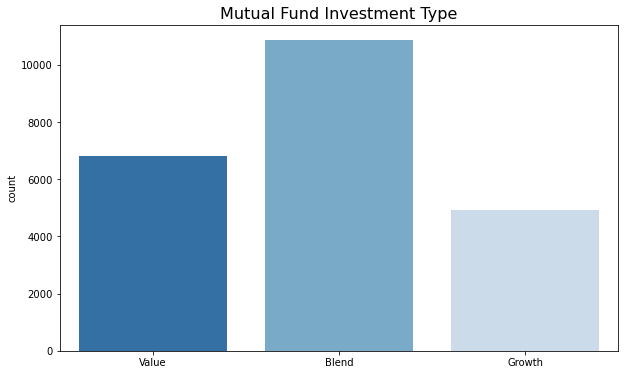

In [76]:
plt.figure(figsize=(10,6))
sns.countplot(mutual_fund['investment_type'].drop(mutual_fund[mutual_fund['investment_type'] == 'None'].index), palette='Blues_r')
plt.xlabel('')
plt.title('Mutual Fund Investment Type', fontsize=16);

In [77]:
mutual_fund['investment_type'].value_counts()

Blend     10865
Value      6800
Growth     4925
None        977
Name: investment_type, dtype: int64

Interestingly, we see more `Value` mutual funds compared to `Growth`. Likely fund managers and investors could be more risk-averse and are choosing to invest in low-value stocks so that there's less risk and volatility. Even if the price don't increase significantly, investors will still gain some returns, especially in the form of dividends.

`Growth` stocks don't usually pay dividends as it is invested back into the companies. So for this portfolio, the rewards are much higher if the companies grow but the probability of loss is also greater compared to `Value` funds.

([source](https://www.investopedia.com/articles/professionals/072415/value-or-growth-stocks-which-best.asp))

#### `ETFs.csv`

In [78]:
plt.figure(figsize=(10,6))
sns.countplot(etf['investment_type'].drop(etf[etf['investment_type'] == 'None'].index), palette='Reds_r')
plt.xlabel('')
plt.title('ETF Investment Type', fontsize=16);

In [79]:
etf['investment_type'].value_counts()

Blend     460
None      330
Value     280
Growth    233
Name: investment_type, dtype: int64

Naturally we would expect most ETFs would also have a `Blend` portfolio. Second highest is `Value`, followed by `Growth`. This shows that the investment strategy between mutual funds and ETFs are not too different.

### Size type

The size of a fund refers to its total asset base, or the total amount of money that is being managed and invested. Naturally, strong performance will lead to increase in fund's asset size. However, a fund's asset size can continue to grow even if it has a negative return as long as there's an inflow of investment. 

Unfortunately, there's no formula that can tell which fund size or the type of growth that will hinder performance - but one thing is clear: when the fund manager cannot sustain the initial strategy and produce comparable results to its historical record - the fund has become too large.

Therefore, fund's size must be looked at in the context of its investment style. Both of these go hand-in-hand as fund managers will need to adjust the size and investment styles accordingly. 

For instance, a small-cap growth fund that grows in asset size from USD100mil to USD1bil won't be effective in following its initial strategy. Another example, if a fund attracts too much money, the fund manager may run into issue trying to purchase additional large blocks of shares without driving up the price - causing the performance to slip. 

([source](https://www.investopedia.com/articles/mutualfund/03/071603.asp))

#### `MutualFunds.csv`

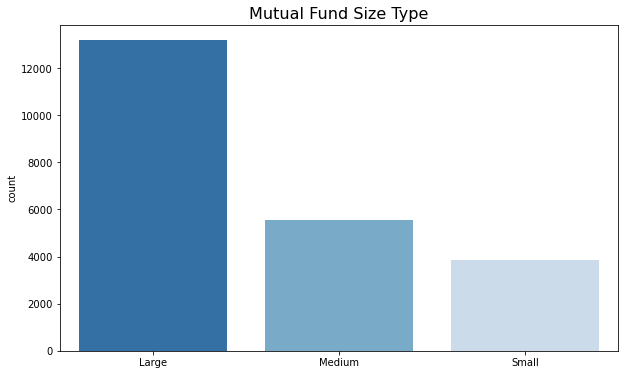

In [80]:
plt.figure(figsize=(10,6))
sns.countplot(mutual_fund['size_type'].drop(mutual_fund[mutual_fund['size_type'] == 'None'].index), palette='Blues_r')
plt.xlabel('')
plt.title('Mutual Fund Size Type', fontsize=16);

In [81]:
mutual_fund['size_type'].value_counts()

Large     13185
Medium     5533
Small      3868
None        981
Name: size_type, dtype: int64

Most of our data includes mutual funds that are considered `Large` - nearly doubled of the combined total of `Medium` and `Small` funds.

The size of a mutual fund is based on the total net assets, and this would impact the investment style. So instead of looking at the size on its own, we'll look at it together with the total net assets and investment type.

In [82]:
no_zero_assets['total_net_assets'].groupby(no_zero_assets['size_type']).describe()

count          mean           std      min          25%  \
size_type                                                              
Large      13171.0  6.300810e+09  2.646215e+10     10.0  140452048.0   
Medium      5532.0  3.835606e+09  1.279327e+10  13537.0  165376456.0   
None         968.0  9.633398e+08  2.284301e+09     10.0   26181794.0   
Small       3863.0  2.757040e+09  8.028161e+09  77972.0  187080312.0   

                   50%           75%           max  
size_type                                           
Large      679051968.0  2.738629e+09  7.534100e+11  
Medium     666201984.0  2.442305e+09  2.516531e+11  
None       179022896.0  6.867639e+08  1.634595e+10  
Small      707815424.0  2.233739e+09  1.377248e+11

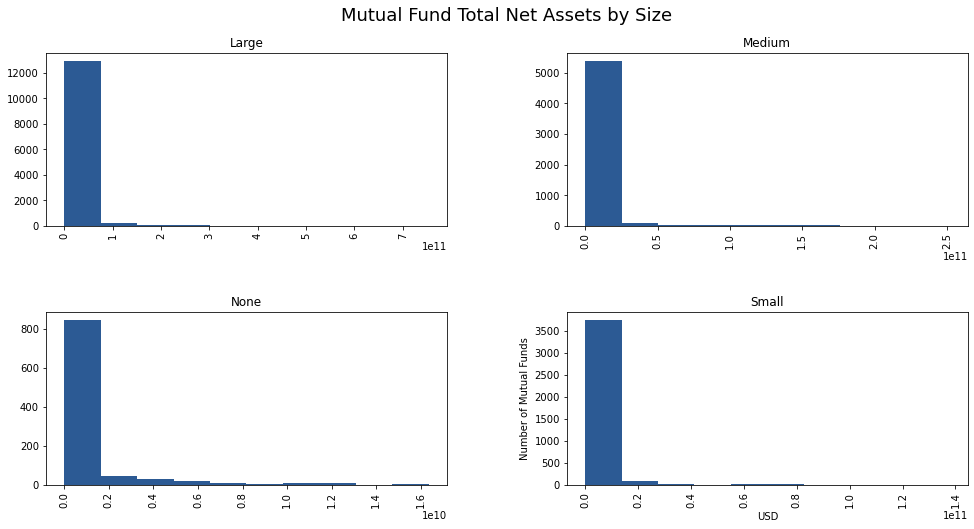

In [83]:
no_zero_assets['total_net_assets'].hist(by=no_zero_assets['size_type'], figsize=(16,8), color='#2c5a94')
plt.suptitle(f'Mutual Fund Total Net Assets by Size', fontsize=18)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.show()

When we look at the statistics summary and histograms for the mutual fund based on size, it's interesting to note:
- The distribution for all sizes are left-skewed but we should retain this feature for modeling
- It's likely that the size of the fund was determined based on the mean total net assets value
- Eventhough `large` mutual fund has the most rows, the data is more spread out compared to the other sizes
- At the 25% and 50% mark, the `small` mutual fund have a much higher total net assets value than the other sizes

In [84]:
mutual_fund['investment_type'].groupby(mutual_fund['size_type']).value_counts()

size_type  investment_type
Large      Blend              7441
           Growth             2873
           Value              2871
Medium     Blend              2403
           Value              1864
           Growth             1266
None       None                977
           Value                 4
Small      Value              2061
           Blend              1021
           Growth              786
Name: investment_type, dtype: int64

In terms of investment type and size type:
- Most of the `Large` mutual funds have a `Blend` portfolio
- While many of the `Medium` mutual funds have a `Blend` portfolio, there are more `Value` stocks compared to `Growth`
- As for the `Small` mutual funds, we see that most of the stocks are `Value` type (which is more focused on undervalued companies)

([source](https://www.fidelity.com/learning-center/trading-investing/markets-sectors/why-market-cap-matters))

When mutual funds become too large, the portfolio begin to resemble the performance of index funds and ETFs - except mutual funds have larger fees as it is actively managed. 

So when the asset base grows, fund managers must spread the money over a larger number of stocks because investing a large amount in a few stocks can affect the share prices. 

([source](https://www.investopedia.com/articles/mutualfund/03/071603.asp))

#### `ETFs`

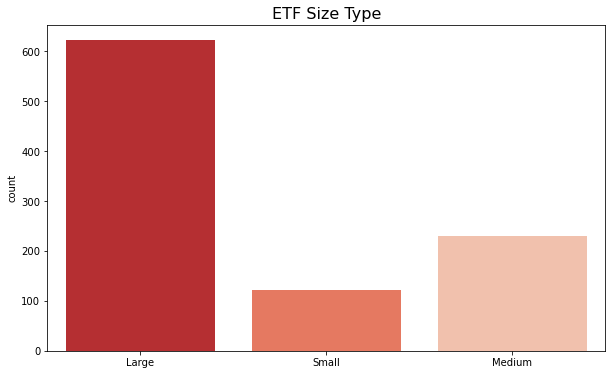

In [85]:
plt.figure(figsize=(10,6))
sns.countplot(etf['size_type'].drop(etf[etf['size_type'] == 'None'].index), palette='Reds_r')
plt.xlabel('')
plt.title('ETF Size Type', fontsize=16);

In [86]:
etf['size_type'].value_counts()

Large     622
None      330
Medium    230
Small     121
Name: size_type, dtype: int64

Similarly to mutual funds, the number of `Large` ETFs is nearly doubled the total of `Medium` and `Small` ones. Now let's look at the breakdown against `total_net_assets` and `investment_type`.

In [87]:
no_zero_assets_etf['total_net_assets'].groupby(no_zero_assets_etf['size_type']).describe()

count          mean           std        min         25%  \
size_type                                                             
Large      617.0  3.512060e+09  3.493775e+10       20.0  20610714.0   
Medium     230.0  8.263455e+08  2.843249e+09  1268811.0  20489361.0   
None       307.0  1.681866e+09  6.445144e+09       20.0  24956033.0   
Small      120.0  1.288597e+09  2.941748e+09  1235320.0  43239409.0   

                   50%          75%           max  
size_type                                          
Large       86901352.0  481263424.0  7.534100e+11  
Medium      88499244.0  493929880.0  2.677675e+10  
None       109767800.0  609913728.0  5.926184e+10  
Small      175686440.0  951665904.0  1.673194e+10

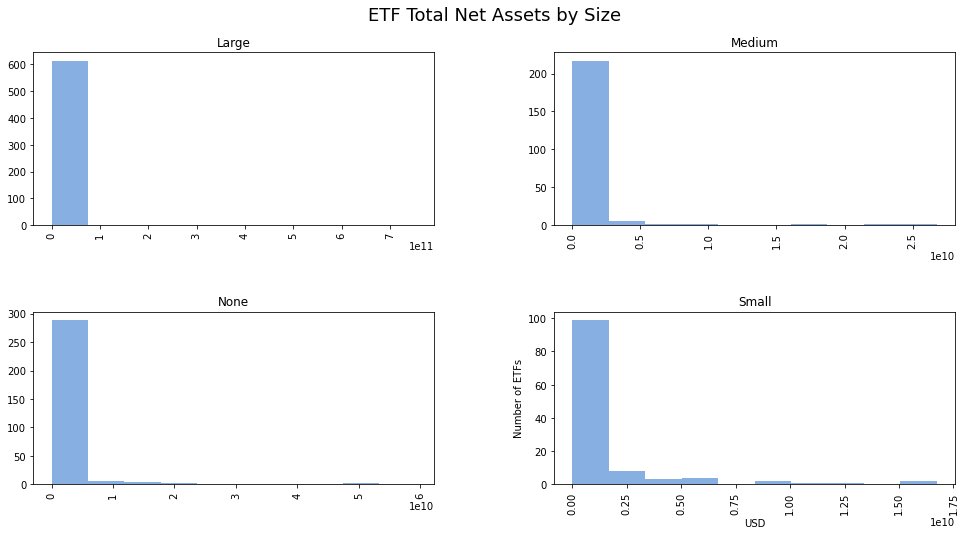

In [88]:
no_zero_assets_etf['total_net_assets'].hist(by=no_zero_assets_etf['size_type'], figsize=(16,8), color='#87afe2')
plt.suptitle(f'ETF Total Net Assets by Size', fontsize=18)
plt.xlabel('USD')
plt.ylabel('Number of ETFs')
plt.show()

When we look at the `total_net_assets` spread: 
- All of the data is left-skewed
- The `total_net_assets` for `Medium` and `Small` ETFs have similar data spread based on the standard deviation, while the `Large` ETF has the biggest spread
- Interestingly, the mean `total_net_assets` for `Small` ETF is higher than `Medium` sized ones. Typically `Small` ETFs have a niche investment strategy - the same applies to mutual fund as well
- In terms of minimum value, the `total_net_assets` for `Medium` and `Small` ETF are similar, while the `Large` one is unusually low

As for the `investment_type`:

In [89]:
etf['investment_type'].groupby(etf['size_type']).value_counts()

size_type  investment_type
Large      Blend              339
           Growth             145
           Value              138
Medium     Value               98
           Blend               71
           Growth              61
None       None               330
Small      Blend               50
           Value               44
           Growth              27
Name: investment_type, dtype: int64

In terms of investment type and size type:
- Most of the `Large` ETFs have a `Blend` portfolio
- Most of the `Medium` ETF have an investment a `Value` strategy
- Meanwhile for `Medium` and `Small`ETFs, the proportion seems more balanced across the different investment types

### Fund category

A fund category differentiates mutual funds based on the objectives and principal investment features - allowing investors to diversify their portfolio. 

#### `MutualFunds.csv`

In [90]:
plt.figure(figsize=(12,6))
fund_cat=mutual_fund['fund_category'].value_counts(ascending=False)[:20]
sns.barplot(x=fund_cat.values, y=fund_cat.index, palette='Blues_r')
plt.title('Fund Categories (Top 20)')
plt.tight_layout
plt.show()

In [91]:
plt.figure(figsize=(12,6))
fund_cat=mutual_fund['fund_category'].value_counts(ascending=True)[:20]
sns.barplot(x=fund_cat.values, y=fund_cat.index, palette='Blues_r')
plt.title('Fund Categories (Bottom 20)')
plt.tight_layout
plt.show()

For fund categories, this appears to be a segment manually typed out by the fund managers resulting in a long list of categories. But we can see the top three categories are: `Large Blend`, `Large Growth`, `Large Value`

#### `ETFs`

In [92]:
plt.figure(figsize=(12,6))
etf_cat=etf['fund_category'].value_counts(ascending=False)[:20]
sns.barplot(x=etf_cat.values, y=etf_cat.index, palette='Reds_r')
plt.title('ETF Categories (Top 20)')
plt.tight_layout
plt.show()

In [93]:
plt.figure(figsize=(12,6))
etf_cat=etf['fund_category'].value_counts(ascending=True)[:20]
sns.barplot(x=etf_cat.values, y=etf_cat.index, palette='Reds_r')
plt.title('ETF Categories (Bottom 20)')
plt.tight_layout
plt.show()

There's quite a number of missing empty values - more than 400 out of 1,300+ rows. After the missing values, `Large Blend` portfolio makes up most of the ETFs.

Overall this column will not be very useful in the modeling process, and will be dropped.

### Returns

Returns is defined as the percentage change in an investment over a time period - an important indicator of whether a fund has made or lost money. 

#### Year-to-date return

First, we'll take a look at the `return_ytd` that refers to the amount gained or loss since the first trading day of the current calendar year. 

##### `MutualFunds.csv`

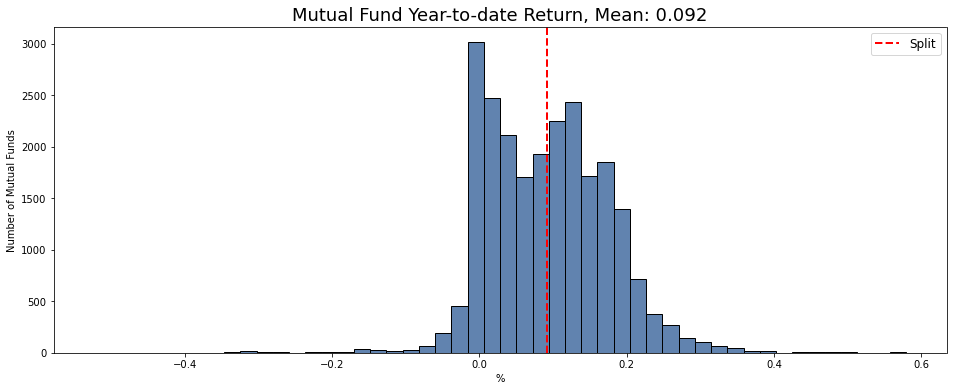

In [94]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(mutual_fund['fund_return_ytd'], bins=50, color='#2c5a94')
mean = mutual_fund['fund_return_ytd'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Year-to-date Return, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The year-to-date return average is 9.2% for the mutual funds in 2020-2021. Overall, the distribution of the year-to-date returns appears to be normally distributed. We could potentially use this as the target variable.

In [95]:
mutual_fund['fund_return_ytd'].groupby(mutual_fund['size_type']).describe()

count      mean       std     min     25%     50%     75%  \
size_type                                                                
Large      13185.0  0.104037  0.067757 -0.5228  0.0631  0.1080  0.1498   
Medium      5533.0  0.082742  0.095223 -0.1456  0.0063  0.0373  0.1543   
None         981.0  0.019377  0.096020 -0.3357 -0.0010  0.0078  0.0320   
Small       3868.0  0.084740  0.091978 -0.1988  0.0144  0.0461  0.1545   

               max  
size_type           
Large      0.53981  
Medium     0.57890  
None       0.44250  
Small      0.49870

When we look at the `fund_return_ytd` against the `size_type`, we can see that the `Large` mutual fund had the highest return, as well as the lowest standard deviation. Meanwhile the `Medium` and `Small` sized ones have similar average return and standard deviation. 

In [96]:
mutual_fund['fund_return_ytd'].groupby(mutual_fund['investment_type']).describe()

count      mean       std      min     25%     50%     75%  \
investment_type                                                                 
Blend            10865.0  0.093471  0.072274 -0.19861  0.0344  0.0965  0.1393   
Growth            4925.0  0.094045  0.078460 -0.52280  0.0413  0.1002  0.1470   
None               977.0  0.019386  0.096214 -0.33570 -0.0010  0.0078  0.0321   
Value             6800.0  0.099800  0.092757 -0.11860  0.0146  0.0789  0.1765   

                     max  
investment_type           
Blend            0.48397  
Growth           0.57890  
None             0.44250  
Value            0.57300

When we look at the `fund_return_ytd` against `investment_type`, all of the different investment types have roughly similar average returns. In terms of standard deviation, `Value` portfolio has the wider spread of data, which is evident when we compare the min and max values with the other strategies.

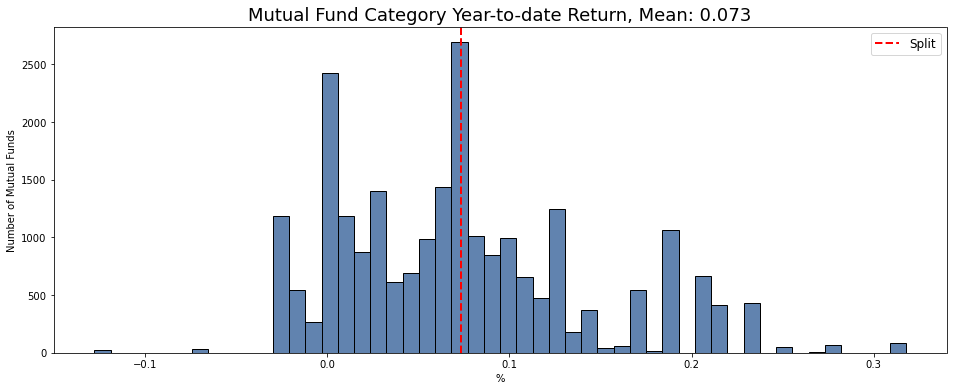

In [97]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(mutual_fund['category_return_ytd'], bins=50, color='#2c5a94')
mean = mutual_fund['category_return_ytd'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Category Year-to-date Return, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The `category_return_ytd` refers to the fund's performance compared to the market. This mean for this column is lower compared to the `fund_return_ytd`, which makes sense after adjusting to market exposure. The distribution is not very normal for this column, so we'll likely not use this as a feature in the modeling process.

In [98]:
mutual_fund['category_return_ytd'].groupby(mutual_fund['size_type']).describe()

count      mean       std     min     25%     50%     75%     max
size_type                                                                     
Large      13185.0  0.080780  0.052614 -0.1279  0.0518  0.0745  0.1080  0.2741
Medium      5533.0  0.062887  0.084377 -0.0703  0.0041  0.0246  0.1161  0.3176
None         981.0  0.022080  0.057717 -0.1279 -0.0052  0.0065  0.0252  0.2474
Small       3868.0  0.076112  0.088661 -0.0703  0.0127  0.0315  0.2024  0.3176

The `category_return_ytd` follows similar pattern as the `fund_return_ytd`, where the `Large` funds had the highest return and smallest standard deviation as compared to the market. The `Medium` and `Small` sized ones have similar mean and standard deviation.

##### `ETFs`

In [99]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(etf['fund_return_ytd'], bins=50, color='#87afe2')
mean = etf['fund_return_ytd'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Year-to-date Return, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The overall ETF year-to-date average return is 8.4% for 2020-2021, lower than the mutual fund average.

Based on the histogram, we can see that the ETF year-to-date average return has a relatively normal distribution, although there is a spike in around 0.00% and 0.05%. We'll most likely use this data as a target variable in our modeling process.

In [100]:
etf['fund_return_ytd'].groupby(etf['size_type']).describe()

count      mean       std     min      25%      50%       75%  \
size_type                                                                  
Large      622.0  0.094104  0.082825 -0.1440  0.03345  0.10075  0.145850   
Medium     230.0  0.114567  0.151842 -0.3666  0.00350  0.11335  0.182975   
None       330.0  0.008180  0.175191 -0.6602 -0.01255  0.00000  0.015525   
Small      121.0  0.176491  0.206548 -0.1177  0.03500  0.16530  0.259900   

              max  
size_type          
Large      0.8029  
Medium     1.1698  
None       1.1569  
Small      1.6727

Based on the summary statistics against `size_type`:
- `Small` ETF has the highest average return and widest data spread - we're seeing interesting trends with the `Small` ETF and it could be worth investigating
- `Large` ETF has the lowest average return and the smallest data spread

In [101]:
etf['fund_return_ytd'].groupby(etf['investment_type']).describe()

count      mean       std     min       25%      50%  \
investment_type                                                         
Blend            460.0  0.096295  0.116566 -0.3666  0.030775  0.09545   
Growth           233.0  0.069323  0.103817 -0.2126  0.000000  0.05400   
None             330.0  0.008180  0.175191 -0.6602 -0.012550  0.00000   
Value            280.0  0.163536  0.138406 -0.0474  0.080525  0.14950   

                      75%     max  
investment_type                    
Blend            0.150275  1.6727  
Growth           0.125100  0.5424  
None             0.015525  1.1569  
Value            0.215300  1.1698

Based on the `investment_type`, 
- ETFs with `Value` strategy has the highest average fund return to date and widest standard deviation, followed by `Blend` and `Growth`
- Interestingly `Blend` strategy saw the lowest minimum return, although the maximum value is the highest out of the different investment types

In [102]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(etf['category_return_ytd'], bins=50, color='#87afe2')
mean = etf['category_return_ytd'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Category Year-to-date Return, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

When we look at the ETF adjusted returns based on market exposure, the distribution becomes right-skewed. The distribution on the left side is slightly normal but there's an unusually high volume of ETFs with returns between 0.00 to 0.01. 

In [103]:
etf['category_return_ytd'].groupby(etf['size_type']).describe()

count      mean       std     min  25%     50%     75%     max
size_type                                                                
Large      622.0  0.048819  0.056515 -0.0380  0.0  0.0411  0.0750  0.6157
Medium     230.0  0.065361  0.116790 -0.0380  0.0  0.0480  0.1012  0.8820
None       330.0  0.036185  0.045978 -0.0226  0.0  0.0102  0.0625  0.1540
Small      121.0  0.069253  0.139636 -0.0380  0.0  0.0665  0.0846  0.8820

In terms of ETF sizes, 
- The `Medium` and `Small` ETF average returns adjusted to around similar figure, while the `Small` ETF still has the widest spread of data
- The `Large` ETF still saw the lowest average returns and smallest standard deviation

In [104]:
etf['category_return_ytd'].groupby(etf['investment_type']).describe()

count      mean       std     min  25%     50%       75%  \
investment_type                                                             
Blend            460.0  0.052608  0.095270 -0.0380  0.0  0.0411  0.075000   
Growth           233.0  0.041552  0.098664 -0.0380  0.0  0.0014  0.054600   
None             330.0  0.036185  0.045978 -0.0226  0.0  0.0102  0.062500   
Value            280.0  0.071059  0.059216 -0.0380  0.0  0.0750  0.110525   

                    max  
investment_type          
Blend            0.8820  
Growth           0.8820  
None             0.1540  
Value            0.2041

In terms of ETF investment strategy, 
- `Value` strategy still had the highest average return in the category, however the standard deviation is lower than `Blend` and `Growth`
- Interestingly, `Blend` and `Growth` returns adjusted to around similar statistics across the board but the `Blend`'s mean is slightly higher likely due to bigger sample count

#### Fund return by time period

Next, we'll be looking at the fund returns by specific time period. We'll first create a function to generate multiple histograms:

In [105]:
# Function to customize multiple histograms

def multi_histo(dataframe, columns, title, color):
    nrows = int(np.ceil(len(columns)/5)) 
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, nrows*4)) 
    ax = ax.ravel() 
    
    for i, column in enumerate(columns): 
        mean = np.mean(dataframe[columns[i]])
        ax[i].axvline(mean, ls='--', color='red')
        
        sns.histplot(data=dataframe, x=dataframe[column], color=color, kde=False, ax=ax[i])
        ax[i].set_title(f'{column} Mean: {round(mean, 3)}', wrap=True, fontsize=11)
        ax[i].set_xlabel('')
        ax[i].tick_params(labelsize=10)
    plt.tight_layout(h_pad=1, w_pad=1)
    
    # Hide unused plots
    for i in range(nrows * ncols - len(columns)):
        ax[-i-1].set_visible(False) # Start from -1
        
    plt.suptitle(title, fontsize=20, y=1.035)

##### `MutualFunds.csv`

In [106]:
avg_returns = ['fund_return_1month', 'fund_return_3months', 'fund_return_1year', 'fund_return_3years', 'fund_return_5years', 'fund_return_10years']
multi_histo(mutual_fund, avg_returns, 'Mutual Fund Avg Returns by Time Period', color='#2c5a94')

For the mutual funds,
- The distribution of fund returns during the 1-month and 3-month periods appear to be normally distributed, with the mean appearing around the peak of the distribution
- The 1-year distribution has two peaks and the data overall appears more spread out, to account for more changes in the market within a year
- When the time period increases, the distribution becomes smoother and flatter, as evidently from 3-years, 5-years to 10-years 

##### `ETFs`

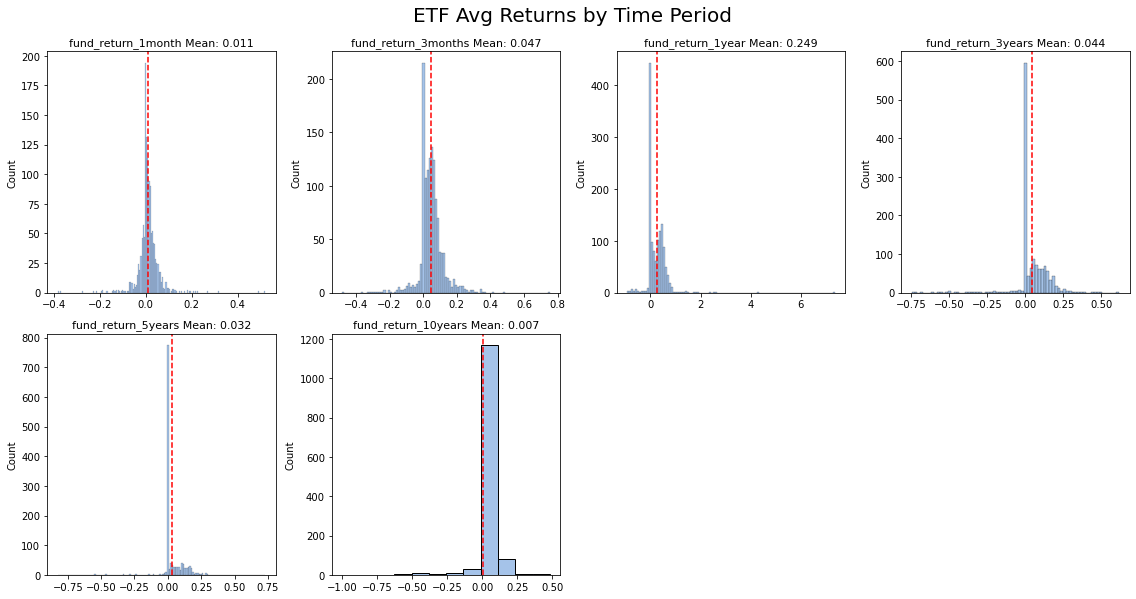

In [107]:
multi_histo(etf, avg_returns, 'ETF Avg Returns by Time Period', color='#87afe2')

ETFs on the other hand, 
- Similarly the 1-month and 3-month returns appear to be normally distributed with average appearing around the peak of the graphs
- The 1-year returns is right-skewed though we do see two peaks, similar to the mutual fund dataset
- However the 3-, 5- and 10-year returns appear to be left-skewed and we do see very high volume around 0.0, indicating that many of the rows were empty because the data may not be available 

#### Returns from 2000 - 2021

Next, we'll look at the returns based on quarterly and yearly basis:

##### `MutualFunds.csv`

For quarterly returns, we only have the dataset for mutual funds only:

In [108]:
# get column index for first quarter column

mutual_fund.columns.get_loc('fund_return_2021_q3')

146

In [109]:
# get column index for last quarter column

mutual_fund.columns.get_loc('fund_return_2000_q1')

232

In [110]:
q_returns = mutual_fund.iloc[:,146:233]

In [111]:
q_returns = q_returns.mean()

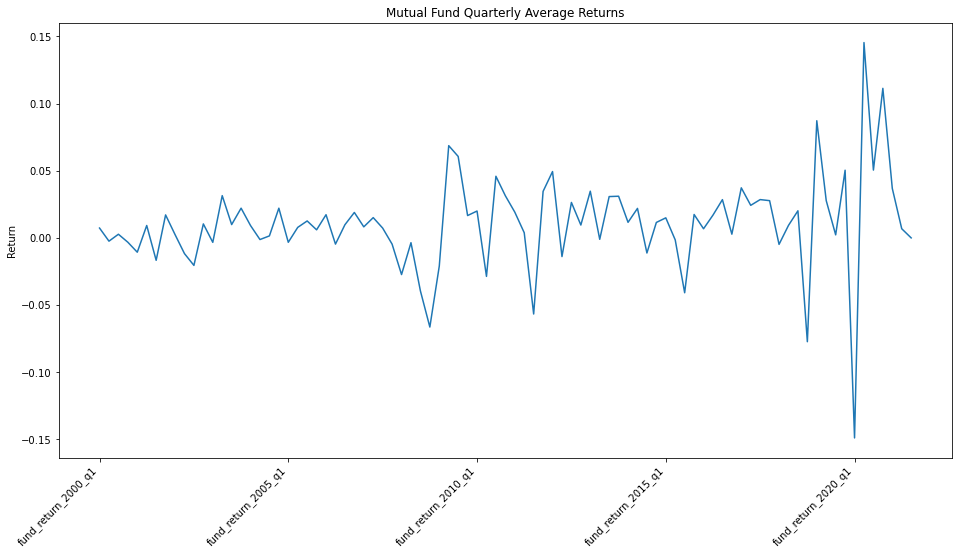

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
q_returns[::-1].plot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return')
plt.title('Mutual Fund Quarterly Average Returns')
plt.show()

Based on the quarterly returns, 
- The  returns from 2001 to 2008 hover around similar range but experience more dramatic spikes from 2009 onwards
- In 2019, we do see much bigger change in the average quarterly returns

Now let's take a look at the yearly figure instead:

In [113]:
mf_returns_years = mutual_fund[['fund_return_2000', 'fund_return_2001', 'fund_return_2002', 'fund_return_2003', 'fund_return_2004', 'fund_return_2005', 'fund_return_2006', 'fund_return_2007', 'fund_return_2008', 'fund_return_2009', 'fund_return_2010', 'fund_return_2011', 'fund_return_2012', 'fund_return_2013', 'fund_return_2014', 'fund_return_2015', 'fund_return_2016', 'fund_return_2017', 'fund_return_2018', 'fund_return_2019', 'fund_return_2020']].mean()

In [114]:
mf_cat_returns = mutual_fund[['category_return_2000', 'category_return_2001', 'category_return_2002', 'category_return_2003', 'category_return_2004', 'category_return_2005', 'category_return_2006', 'category_return_2007', 'category_return_2008', 'category_return_2009', 'category_return_2010', 'category_return_2011', 'category_return_2012', 'category_return_2013', 'category_return_2014', 'category_return_2015', 'category_return_2016', 'category_return_2017', 'category_return_2018', 'category_return_2019', 'category_return_2020']].mean()

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
mf_returns_years.plot()
mf_cat_returns.plot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return')
plt.title('Mutual Fund Yearly Average Returns')
legend = plt.legend(loc='best', labels=['Mutual Fund Return', 'Mutual Fund Category Return'], fontsize=12)
legend.get_title().set_fontsize('12')
plt.show()

Based on the year-to-date return averages and the category averages:
- The yearly returns appear more "smoothly" compared to the quarterly returns but does not reveal any surprising insights
- We would expect that the category return values to be lower than the actual fund return, but the category return is higher than the fund return most of the years
- We see a bigger gap in between the category and fund return average from 2000 to 2010, where the market was a lot more volatile at that time including the financial crisis in 2007 and 2008
- After 2000, we can see that the market stabilize and the fund return and its category average didn't have too much difference

##### `ETFs`

In [116]:
etf_returns_years = etf[['fund_return_2000', 'fund_return_2001', 'fund_return_2002', 'fund_return_2003', 'fund_return_2004', 'fund_return_2005', 'fund_return_2006', 'fund_return_2007', 'fund_return_2008', 'fund_return_2009', 'fund_return_2010', 'fund_return_2011', 'fund_return_2012', 'fund_return_2013', 'fund_return_2014', 'fund_return_2015', 'fund_return_2016', 'fund_return_2017', 'fund_return_2018', 'fund_return_2019', 'fund_return_2020']].mean()

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
etf_returns_years.plot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return')
plt.title('ETF Yearly Average Returns')
legend = plt.legend(loc='best', labels=['ETF Return'], fontsize=12)
legend.get_title().set_fontsize('12')
plt.show()

Interestingly ETF returns started out flat initially - likely due to the smaller number of ETF in the market at that time and the lack of available information. However from around 2008 onwards, the returns started to fluctuate around similar intervals.

News report showed that ETF experienced a boom after the recession - where in 2008, U.S. investors had USD531 billion in ETFs which jumped to more than USD3.4 trillion within 10 years. Although there are still more mutual assets in the market, ETF has continued to capture a bigger share of the market each year. This change was caused by a series of reasons: investors losing faith in active management, fee-based commission that was affecting their earnings and increase in cheaper (and free) ways to trade. ([source](https://www.cnbc.com/2018/09/14/the-trillion-dollar-etf-boom-triggered-by-the-financial-crisis.html))

Furthermore the ETF average return remained at a higher value in 2019 and 2020 - giving investors the confidence to pour in more funds. In the first half of 2021, ETFs achieved over USD15 trillion in assets for the first time. ([source](https://www.ft.com/content/7d5c2468-619c-4c4b-b3e7-b0da015e939d))

Category return information was not available in this dataset.

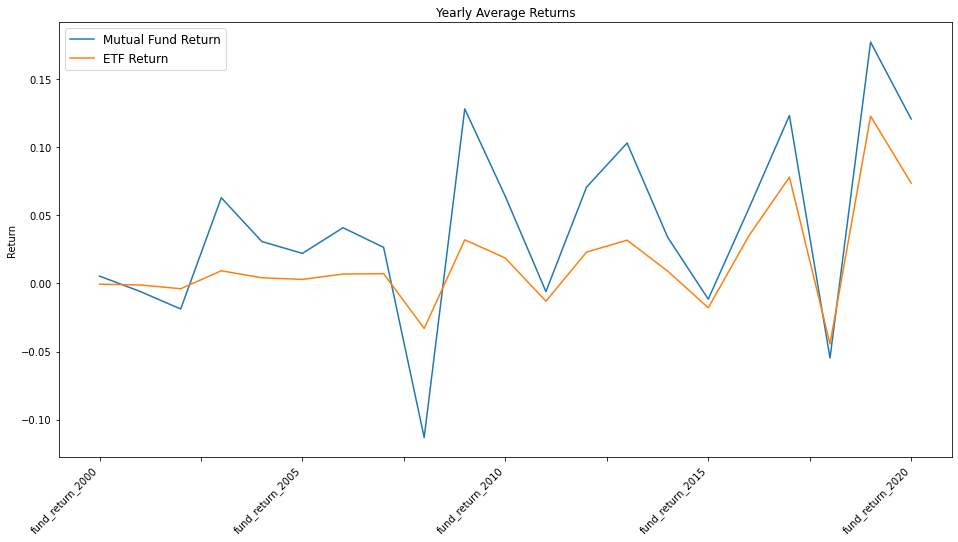

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
mf_returns_years.plot()
etf_returns_years.plot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return')
plt.title('Yearly Average Returns')
legend = plt.legend(loc='best', labels=['Mutual Fund Return', 'ETF Return'], fontsize=12)
legend.get_title().set_fontsize('12')
plt.show()

When we compare the yearly average returns between mutual funds and ETFs, 
- The trend lines are quite similar from 2009 onwards, a reflection of investors' confidence in the market
- The returns from mutual fund is certainly greater as there are more mutual funds in the market 
- But from 2015 onwards, we can see the difference between the average mutual funds and ETFs becoming smaller

#### Load-adjusted returns

Next, we'll look at the the load-adjusted returns which refers to the investment return on a mutual fund that has been adjusted for the fund's sales loads and other charges. This reflects the actual returns after removing the fees - which is a significant factor for many investors considering the switch to ETFs and index funds.

We only have dataset for mutual funds only:

In [119]:
adj_returns = ['load_adj_return_1year', 'load_adj_return_3years', 'load_adj_return_5years', 'load_adj_return_10years']
multi_histo(mutual_fund, adj_returns, 'Mutual Fund Adjusted Returns by Time Period', color='#2c5a94')

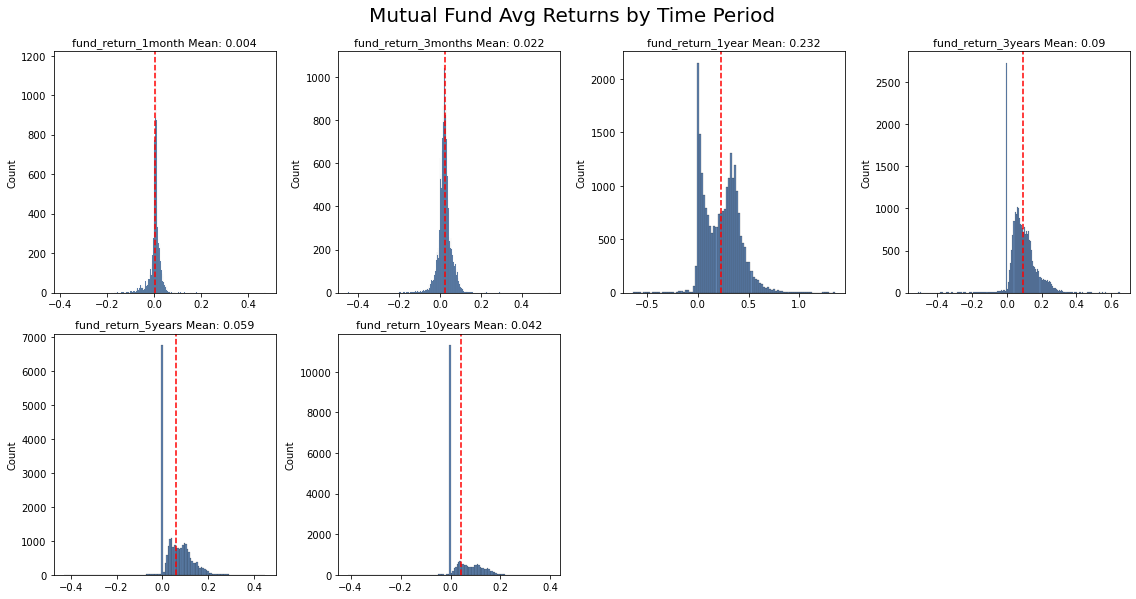

In [120]:
multi_histo(mutual_fund, avg_returns, 'Mutual Fund Avg Returns by Time Period', color='#2c5a94')

When we compare just the average returns vs load-adjusted returns, oddly enough, the adjusted returns is much higher than the average return. It's likely that the number of missing values is affecting the averages. We avoided removing the zero values as it would make sense for mutual funds to generate zero returns. 

Unfortunately, we'll have to omit this column as it won't be very helpful in the modeling section.

### Fund yield

Yield is the income earned on an investment, such as interest and dividends. This is different from return, which represents the profit or loss made based on the change in dollar amount. 

#### `MutualFunds.csv`

In [121]:
no_zero_yield = mutual_fund.copy()
no_zero_yield = no_zero_yield.drop(no_zero_yield[no_zero_yield['fund_yield'] == 0].index)

In [122]:
no_zero_yield['fund_yield'].describe()

count    18499.000000
mean         0.017407
std          0.023906
min          0.000100
25%          0.007000
50%          0.013400
75%          0.022400
max          1.258500
Name: fund_yield, dtype: float64

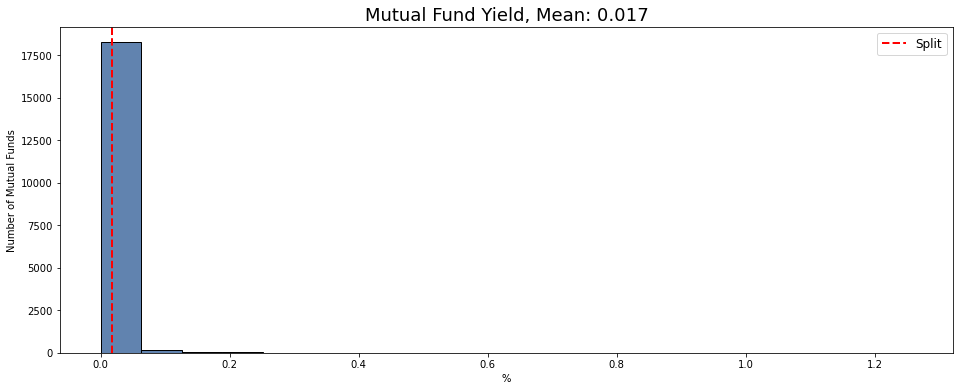

In [123]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_yield['fund_yield'], bins=20, color='#2c5a94')
mean = no_zero_yield['fund_yield'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Yield, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

Even after dropping the zero values, the fund yield appears to be quite low - with an average of 1.7%.

In [124]:
no_zero_yield['fund_yield'].groupby(no_zero_yield['size_type']).describe()

count      mean       std     min     25%      50%       75%  \
size_type                                                                   
Large      10350.0  0.013734  0.019206  0.0001  0.0063  0.01130  0.017000   
Medium      4449.0  0.017737  0.014610  0.0001  0.0087  0.01600  0.023100   
None         706.0  0.035853  0.075460  0.0002  0.0139  0.02185  0.037175   
Small       2994.0  0.025263  0.020230  0.0001  0.0076  0.02530  0.037600   

              max  
size_type          
Large      1.2585  
Medium     0.2275  
None       0.8974  
Small      0.2911

When we zoom in on the fund size, we noticed that the `Small` mutual fund size has the highest yield, while `Large` funds have the lowest average yield.

In [125]:
no_zero_yield['fund_yield'].groupby(no_zero_yield['investment_type']).describe()

count      mean       std     min     25%      50%     75%  \
investment_type                                                                
Blend            9323.0  0.014765  0.019690  0.0001  0.0071  0.01220  0.0188   
Growth           2125.0  0.011957  0.013895  0.0001  0.0021  0.00580  0.0200   
None              704.0  0.035892  0.075564  0.0002  0.0139  0.02185  0.0372   
Value            6347.0  0.021061  0.018102  0.0001  0.0097  0.01680  0.0289   

                    max  
investment_type          
Blend            1.2585  
Growth           0.1497  
None             0.8974  
Value            0.2911

In terms of investment type, there's no surprise that `Value` equity would result in the highest average yield - these are usually bigger and more established companies traded at lower prices, which is favoured by investors looking for dividend payouts. 

#### `ETFs`

In [126]:
no_zero_yield_etf = etf.copy()
no_zero_yield_etf = no_zero_yield_etf.drop(no_zero_yield_etf[no_zero_yield_etf['fund_yield'] == 0].index)

In [127]:
no_zero_yield_etf['fund_yield'].describe()

count    802.000000
mean       0.019476
std        0.016669
min        0.000100
25%        0.009300
50%        0.016050
75%        0.024100
max        0.199700
Name: fund_yield, dtype: float64

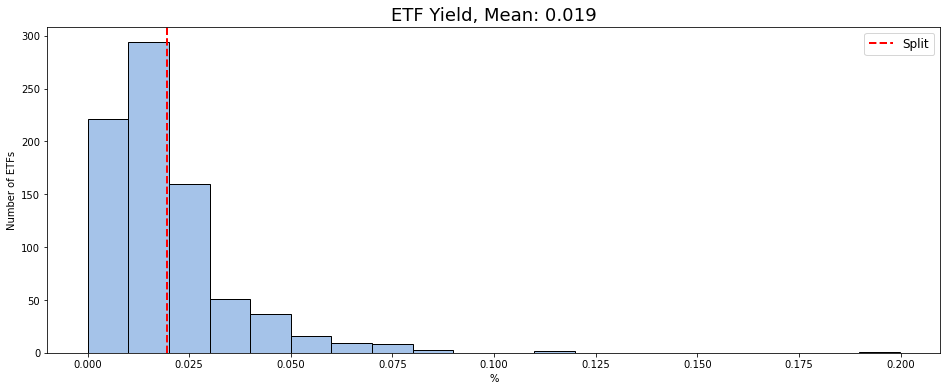

In [128]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_yield_etf['fund_yield'], bins=20, color='#87afe2')
mean = no_zero_yield_etf['fund_yield'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Yield, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The histogram for ETF yield shows a right-skewed distribution, with an average of 1.9% which is 0.2% higher than mutual funds.

In [129]:
no_zero_yield_etf['fund_yield'].groupby(no_zero_yield_etf['size_type']).describe()

count      mean       std     min      25%      50%       75%  \
size_type                                                                  
Large      388.0  0.017339  0.015958  0.0001  0.00930  0.01465  0.021750   
Medium     155.0  0.018910  0.015593  0.0002  0.00725  0.01580  0.024600   
None       170.0  0.025233  0.017588  0.0001  0.01480  0.02055  0.029825   
Small       89.0  0.018779  0.017446  0.0001  0.00740  0.01120  0.025300   

              max  
size_type          
Large      0.1997  
Medium     0.0775  
None       0.1157  
Small      0.0718

Interestingly, all of the fund sizes generate similar yield.

In [130]:
no_zero_yield_etf['fund_yield'].groupby(no_zero_yield_etf['investment_type']).describe()

count      mean       std     min       25%      50%  \
investment_type                                                         
Blend            282.0  0.013907  0.008377  0.0001  0.008825  0.01260   
Growth           112.0  0.011018  0.016367  0.0001  0.003350  0.00595   
None             170.0  0.025233  0.017588  0.0001  0.014800  0.02055   
Value            238.0  0.025942  0.019322  0.0006  0.014375  0.02090   

                      75%     max  
investment_type                    
Blend            0.018325  0.0517  
Growth           0.011450  0.1180  
None             0.029825  0.1157  
Value            0.033150  0.1997

Then in terms of investment type, ETFs are similar to the mutual funds where the `Value` equity generates the highest yield. The average yield for ETF `Value` portfolio is 2.6% which is 0.5% higher than mutual funds.

Overall, the more consistent yield generated by ETFs and slightly higher average could be enough to convince investors to switch over to ETF.

### Last dividend paid

Although ETF pays dividend, we only have data for the mutual funds:

In [131]:
no_zero_div = mutual_fund.copy()
no_zero_div = no_zero_div.drop(no_zero_div[no_zero_div['last_dividend'] == 0].index)

In [132]:
no_zero_div['last_dividend'].describe()

count    17068.000000
mean         0.118106
std          0.380293
min          0.000010
25%          0.018890
50%          0.044155
75%          0.132600
max         24.012800
Name: last_dividend, dtype: float64

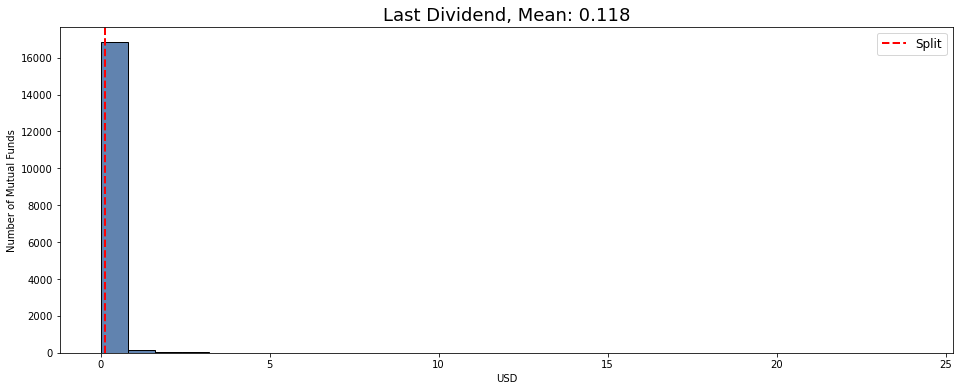

In [133]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_div['last_dividend'], bins=30, color='#2c5a94')
mean = no_zero_div['last_dividend'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('USD')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Last Dividend, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The distribution of mutual funds last dividend payout appears to be very right-skewed, with an average of USD0.19 per share.

In [134]:
no_zero_div['last_dividend'].groupby(no_zero_div['size_type']).describe()

count      mean       std      min       25%       50%      75%  \
size_type                                                                     
Large      9177.0  0.146911  0.459028  0.00001  0.029800  0.080110  0.17830   
Medium     4188.0  0.093025  0.242177  0.00001  0.013355  0.023205  0.07654   
None        861.0  0.124683  0.486867  0.00005  0.012760  0.026700  0.05936   
Small      2842.0  0.060059  0.151897  0.00001  0.018402  0.028280  0.04786   

                max  
size_type            
Large      24.01280  
Medium      4.71394  
None        5.68941  
Small       3.02940

Naturally the `Large` funds would have higher dividend payout as these are usually bigger and more established companies with higher investments to generate more payout.

In [135]:
no_zero_div['last_dividend'].groupby(no_zero_div['investment_type']).describe()

count      mean       std      min       25%      50%  \
investment_type                                                           
Blend            8372.0  0.135204  0.462614  0.00001  0.021360  0.05950   
Growth           1937.0  0.096449  0.208025  0.00001  0.018790  0.03650   
None              858.0  0.124917  0.487697  0.00005  0.012762  0.02670   
Value            5901.0  0.099966  0.255061  0.00001  0.016150  0.03537   

                      75%       max  
investment_type                      
Blend            0.158300  24.01280  
Growth           0.103600   3.15000  
None             0.059162   5.68941  
Value            0.110520  13.58260

Based on the investment type, `Blend` portfolio has a higher dividend payout. This is surprising as we'd expect the `Value` equity to have the most dividend payout based on the `fund_yield`.

### Stock valuation indicators

There are a few key financial ratios that are frequently used to evaluate a stock's value:
1. **Price-to-book (P/B) ratio**: This reflects the value that market participants attach to a company's equity relative to the book value of its equity. Many investors use the P/B ratio to find undervalued stocks.
2. **Price-to-cashflow (P/C)ratio**: This measures how much cash a company generates relative to its stock price, and has been said to be a better measure than price-to-earnings ratio because cash flows cannot be easily manipulated.
3. **Price-to-earnings (P/E) ratio**: This indicates how much investors pay for a share compared to the earnings a company generates per share. Companies with higher P/E ratio are more likely to be considered risky investment because the ratio also represents high expectations for a company's potential earnings growth.
4. **Price-to-sales (P/S) ratio**: This shows how much the market values every dollar of the company's sales. This ratio can be effective in valuing growth stocks that have yet to turn a profit or have suffered a temporary setback.

([source](https://www.investopedia.com/articles/fundamental-analysis/09/elements-stock-value.asp))

#### `MutualFunds.csv`

To help us better evaluate the funds' stock valuation performance, we'll first remove the rows with zero values.

In [136]:
# define share price columns

share_price = ['fund_price_book_ratio', 'fund_price_cashflow_ratio', 'fund_price_earning_ratio', 'fund_price_sales_ratio']

In [137]:
mf_share_price = mutual_fund.copy()
mf_share_price = mutual_fund[(mutual_fund[['fund_price_book_ratio', 'fund_price_cashflow_ratio', 'fund_price_earning_ratio', 'fund_price_sales_ratio']] !=0).all(axis=1)]

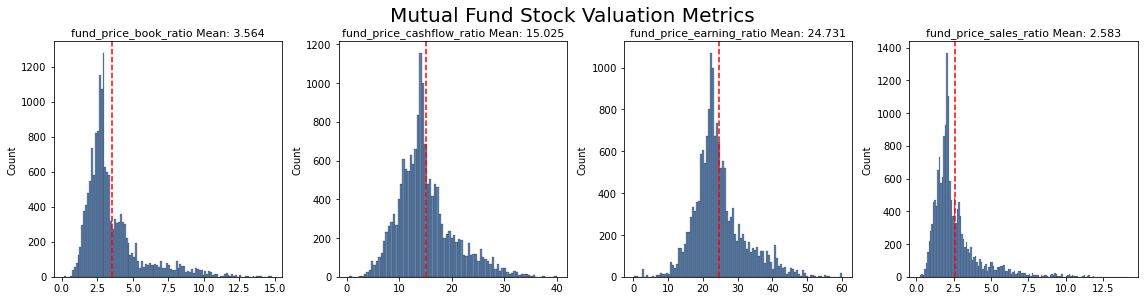

In [138]:
multi_histo(mf_share_price, share_price, 'Mutual Fund Stock Valuation Metrics', color='#2c5a94')

#### `ETFs.csv`

In [139]:
etf_share_price = etf.copy()
etf_share_price = etf[(etf[['fund_price_book_ratio', 'fund_price_cashflow_ratio', 'fund_price_earning_ratio', 'fund_price_sales_ratio']] !=0).all(axis=1)]

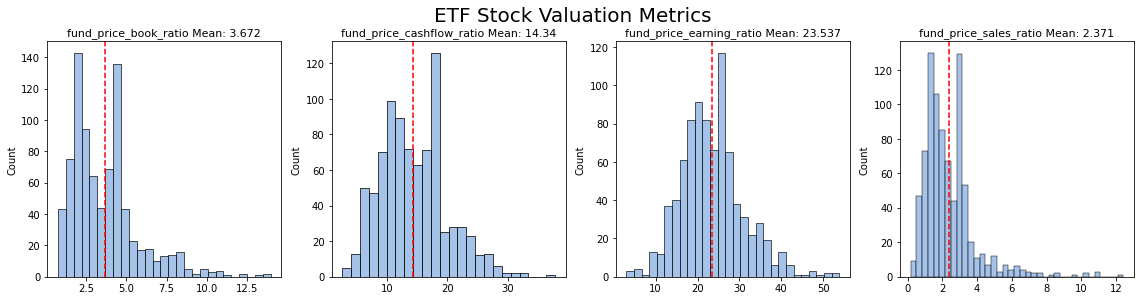

In [140]:
multi_histo(etf_share_price, share_price, 'ETF Stock Valuation Metrics', color='#87afe2')

At a glance, 
- Mutual funds have a slightly lower P/B ratio, indicating that there could be stock that is undervalued - meaning it could be a good investment. Typically any value under 1.0 is considered desirable for value investors, but many also consider P/B ratio less than 3. 
- Mutual funds have a slightly higher P/C ratio, which shows that stocks are earning more cash relative to its stock price. This shows that the earnings potential for mutual funds is good, but the securities in ETFs may be trading at a lower price (undervalued) than the market. This data is more normally distributed.
- The P/E ratio is the most scrutinized of all - we see that the values are quite close to each other but mutual funds is slightly higher. This helps us predict which portfolio is more likely to grow and generate favourable returns. This appears to be the most normally distributed histogram, which we will take a closer look.
- As for the P/S ratio, there's not much difference between mutual funds and ETFs. Typically lower P/S ratio helps make the investment more attractive - in this case, ETF may be slightly more favorable.

#### P/E ratio

In this section, we'll take a closer look at the price-to-earnings ratio (P/E) ratio:

###### `MutualFunds.csv`

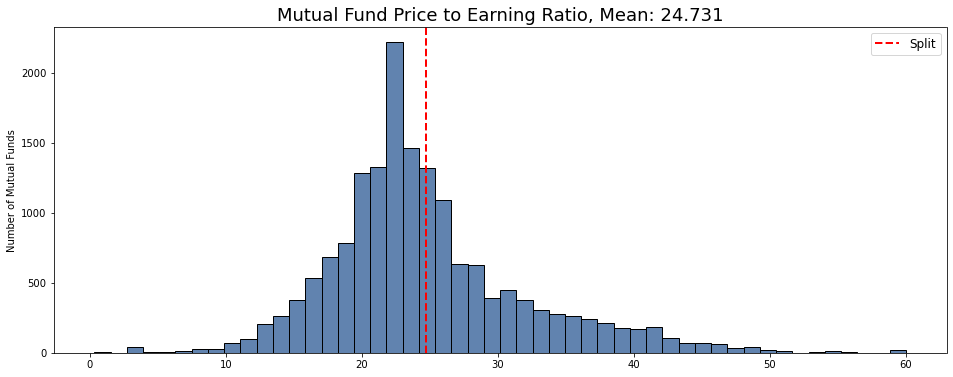

In [141]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(mf_share_price['fund_price_earning_ratio'], bins=50, color='#2c5a94')
mean = mf_share_price['fund_price_earning_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Price to Earning Ratio, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The distribution of P/E ratio is normally distributed with an average of 24.65. However we are seeing a much higher spike around the 21-22 ratio. 

In [142]:
mf_share_price['fund_price_earning_ratio'].groupby(mf_share_price['size_type']).describe()

count       mean       std   min    25%    50%      75%    max
size_type                                                                  
Large      12167.0  24.888695  6.496109  7.28  21.22  23.58  27.2300  59.99
Medium      2794.0  26.015555  9.370278  3.03  19.28  24.23  32.2875  59.99
Small       1670.0  21.437916  8.065090  0.33  16.44  20.19  26.1500  59.99

When we take a closer look at the P/E ratio based on the mutual fund size, we can see that:
- `Medium` sized funds have the highest average P/E ratio, and also the widest data spread based on standard deviation
- `Small` funds have the lowest average P/E ratio - but interestingly, all of the different sizes have the same maximum P/E ratio of 59.99

In [143]:
mf_share_price['fund_price_earning_ratio'].groupby(mf_share_price['investment_type']).describe()

count       mean       std    min     25%    50%      75%  \
investment_type                                                               
Blend            8680.0  23.602304  4.405178   8.34  21.430  23.08  25.4425   
Growth           4013.0  33.151931  6.803252  11.10  28.480  32.69  37.4300   
Value            3938.0  18.639622  4.895484   0.33  16.095  19.00  21.4000   

                   max  
investment_type         
Blend            57.77  
Growth           59.99  
Value            59.99

As for the `investment_type`, 
- `Growth` stocks have the highest average P/E ratio, as it's usually shares of companies that are expected to have high growth rates
- `Value` stocks have lowest average P/E ratio; which makes sense as value stocks are typically traded at a lower price compared to company's financial performance

In [144]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(mf_share_price['category_price_earning_ratio'], bins=50, color='#2c5a94')
mean = mf_share_price['category_price_earning_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Category Price to Earning Ratio, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

However, based on market exposure the distribution of price-to-earning ratio has spread out even further and is no longer normally distributed. 

In [145]:
mf_share_price['category_price_earning_ratio'].groupby(mf_share_price['size_type']).describe()

count       mean       std  min    25%    50%    75%    max
size_type                                                               
Large      12167.0  22.312503  7.512084  0.0  19.76  23.25  25.55  59.99
Medium      2794.0  25.258085  9.659298  0.0  20.83  23.53  34.65  59.99
Small       1670.0  24.171222  9.569509  0.0  20.39  21.45  36.31  59.99

In [146]:
mf_share_price['category_price_earning_ratio'].groupby(mf_share_price['investment_type']).describe()

count       mean        std  min    25%    50%    75%    max
investment_type                                                               
Blend            8680.0  22.792779   6.289086  0.0  20.83  23.25  25.42  59.99
Growth           4013.0  27.509564  10.369638  0.0  23.42  33.85  34.65  36.31
Value            3938.0  18.835970   7.079439  0.0  19.76  19.86  21.45  59.99

Similarly to the `fund_price_earning_ratio`, the category P/E ratio adjusted values remain the same:
- `Medium` sized funds have the highest average P/E ratio in the category
- `Growth` stocks have the highest average P/E ratio while `Value` stocks have the lowest average P/E ratio

Overall, P/E ratio is a crucial indicator of portfolio valuations and gives us a good idea on earnings potential. However, it cannot be considered in isolation and must be compared with category averages or industry average. 

###### `ETFs`

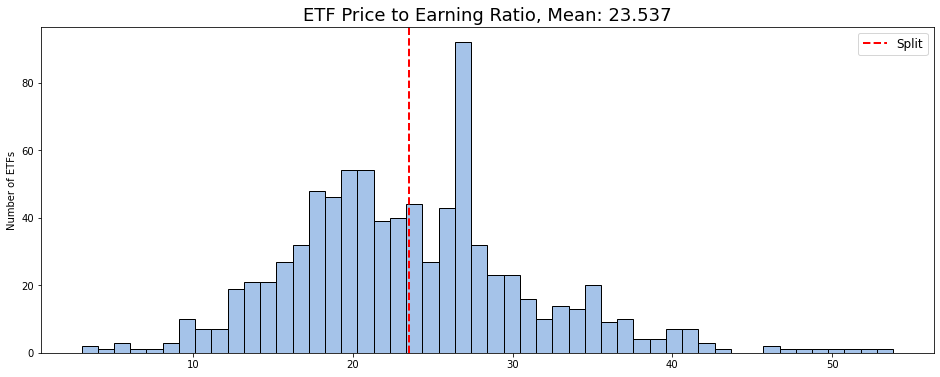

In [147]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(etf_share_price['fund_price_earning_ratio'], bins=50, color='#87afe2')
mean = etf_share_price['fund_price_earning_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Price to Earning Ratio, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

Overall, the distribution of P/E ratio for ETF appears to be quite normal with an average of 23.48, one point lower than the mutual fund P/E ratio average. We are seeing a slightly high spike around a ratio of 26-27, which is much higher than the mutual fund's high value. 

In [148]:
etf_share_price['fund_price_earning_ratio'].groupby(etf_share_price['size_type']).describe()

count       mean       std   min      25%    50%      75%    max
size_type                                                                  
Large      582.0  24.619605  6.853337  5.69  19.8125  24.74  27.5725  53.82
Medium     189.0  22.411534  8.730457  3.03  16.4200  21.05  28.1100  52.03
Small       76.0  18.049079  5.986714  4.56  15.0550  17.69  20.5050  43.61

When we take a closer look at the P/E ratio based on the ETF size, we can see that:
- `Large` sized funds have the highest average P/E ratio, but `Medium` sized funds have the widest data spread based on standard deviation
- `Small` funds have the lowest average P/E ratio

In [149]:
etf_share_price['fund_price_earning_ratio'].groupby(etf_share_price['investment_type']).describe()

count       mean       std    min     25%    50%    75%  \
investment_type                                                            
Blend            427.0  23.464286  5.018529  10.69  19.995  24.01  26.46   
Growth           181.0  31.961657  6.760186  13.81  28.210  32.00  35.75   
Value            239.0  17.287908  5.177329   3.03  14.055  17.77  20.29   

                   max  
investment_type         
Blend            47.73  
Growth           53.82  
Value            52.03

As for the `investment_type`, similar to mutual funds:
- `Growth` stocks have the highest average P/E ratio in ETF
- `Value` stocks have lowest average P/E ratio

### Investment risk ratios

Next, we'll look at the popular technical investment risk ratios: alpha, beta, standard deviation, R-squared, the Sharpe ratio and the Treynor ratios:

#### Alpha

Alpha refers to the investment's strategy to beat the market, which is also often referred to as "excess return" or "abnormal rate of return". This means that a positive alpha is desirable, as it means the investment strategy was able to outperform the market. Meanwhile an alpha of 0 is tracking well against the benchmark. ([source](https://www.investopedia.com/terms/a/alpha.asp))

Based on multiple studies done using alpha as a target variable, we'll likely be using this as a target in our modeling. 

##### `MutualFunds.csv`

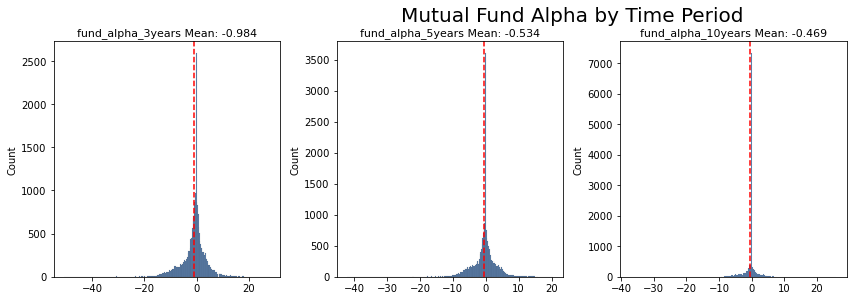

In [150]:
alpha = ['fund_alpha_3years', 'fund_alpha_5years', 'fund_alpha_10years']
multi_histo(mutual_fund, alpha, 'Mutual Fund Alpha by Time Period', color='#2c5a94')

##### `ETFs.csv`

In [151]:
multi_histo(etf, alpha, 'ETF Alpha by Time Period', color='#87afe2')

At a glance, 
- All of the average alpha values are negative, indicating that these portfolio were not able to outperform the market
- However, the overall alpha values for mutual funds is slightly higher than ETFs, especially in the shorter run - likely because the fund managers were able to make better prediction and judgment calls that worked well for a while
- Unfortunately, the market does stabilize after a few years and we can see that the 10-year alpha for both does not differ too much

Let's take a closer look at the summary statistics:

In [152]:
mutual_fund['fund_alpha_3years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min     25%   50%   75%    max
size_type                                                               
Large      13185.0 -0.408863  4.400171 -50.73 -2.3200 -0.28  1.12  23.65
Medium      5533.0 -1.446721  5.157324 -46.52 -2.3500 -0.43  0.59  24.39
None         981.0 -0.180459  4.279973 -34.48 -0.3900  0.00  1.24  13.93
Small       3868.0 -2.485496  6.260528 -48.22 -7.3725 -0.10  1.69  28.14

In [153]:
etf['fund_alpha_3years'].groupby(etf['size_type']).describe()

count      mean        std    min    25%  50%    75%    max
size_type                                                             
Large      622.0 -0.401190   4.724111 -42.95 -1.025  0.0  0.000  23.94
Medium     230.0 -2.463304   6.734014 -34.74 -5.090  0.0  0.000  25.99
None       330.0 -0.658333  10.653636 -74.58  0.000  0.0  0.755  77.02
Small      121.0 -4.147107   7.741852 -46.72 -7.830  0.0  0.000  23.11

In [154]:
mutual_fund['fund_alpha_3years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min    25%   50%   75%    max
investment_type                                                              
Blend            10865.0 -1.326034  3.490913 -48.22 -2.300 -0.70  0.15  18.63
Growth            4925.0  2.561009  4.733168 -21.38 -0.060  2.15  5.00  28.14
None               977.0 -0.190502  4.285785 -34.48 -0.390  0.00  1.22  13.93
Value             6800.0 -3.118528  5.834201 -50.73 -6.315 -0.97  0.65   9.60

In [155]:
etf['fund_alpha_3years'].groupby(etf['investment_type']).describe()

count      mean        std    min     25%    50%    75%  \
investment_type                                                            
Blend            460.0 -0.978217   4.855247 -42.95 -0.8500  0.000  0.000   
Growth           233.0  1.447682   5.048635 -20.98  0.0000  0.000  1.040   
None             330.0 -0.658333  10.653636 -74.58  0.0000  0.000  0.755   
Value            280.0 -4.304393   6.602562 -46.72 -6.7425 -2.525  0.000   

                   max  
investment_type         
Blend            23.94  
Growth           25.99  
None             77.02  
Value             6.10

Based on the `fund_alpha_3years`, 
- The `Large` funds across both mutual funds and ETFs generated alphas closest to zero, in other words, they performed closer to the benchmark compared to the other fund sizes
- `Growth` equities generated positive alphas, which makes sense considering they are focused on fast-growing companies
- `Value` portfolio had the smallest alpha, underperforming most in the market. This makes sense considering that they were already underpriced in the first place
- Unfortunately, `Blend` portfolio still underperformed in the market though suffered less loss compared to `Value`

In [156]:
mutual_fund['fund_alpha_5years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min   25%   50%     75%    max
size_type                                                               
Large      13185.0 -0.243808  3.608592 -40.50 -1.64 -0.13  0.7200  18.37
Medium      5533.0 -1.204446  4.275114 -34.47 -2.09 -0.20  0.5300  20.46
None         981.0  0.009796  3.758286 -31.88 -0.31  0.00  1.1800   8.91
Small       3868.0 -0.701399  4.999002 -42.16 -4.17  0.31  2.5625  16.66

In [157]:
etf['fund_alpha_5years'].groupby(etf['size_type']).describe()

count      mean       std    min    25%  50%  75%    max
size_type                                                          
Large      622.0 -0.109180  3.494922 -30.22  0.000  0.0  0.0  25.68
Medium     230.0 -1.786652  6.098719 -51.28 -2.825  0.0  0.0  19.74
None       330.0 -1.008242  8.975290 -96.15  0.000  0.0  0.0  54.81
Small      121.0 -2.136942  4.827611 -25.25 -3.780  0.0  0.0   6.54

In [158]:
mutual_fund['fund_alpha_5years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min   25%   50%     75%    max
investment_type                                                               
Blend            10865.0 -0.944613  2.579543 -42.16 -1.62 -0.38  0.0500  12.84
Growth            4925.0  2.513133  3.907546 -17.58  0.00  1.80  4.4300  20.46
None               977.0  0.007155  3.765514 -31.88 -0.32  0.00  1.1700   8.91
Value             6800.0 -2.162229  4.852207 -40.50 -4.98 -0.74  0.5725   7.84

In [159]:
etf['fund_alpha_5years'].groupby(etf['investment_type']).describe()

count      mean       std    min   25%  50%  75%    max
investment_type                                                         
Blend            460.0 -0.726348  3.632275 -51.28  0.00  0.0  0.0   7.22
Growth           233.0  1.339914  4.523392 -17.68  0.00  0.0  0.0  25.68
None             330.0 -1.008242  8.975290 -96.15  0.00  0.0  0.0  54.81
Value            280.0 -2.555321  4.973584 -34.37 -4.49  0.0  0.0   5.89

The `fund_alpha_5years` showed similar trends as the `fund_alpha_3years` - signaling that 3- and 5-years are not far apart enough to generate significant differences. So we'll likely drop the 5-year columns prior to modeling.

In [160]:
mutual_fund['fund_alpha_10years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min     25%  50%   75%    max
size_type                                                              
Large      13185.0 -0.255427  2.535124 -37.20 -0.9700  0.0  0.21  11.80
Medium      5533.0 -0.643635  2.697139 -20.42 -1.0300  0.0  0.21  10.89
None         981.0 -0.130234  2.989325 -22.06 -0.1800  0.0  0.00  25.92
Small       3868.0 -1.030737  3.597208 -29.04 -3.5025  0.0  0.88  10.16

In [161]:
etf['fund_alpha_10years'].groupby(etf['size_type']).describe()

count      mean       std    min  25%  50%  75%    max
size_type                                                        
Large      622.0 -0.247428  3.156003 -53.29  0.0  0.0  0.0   9.35
Medium     230.0 -0.613304  3.034919 -20.70  0.0  0.0  0.0   6.99
None       330.0 -0.396333  5.694300 -70.59  0.0  0.0  0.0  38.20
Small      121.0 -1.005868  2.972532 -18.94  0.0  0.0  0.0   7.95

In [162]:
mutual_fund['fund_alpha_10years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min   25%  50%   75%    max
investment_type                                                            
Blend            10865.0 -0.597433  2.114110 -29.04 -1.04  0.0  0.00   9.65
Growth            4925.0  0.661425  2.833995 -17.70 -0.35  0.0  1.75  11.80
None               977.0 -0.130768  2.995432 -22.06 -0.18  0.0  0.00  25.92
Value             6800.0 -1.129756  3.418620 -37.20 -2.57  0.0  0.24   7.52

In [163]:
etf['fund_alpha_10years'].groupby(etf['investment_type']).describe()

count      mean       std    min  25%  50%  75%    max
investment_type                                                        
Blend            460.0 -0.460174  3.760169 -53.29  0.0  0.0  0.0   7.95
Growth           233.0  0.034378  1.921031 -20.70  0.0  0.0  0.0   9.35
None             330.0 -0.396333  5.694300 -70.59  0.0  0.0  0.0  38.20
Value            280.0 -0.760714  2.674950 -15.75  0.0  0.0  0.0   6.99

The `fund_alpha_10years` also showed similar trends as the `fund_alpha_5years` and `fund_alpha_3years` - except that the alpha values across the board are closer to each other. Alpha values over time would stabilize and the differences would even out - hence it would be quite difficult to predict for 10 years. 

Therefore, we will most likely refer only to the 3-year alpha values in the modeling section. 

#### Beta

Beta is a measured of volatility or systematic risk of a portfolio compared to the market, usually S&P 500 (their beta is 1.0). For instance, when beta of a stock is more than 1, we can say that the stock is more volatile than the S&P 500. When beta is less than 1, it means that the security is less volatile than the market and it's less risky.

Investors typically use the beta value to understand if the funds or stocks are moving in the same direction as the rest of the market and how risky an investment would be. ([source](https://www.investopedia.com/terms/b/beta.asp))

##### `MutualFunds.csv`

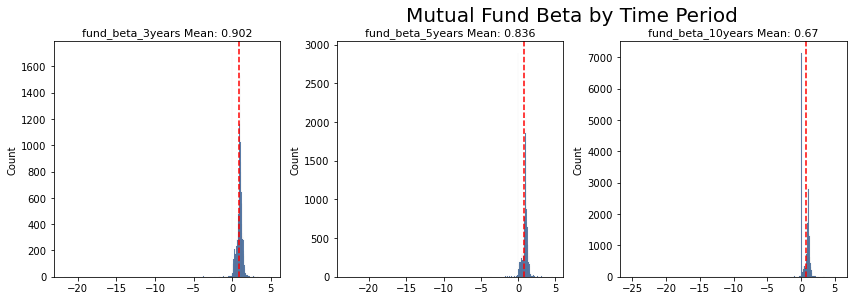

In [164]:
beta = ['fund_beta_3years', 'fund_beta_5years', 'fund_beta_10years']
multi_histo(mutual_fund, beta, 'Mutual Fund Beta by Time Period', color='#2c5a94')

##### `ETFs.csv`

In [165]:
multi_histo(etf, beta, 'ETF Beta by Time Period', color='#87afe2')

At a glance, mutual funds have a higher average beta value compared to ETFs. This means that the mutual fund portfolio is more volatile and is moving much more closely with the market - not unexpected as most active fund managers aim to outperform the market and would tend to take riskier approach. ETF portfolios are usually adjusted based on the market and aim to keep track. 

Here we also see that the beta values decrease over the years but certainly highest in the short term. We can take a look a closer look at the summary statistics:

In [166]:
mutual_fund['fund_beta_3years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min   25%   50%   75%   max
size_type                                                            
Large      13185.0  0.915746  0.426558  -3.79  0.80  0.99  1.10  4.75
Medium      5533.0  0.928270  0.431668  -0.83  0.72  1.02  1.16  2.98
None         981.0  0.413089  1.296877 -21.80  0.00  0.46  0.96  4.91
Small       3868.0  0.940005  0.478088  -0.56  0.56  1.10  1.27  2.85

In [167]:
etf['fund_beta_3years'].groupby(etf['size_type']).describe()

count      mean       std    min  25%   50%     75%   max
size_type                                                           
Large      622.0  0.526093  0.567666   0.00  0.0  0.50  1.0000  3.42
Medium     230.0  0.725609  0.728751  -0.62  0.0  0.91  1.1875  4.06
None       330.0  0.079121  2.437002 -26.86  0.0  0.00  0.7350  5.30
Small      121.0  0.825868  0.809366   0.00  0.0  1.02  1.2900  4.23

In [168]:
mutual_fund['fund_beta_3years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min   25%   50%   75%   max
investment_type                                                            
Blend            10865.0  0.945278  0.433984  -3.79  0.81  1.00  1.18  4.75
Growth            4925.0  0.997553  0.399963  -0.05  0.94  1.03  1.15  4.68
None               977.0  0.414084  1.299434 -21.80  0.00  0.48  0.96  4.91
Value             6800.0  0.832860  0.453115  -0.56  0.48  0.90  1.13  2.91

In [169]:
etf['fund_beta_3years'].groupby(etf['investment_type']).describe()

count      mean       std    min  25%    50%     75%   max
investment_type                                                            
Blend            460.0  0.531957  0.622044  -0.62  0.0  0.140  1.0100  4.23
Growth           233.0  0.492446  0.631613   0.00  0.0  0.000  1.0400  3.42
None             330.0  0.079121  2.437002 -26.86  0.0  0.000  0.7350  5.30
Value            280.0  0.837893  0.663189   0.00  0.0  0.985  1.2025  4.06

Based on the `fund_beta_3years`, 
- All of the mutual funds have very similar beta values, nearing 1 - where they are tracking as closely with the market as possible
- The only exception within mutual funds is the `Value` stocks, that are lowest across the various investment types - we would imagine this to make sense as these stocks are already traded at lower-than-market prices so there's less risk for the investors 
- Meanwhile amongst ETFs, the `Small` fuds have the highest beta value as it is likely to be more risky; this type of fund is usually perceived to be more aggressive and niche in their strategy 
- Interestingly, `Value` based ETFs have the highest beta across the other investment types, the average beta is close to that of mutual funds 
- Knowing that ETFs tend to keep track of the market performance, we can say that the active fund managers are probably more focused on outperforming the market through `Blend` and `Growth` portfolio but is on part with market when it comes to `Value` stocks

In [170]:
mutual_fund['fund_beta_5years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min   25%   50%   75%   max
size_type                                                            
Large      13185.0  0.856405  0.455625  -3.66  0.73  0.98  1.08  4.55
Medium      5533.0  0.851914  0.444989  -0.81  0.57  0.98  1.12  2.81
None         981.0  0.336809  1.316679 -22.93  0.00  0.32  0.92  4.69
Small       3868.0  0.868560  0.491738  -0.59  0.44  1.05  1.24  2.65

In [171]:
etf['fund_beta_5years'].groupby(etf['size_type']).describe()

count      mean       std    min  25%  50%     75%    max
size_type                                                           
Large      622.0  0.368698  0.538182   0.00  0.0  0.0  0.9200   3.39
Medium     230.0  0.560870  0.701948  -0.60  0.0  0.0  1.1000   4.04
None       330.0  0.124970  3.279429 -23.33  0.0  0.0  0.3375  43.73
Small      121.0  0.601901  0.821834   0.00  0.0  0.0  1.2400   4.13

In [172]:
mutual_fund['fund_beta_5years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min   25%   50%   75%   max
investment_type                                                            
Blend            10865.0  0.871227  0.464675  -3.66  0.74  0.99  1.13  4.55
Growth            4925.0  0.933527  0.424811   0.00  0.92  1.02  1.12  4.49
None               977.0  0.337769  1.319273 -22.93  0.00  0.33  0.92  4.69
Value             6800.0  0.779682  0.464082  -0.59  0.41  0.87  1.11  2.75

In [173]:
etf['fund_beta_5years'].groupby(etf['investment_type']).describe()

count      mean       std    min  25%   50%     75%    max
investment_type                                                            
Blend            460.0  0.368739  0.578180  -0.60  0.0  0.00  0.9100   4.13
Growth           233.0  0.381116  0.598446   0.00  0.0  0.00  0.9500   3.39
None             330.0  0.124970  3.279429 -23.33  0.0  0.00  0.3375  43.73
Value            280.0  0.616929  0.695629   0.00  0.0  0.56  1.1100   4.04

Although the `fund_beta_5years` figures are lower than the `fund_beta_3years`, the trends are largely similar and there are not many significant differences. So we'll probably drop this column.

In [174]:
mutual_fund['fund_beta_10years'].groupby(mutual_fund['size_type']).describe()

count      mean       std    min  25%   50%     75%   max
size_type                                                             
Large      13185.0  0.683439  0.541464  -3.97  0.0  0.93  1.0500  5.12
Medium      5533.0  0.712360  0.494410  -0.84  0.1  0.91  1.0900  2.92
None         981.0  0.209562  1.411289 -25.34  0.0  0.00  0.7800  5.21
Small       3868.0  0.680964  0.554918  -0.19  0.0  0.85  1.2025  2.67

In [175]:
etf['fund_beta_10years'].groupby(etf['size_type']).describe()

count      mean       std    min  25%  50%   75%   max
size_type                                                        
Large      622.0  0.183666  0.466310   0.00  0.0  0.0  0.00  3.47
Medium     230.0  0.267000  0.508271  -0.01  0.0  0.0  0.00  2.43
None       330.0 -0.217061  4.982539 -88.80  0.0  0.0  0.00  5.53
Small      121.0  0.350083  0.677828   0.00  0.0  0.0  0.51  3.70

In [176]:
mutual_fund['fund_beta_10years'].groupby(mutual_fund['investment_type']).describe()

count      mean       std    min  25%   50%   75%   max
investment_type                                                           
Blend            10865.0  0.699533  0.548676  -3.97  0.0  0.93  1.08  4.84
Growth            4925.0  0.793624  0.517343   0.00  0.0  1.01  1.11  5.12
None               977.0  0.210420  1.414114 -25.34  0.0  0.00  0.78  5.21
Value             6800.0  0.599643  0.502396  -0.42  0.0  0.60  1.04  2.80

In [177]:
etf['fund_beta_10years'].groupby(etf['investment_type']).describe()

count      mean       std    min  25%  50%  75%   max
investment_type                                                       
Blend            460.0  0.211543  0.514499   0.00  0.0  0.0  0.0  3.70
Growth           233.0  0.193820  0.487586   0.00  0.0  0.0  0.0  3.36
None             330.0 -0.217061  4.982539 -88.80  0.0  0.0  0.0  5.53
Value            280.0  0.269786  0.519028  -0.01  0.0  0.0  0.0  3.47

The `fund_beta_10years` is a little more interesting,
- The `Medium` sized mutual funds have a higher beta than the other actively managed funds, but `Small` ETFs have the highest beta amongst the other ETFs
- `Growth` focused mutual funds naturally have the highest beta over time
- `Value` focused ETFs are more volatile compared to the rest of the investment types in ETFs

Similarly to the alpha values, it's difficult to predict 10-year values as the market and investors' attitude will change over time. Hence, we'll focus on 3-year beta values.

#### R-Squared

In statistics and math, R-squared indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model. But when it comes to investing, R-squared is generally interpreted as the percentage of a fund or security's movements that can be explained by movements in a benchmark index. 

High R-squared means that the fund's performance is moving relatively in line with the market. This tends to be correlated to beta, so we'll not dive too deep into this section. ([source](https://www.investopedia.com/terms/r/r-squared.asp))

##### `MutualFunds.csv`

In [178]:
r_sq = ['fund_r_squared_3years', 'fund_r_squared_5years', 'fund_r_squared_10years']
multi_histo(mutual_fund, r_sq, 'Mutual Fund R-Squared by Time Period', color='#2c5a94')

##### `ETFs.csv`

In [179]:
multi_histo(etf, r_sq, 'ETF R-Squared by Time Period', color='#87afe2')

At a glance, 
- Mutual funds have a higher R-squared values or percentage of movements that can be explained by changes in the market as compared to ETF; this is also in-line with mutual funds' beta values vs. ETFs' beta values
- Typically R-squared value should ideally be above 70% to be considered good - so the values above does not tell us very good news about our funds, and we may not be able to use this feature in our modeling process

#### Standard deviation

In statistics, standard deviation measures the dispersion of a dataset relative to its mean. But in investment, it is often used as a measure of relative riskiness of an asset. This means that high standard deviation indicates that the stock is more volatile. Index funds or ETFs are more likely to have low standard deviation since the goal is to replicate the index. ([source](https://www.investopedia.com/terms/s/standarddeviation.asp))

##### `MutualFunds.csv`

In [180]:
stdev = ['fund_stdev_3years', 'fund_stdev_5years', 'fund_stdev_10years']
multi_histo(mutual_fund, stdev, 'Mutual Fund Standard Deviation by Time Period', color='#2c5a94')

##### `ETFs.csv`

In [181]:
multi_histo(etf, stdev, 'ETF Standard Deviation by Time Period', color='#87afe2')

As expected, the standard deviation for mutual funds are much higher compared to ETFs - as fund managers tend to make more aggressive bets to generate higher than average returns. We won't be use standard deviation in the modeling process.

#### Sharpe ratio

Sharpe ratio is a measure of an investment's risk-adjusted performance, calculated by comparing its return to that of a risk-free asset. One of the benefits of using the Sharpe ratio is that it helps explain whether an excess returns are based on smart investment decisions or simply luck and risk.

The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance. A negative Sharpe ratio means the risk-free or benchmark rate is greater than the portfolio’s historical or projected return, or else the portfolio's return is expected to be negative. 

A good Sharpe ratio is usually above 1, offering excess returns relative to volatility - however this is also dependent on the market. 

([source](https://www.investopedia.com/terms/s/sharperatio.asp))

##### `MutualFunds.csv`

In [182]:
sharpe = ['fund_sharpe_ratio_3years', 'fund_sharpe_ratio_5years', 'fund_sharpe_ratio_10years']
multi_histo(mutual_fund, sharpe, 'Mutual Fund Sharpe Ratio by Time Period', color='#2c5a94')

##### `ETFs.csv`

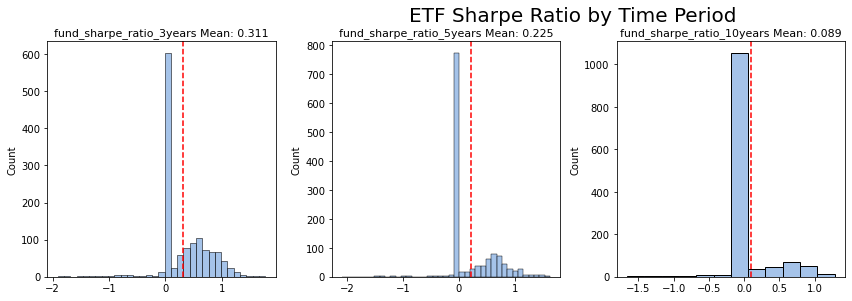

In [183]:
multi_histo(etf, sharpe, 'ETF Sharpe Ratio by Time Period', color='#87afe2')

At a glance,
- There's a noticeable amount of zero values, so we may not be able to interpret this Sharpe ratio as accurately as possible
- However, in-line with the other risk ratios, mutual funds have a higher Sharpe ratio than ETFs - making it a much attractive option for investors seeking to diversify and outperform the market with higher risk stocks
- Unfortunately, this ratio is much more easily manipulated by lengthening measurement intervals or selecting only favorable stretch of performance ([source](https://www.investopedia.com/terms/s/sharperatio.asp))

#### Treynor ratio

Another variation to Sharpe ratio is the Treynor ratio, which is also known as the reward-to-volatility ratio. The Treynor ratio is a measure that allows investors to adjust a portfolio's returns for systematic risk, i.e. changes in the market. 

While higher Treynor ratio indicates a better investment, the ratio relies on the portfolio's beta - sensitivity of returns to market movements - to assess risk. ([source](https://www.investopedia.com/terms/t/treynorratio.asp))

##### `MutualFunds.csv`

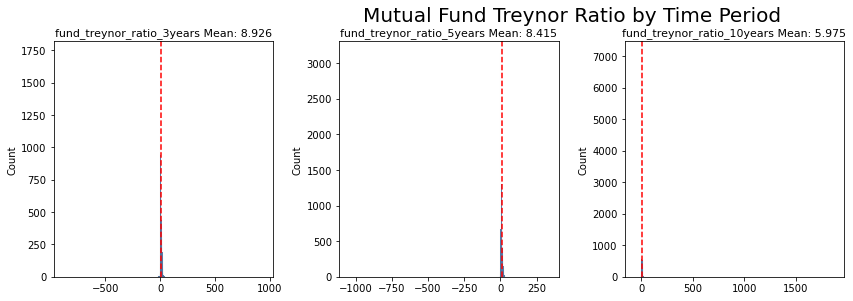

In [184]:
treynor = ['fund_treynor_ratio_3years', 'fund_treynor_ratio_5years', 'fund_treynor_ratio_10years']
multi_histo(mutual_fund, treynor, 'Mutual Fund Treynor Ratio by Time Period', color='#2c5a94')

##### `ETFs.csv`

In [185]:
multi_histo(etf, treynor, 'ETF Treynor Ratio by Time Period', color='#87afe2')

Based the other risk ratios, mutual funds' Treynor ratio would naturally be higher than the ETFs. But unfortunately, there's not much information available and we won't be able to analyze the column further.

### Annual holdings turnover

The annual turnover refers to how many times an asset, security, or payment changed hands over a year-long period. High turnover rates is not a reliable indicator of fund quality or performance. It is simply for investment managers and investors to better understand the activity within a portfolio. ([source](https://www.investopedia.com/terms/a/annual-turnover.asp))

#### `MutualFunds.csv`

First, we'll remove the zero values first before visualization.

In [186]:
no_zero_holdings = mutual_fund.copy()
no_zero_holdings = no_zero_holdings.drop(no_zero_holdings[no_zero_holdings['annual_holdings_turnover'] == 0].index)

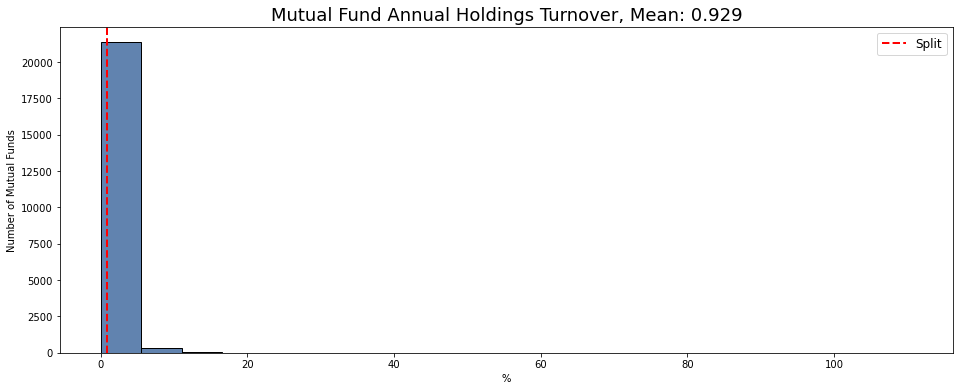

In [187]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_holdings['annual_holdings_turnover'], bins=20, color='#2c5a94')
mean = no_zero_holdings['annual_holdings_turnover'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Annual Holdings Turnover, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The average mutual fund annual holdings turnover is 92.9% for its assets. This also acts as a future projection of an investment turnover within a one-year period.

In [188]:
no_zero_holdings['annual_holdings_turnover'].groupby(no_zero_holdings['investment_type']).describe()

count      mean       std     min   25%   50%   75%     max
investment_type                                                               
Blend            10071.0  0.874826  1.863207  0.0100  0.23  0.45  0.87   55.82
Growth            4572.0  0.678976  0.933113  0.0042  0.28  0.47  0.84   27.04
None               731.0  2.480549  7.839281  0.0300  0.40  0.80  1.86  110.66
Value             6411.0  1.017154  1.448732  0.0100  0.36  0.63  1.03   15.49

In [189]:
no_zero_holdings['annual_holdings_turnover'].groupby(no_zero_holdings['size_type']).describe()

count      mean       std     min    25%   50%   75%     max
size_type                                                                
Large      12272.0  0.791682  1.688951  0.0100  0.242  0.44  0.81   55.82
Medium      5157.0  0.934386  1.331453  0.0042  0.260  0.54  1.00   27.04
None         735.0  2.476165  7.818310  0.0300  0.400  0.80  1.87  110.66
Small       3621.0  1.075609  1.514124  0.0100  0.430  0.71  1.12   17.85

When we look closely at the mutual fund turnover rates,
- `Value` focused mutual funds saw the highest turnover rates; likely because fund managers are actively moving assets and securities of the underpriced shares
- `Small` sized mutual funds also saw highest turnover rates - which makes sense as it usually adopts a more aggressive investing approach and would naturally be trading more often

#### `ETFs`

In [190]:
no_zero_holdings_etf = etf.copy()
no_zero_holdings_etf = no_zero_holdings_etf.drop(no_zero_holdings_etf[no_zero_holdings_etf['annual_holdings_turnover'] == 0].index)

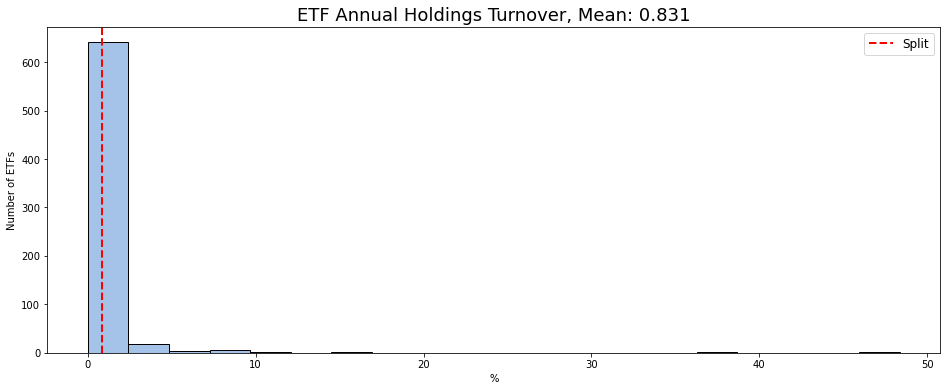

In [191]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_holdings_etf['annual_holdings_turnover'], bins=20, color='#87afe2')
mean = no_zero_holdings_etf['annual_holdings_turnover'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Annual Holdings Turnover, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

Meanwhile, ETFs have an average annual holdings turnover of 83.1%. While these funds are not actively managed, but they've been programmed to re-adjust based on market performance.

In [192]:
no_zero_holdings_etf['annual_holdings_turnover'].groupby(no_zero_holdings_etf['investment_type']).describe()

count      mean       std   min    25%   50%     75%    max
investment_type                                                             
Blend            243.0  0.978087  3.050597  0.01  0.100  0.26  0.5856  37.42
Growth           111.0  0.619808  0.638901  0.02  0.220  0.40  0.8350   3.84
None             139.0  0.578690  0.703492  0.01  0.155  0.36  0.6800   4.34
Value            180.0  0.957173  3.706858  0.04  0.210  0.38  0.8300  48.35

In [193]:
no_zero_holdings_etf['annual_holdings_turnover'].groupby(no_zero_holdings_etf['size_type']).describe()

count      mean       std   min     25%    50%     75%    max
size_type                                                               
Large      338.0  0.915039  3.568347  0.01  0.1200  0.270  0.6275  48.35
Medium     124.0  0.872865  1.745925  0.02  0.2275  0.380  0.9625  16.37
None       139.0  0.578690  0.703492  0.01  0.1550  0.360  0.6800   4.34
Small       72.0  0.850649  1.192945  0.05  0.3325  0.515  0.8450   8.94

When we zoom in on the ETF annual holdings turnover,
- `Blend` and `Value` portfolio have the highest turnover rates because they are constantly adjusting to look for the best market rates and searching for undervalued stocks
- Interestingly, `Large` ETF has the highest turnover rates while `Small` has the lowest rates

### Operating expenses

One of the main reasons why investors are shifting away from actively managed funds to ETFs and index funds is the operating expenses. Oftentimes, funds charge operating expenses on an annual basis based on the value of the assets. 

For an actively managed portfolio, a reasonable expense ratio is anywhere between 0.5% and 0.75%. A ratio greater than 1.5% is considered high.

Meanwhile for passively managed funds, the typical ratio is about 0.2% as the funds have been designed to replicate the return on a specific market index.

([source](https://www.investopedia.com/ask/answers/032715/when-expense-ratio-considered-high-and-when-it-considered-low.asp))

#### `MutualFunds.csv`

In [194]:
mf_ops_expenses = ['fund_annual_report_net_expense_ratio', 'category_annual_report_net_expense_ratio', 'fund_prospectus_net_expense_ratio', 'fund_prospectus_gross_expense_ratio', 'fund_year3_expense_projection', 'fund_year5_expense_projection', 'fund_year10_expense_projection']
multi_histo(mutual_fund, mf_ops_expenses, 'Mutual Fund Operating Expenses', color='#2c5a94')

Seeing there's quite a number of empty columns, we'll zoom in on the first two expense ratios:

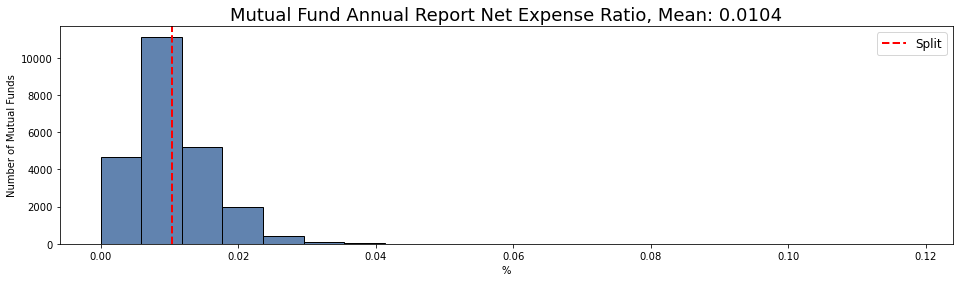

In [195]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
sns.histplot(mutual_fund['fund_annual_report_net_expense_ratio'], bins=20, color='#2c5a94')
mean = mutual_fund['fund_annual_report_net_expense_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Annual Report Net Expense Ratio, Mean: {round(mean, 4)}', fontsize=18)
plt.show()

The net expense ratio distribution is right-skewed, with an average annual net expense ratio of 1.04%.

In [196]:
mutual_fund['fund_annual_report_net_expense_ratio'].groupby(mutual_fund['size_type']).describe()

count      mean       std  min     25%     50%     75%     max
size_type                                                                  
Large      13185.0  0.010118  0.005557  0.0  0.0065  0.0093  0.0129  0.0869
Medium      5533.0  0.010381  0.005925  0.0  0.0061  0.0091  0.0137  0.0423
None         981.0  0.011245  0.007590  0.0  0.0062  0.0092  0.0155  0.0616
Small       3868.0  0.011030  0.006085  0.0  0.0074  0.0100  0.0136  0.1180

In [197]:
mutual_fund['fund_annual_report_net_expense_ratio'].groupby(mutual_fund['investment_type']).describe()

count      mean       std  min     25%     50%     75%  \
investment_type                                                             
Blend            10865.0  0.009786  0.005568  0.0  0.0059  0.0089  0.0128   
Growth            4925.0  0.011409  0.005695  0.0  0.0079  0.0105  0.0140   
None               977.0  0.011214  0.007583  0.0  0.0061  0.0092  0.0155   
Value             6800.0  0.010453  0.005965  0.0  0.0066  0.0094  0.0132   

                    max  
investment_type          
Blend            0.0497  
Growth           0.1180  
None             0.0616  
Value            0.1142

When we look at the breakdown of `fund_annual_report_net_expense_ratio`,
- For all mutual fund sizes, the expense ratio is similar but is noticeable higher for `Small` sized funds as it would require more active involvement to seek out undervalued stocks
- `Growth` focused mutual funds also incur the highest expenses compared to the other investment types, likely because fund managers need to actively track the growth and earnings potential

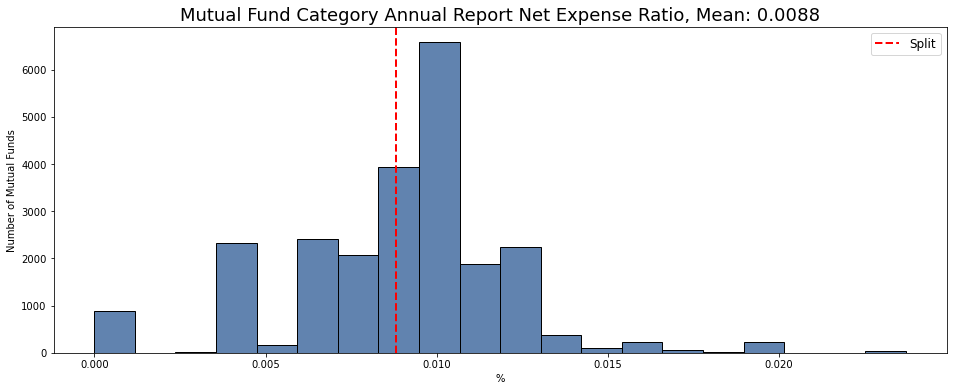

In [198]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(mutual_fund['category_annual_report_net_expense_ratio'], bins=20, color='#2c5a94')
mean = mutual_fund['category_annual_report_net_expense_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund Category Annual Report Net Expense Ratio, Mean: {round(mean, 4)}', fontsize=18)
plt.show()

When we adjust the values after exposure to the market, the average annual expense ratio is 0.88% which is much lower.

In [199]:
mutual_fund['category_annual_report_net_expense_ratio'].groupby(mutual_fund['size_type']).describe()

count      mean       std  min     25%     50%     75%     max
size_type                                                                  
Large      13185.0  0.008187  0.003428  0.0  0.0064  0.0084  0.0099  0.0237
Medium      5533.0  0.009446  0.002822  0.0  0.0072  0.0095  0.0109  0.0237
None         981.0  0.008489  0.003900  0.0  0.0069  0.0084  0.0110  0.0237
Small       3868.0  0.010186  0.001845  0.0  0.0095  0.0103  0.0116  0.0237

In [200]:
mutual_fund['category_annual_report_net_expense_ratio'].groupby(mutual_fund['investment_type']).describe()

count      mean       std  min     25%     50%     75%  \
investment_type                                                             
Blend            10865.0  0.008250  0.003289  0.0  0.0062  0.0083  0.0102   
Growth            4925.0  0.009652  0.003279  0.0  0.0095  0.0101  0.0112   
None               977.0  0.008451  0.003861  0.0  0.0069  0.0084  0.0109   
Value             6800.0  0.009192  0.002679  0.0  0.0074  0.0095  0.0103   

                    max  
investment_type          
Blend            0.0237  
Growth           0.0193  
None             0.0237  
Value            0.0237

Even after adjustment, the values dropped but the trend follows similarly to the `fund_annual_report_net_expense_ratio`.

#### `ETFs`

In [201]:
etf_ops_expenses = ['fund_annual_report_net_expense_ratio', 'category_annual_report_net_expense_ratio']
multi_histo(etf, etf_ops_expenses, 'Mutual Fund Operating Expenses', color='#87afe2')

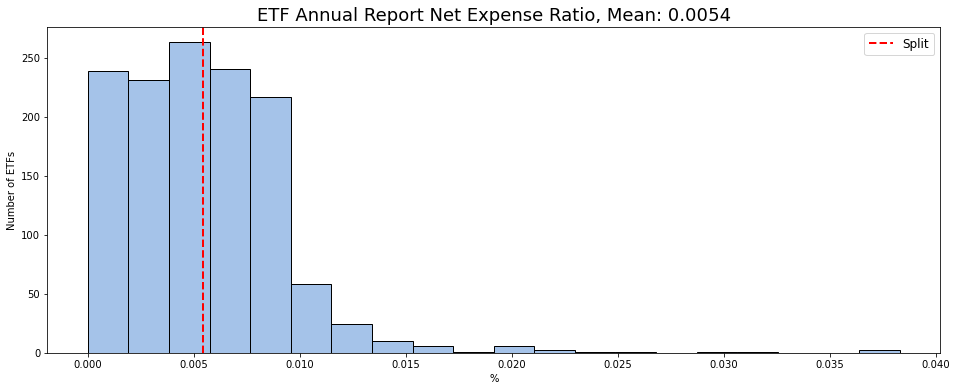

In [202]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(etf['fund_annual_report_net_expense_ratio'], bins=20, color='#87afe2')
mean = etf['fund_annual_report_net_expense_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Annual Report Net Expense Ratio, Mean: {round(mean, 4)}', fontsize=18)
plt.show()

The ETF net expense ratio is also right-skewed, with an average annual expense ratio of 0.54%

In [203]:
etf['fund_annual_report_net_expense_ratio'].groupby(etf['size_type']).describe()

count      mean       std     min       25%     50%       75%  \
size_type                                                                  
Large      622.0  0.005455  0.003460  0.0003  0.002900  0.0051  0.007800   
Medium     230.0  0.005716  0.003484  0.0005  0.003525  0.0052  0.007075   
None       330.0  0.005301  0.004583  0.0000  0.001800  0.0039  0.008500   
Small      121.0  0.005268  0.004010  0.0004  0.002500  0.0046  0.007500   

              max  
size_type          
Large      0.0383  
Medium     0.0237  
None       0.0367  
Small      0.0320

In [204]:
etf['fund_annual_report_net_expense_ratio'].groupby(etf['investment_type']).describe()

count      mean       std     min     25%     50%     75%  \
investment_type                                                              
Blend            460.0  0.005470  0.003542  0.0003  0.0025  0.0050  0.0079   
Growth           233.0  0.006282  0.003641  0.0004  0.0045  0.0060  0.0079   
None             330.0  0.005301  0.004583  0.0000  0.0018  0.0039  0.0085   
Value            280.0  0.004876  0.003321  0.0004  0.0029  0.0045  0.0060   

                    max  
investment_type          
Blend            0.0291  
Growth           0.0383  
None             0.0367  
Value            0.0320

For passively managed funds, we wouldn't expech much difference in the expense ratio. But we do see:
- `Medium` sized ETFs have a slightly higher expense ratio
- `Growth` focused ETFs has a much higher expense ratio, likely because the funds have to track those type of equities more closely 

In [205]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(etf['category_annual_report_net_expense_ratio'], bins=20, color='#87afe2')
mean = etf['category_annual_report_net_expense_ratio'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('%')
plt.ylabel('Number of ETFs')
plt.title(f'ETF category Annual Report Net Expense Ratio, Mean: {round(mean, 4)}', fontsize=18)
plt.show()

After the market exposure, the average annual expense ratio for ETFs is 0.33%

In [206]:
etf['category_annual_report_net_expense_ratio'].groupby(etf['size_type']).describe()

count      mean       std  min     25%     50%     75%     max
size_type                                                                
Large      622.0  0.003160  0.002509  0.0  0.0000  0.0036  0.0046  0.0112
Medium     230.0  0.003728  0.002654  0.0  0.0000  0.0046  0.0053  0.0112
None       330.0  0.003258  0.003281  0.0  0.0000  0.0023  0.0055  0.0095
Small      121.0  0.003671  0.002405  0.0  0.0033  0.0040  0.0047  0.0095

In [207]:
etf['category_annual_report_net_expense_ratio'].groupby(etf['investment_type']).describe()

count      mean       std  min     25%     50%       75%  \
investment_type                                                             
Blend            460.0  0.003004  0.002534  0.0  0.0000  0.0036  0.004425   
Growth           233.0  0.003693  0.002782  0.0  0.0000  0.0039  0.005300   
None             330.0  0.003258  0.003281  0.0  0.0000  0.0023  0.005500   
Value            280.0  0.003660  0.002265  0.0  0.0034  0.0040  0.004800   

                    max  
investment_type          
Blend            0.0112  
Growth           0.0112  
None             0.0095  
Value            0.0112

After adjusting to market exposure, all of the expense ratios are very similar. The `Growth` and `Value` investment types have the same expense ratio - which makes more sense now seeing that these funds require two completely different approaches.

### Asset composition

In the next section, we'll look at the composition breakdown of mutual funds and ETFs:

#### `MutualFunds.csv`

In [208]:
mf_avg_assets = mutual_fund[['asset_cash', 'asset_stocks', 'asset_bonds', 'asset_others', 'asset_preferred', 'asset_convertible']].mean()

In [209]:
mf_avg_assets.sort_values(ascending=False)

asset_stocks         0.587551
asset_bonds          0.242199
asset_cash           0.049756
asset_others         0.007911
asset_convertible    0.007085
asset_preferred      0.002696
dtype: float64

In [210]:
plt.figure(figsize=(8,6))
sns.barplot(x=mf_avg_assets.sort_values(ascending=False), y=mf_avg_assets.sort_values(ascending=False).index, palette='Blues_r')
plt.title('Mutual Fund Average Asset Breakdown')
plt.tight_layout
plt.show()

The top 3 average asset breakdown for mutual funds is: stocks (58.8%), bonds (24.2%) and cash (5%)

#### `ETFs`

In [211]:
etf_avg_assets = etf[['asset_stocks', 'asset_bonds']].mean()

In [212]:
etf_avg_assets.sort_values(ascending=False)

asset_stocks    0.517915
asset_bonds     0.054660
dtype: float64

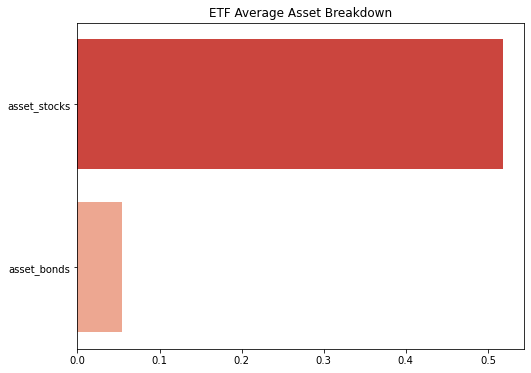

In [213]:
plt.figure(figsize=(8,6))
sns.barplot(x=etf_avg_assets.sort_values(ascending=False), y=etf_avg_assets.sort_values(ascending=False).index, palette='Reds_r')
plt.title('ETF Average Asset Breakdown')
plt.tight_layout
plt.show()

The ETF dataset only had two types of asset breakdown: stocks (51.8) and bonds (5.5%) while the rest were not defined.

### Sectors

#### `MutualFunds.csv`

In [214]:
mf_sectors = mutual_fund[['fund_sector_basic_materials', 'fund_sector_communication_services', 'fund_sector_consumer_cyclical', 'fund_sector_consumer_defensive', 'fund_sector_energy', 'fund_sector_financial_services', 'fund_sector_healthcare', 'fund_sector_industrials', 'fund_sector_real_estate', 'fund_sector_technology', 'fund_sector_utilities']].mean()
mf_sectors.sort_values(ascending=False)

fund_sector_technology                0.128961
fund_sector_financial_services        0.113076
fund_sector_healthcare                0.088625
fund_sector_consumer_cyclical         0.087217
fund_sector_industrials               0.085857
fund_sector_communication_services    0.061581
fund_sector_energy                    0.049929
fund_sector_consumer_defensive        0.045792
fund_sector_real_estate               0.044801
fund_sector_basic_materials           0.037606
fund_sector_utilities                 0.027209
dtype: float64

In [215]:
plt.figure(figsize=(12,6))
sns.barplot(x=mf_sectors.sort_values(ascending=False), y=mf_sectors.sort_values(ascending=False).index, palette='Blues_r')
plt.title('Mutual Fund Average Sector Breakdown')
plt.tight_layout
plt.show()

The top 5 average sector breakdown for mutual funds are: technology (12.9%), financial services (11.3%), healthcare (8.9%), consumer cyclical (8.7%) and industrials (8.6%)

In [216]:
mutual_fund.columns.get_loc('fund_sector_basic_materials')

44

In [217]:
mutual_fund.columns.get_loc('fund_sector_utilities')

54

In [218]:
mutual_fund.iloc[:,44:55].groupby(mutual_fund['size_type']).mean()

fund_sector_basic_materials  fund_sector_communication_services  \
size_type                                                                    
Large                         0.042408                            0.090174   
Medium                        0.033306                            0.021605   
None                          0.004384                            0.003191   
Small                         0.035815                            0.036106   

           fund_sector_consumer_cyclical  fund_sector_consumer_defensive  \
size_type                                                                  
Large                           0.108872                        0.064970   
Medium                          0.057959                        0.018833   
None                            0.000093                        0.012495   
Small                           0.077348                        0.027428   

           fund_sector_energy  fund_sector_financial_services  \
size_type                                                       
Large                0.033894                        0.146335   
Medium               0.043097                        0.063444   
None                 0.014231                        0.013304   
Small                0.123413                        0.096004   

           fund_sector_healthcare  fund_sector_industrials  \
size_type                                                    
Large                    0.114557                 0.097418   
Medium                   0.054474                 0.067033   
None                     0.002576                 0.009077   
Small                    0.070905                 0.092850   

           fund_sector_real_estate  fund_sector_technology  \
size_type                                                    
Large                     0.030367                0.177029   
Medium                    0.094929                0.076249   
None                      0.000114                0.000999   
Small                     0.033632                0.072967   

           fund_sector_utilities  
size_type                         
Large                   0.027461  
Medium                  0.026274  
None                    0.023124  
Small                   0.028724

When we look at the mutual fund sizes, 
- The top sectors in `Large` funds are: technology (17.7%), financial services (14.6%), healthcare (11.5%)
- The top sectors in `Medium` funds are: real estate (9.5%), technology (7.6%), industrials (6.7%)
- The top sectors in `Small` funds are: financial services (9.6%), industrials (9.3%), consumer cyclical (7.7%)

In [219]:
mutual_fund.iloc[:,44:55].groupby(mutual_fund['investment_type']).mean()

fund_sector_basic_materials  \
investment_type                                
Blend                               0.039791   
Growth                              0.030434   
None                                0.004287   
Value                               0.044097   

                 fund_sector_communication_services  \
investment_type                                       
Blend                                      0.064854   
Growth                                     0.086523   
None                                       0.003204   
Value                                      0.046672   

                 fund_sector_consumer_cyclical  \
investment_type                                  
Blend                                 0.093645   
Growth                                0.125762   
None                                  0.000094   
Value                                 0.061548   

                 fund_sector_consumer_defensive  fund_sector_energy  \
investment_type                                                       
Blend                                  0.051225            0.029872   
Growth                                 0.041867            0.016411   
None                                   0.012546            0.014289   
Value                                  0.044731            0.111373   

                 fund_sector_financial_services  fund_sector_healthcare  \
investment_type                                                           
Blend                                  0.121651                0.094515   
Growth                                 0.090146                0.133788   
None                                   0.013358                0.002586   
Value                                  0.130310                0.058866   

                 fund_sector_industrials  fund_sector_real_estate  \
investment_type                                                     
Blend                           0.094499                 0.062104   
Growth                          0.090376                 0.016433   
None                            0.009114                 0.000115   
Value                           0.079803                 0.044120   

                 fund_sector_technology  fund_sector_utilities  
investment_type                                                 
Blend                          0.138321               0.024895  
Growth                         0.230161               0.008353  
None                           0.001003               0.021287  
Value                          0.059096               0.045414

When we look at the mutual fund types, 
- The top sectors in `Blend` funds are: technology (13.8%), financial services (12.1%), healthcare (9.5%)
- The top sectors in `Growth` funds are: technology (23%), healthcare (13.4%), consumer cyclical (12.5%)
- The top sectors in `Value` funds are: financial services (13%), energy (11.1%), industrials (8%)

#### `ETFs`

In [220]:
etf_sectors = etf[['fund_sector_basic_materials', 'fund_sector_communication_services', 'fund_sector_consumer_cyclical', 'fund_sector_consumer_defensive', 'fund_sector_energy', 'fund_sector_financial_services', 'fund_sector_healthcare', 'fund_sector_industrials', 'fund_sector_real_estate', 'fund_sector_technology', 'fund_sector_utilities']].mean()
etf_sectors.sort_values(ascending=False)

fund_sector_technology                0.126011
fund_sector_financial_services        0.093839
fund_sector_consumer_cyclical         0.084894
fund_sector_healthcare                0.083048
fund_sector_industrials               0.077579
fund_sector_communication_services    0.056786
fund_sector_consumer_defensive        0.046512
fund_sector_basic_materials           0.042214
fund_sector_real_estate               0.040742
fund_sector_energy                    0.039914
fund_sector_utilities                 0.029871
dtype: float64

In [221]:
plt.figure(figsize=(12,6))
sns.barplot(x=etf_sectors.sort_values(ascending=False), y=etf_sectors.sort_values(ascending=False).index, palette='Reds_r')
plt.title('ETF Average Sector Breakdown')
plt.tight_layout
plt.show()

The top 5 average sector breakdown for ETFs are: technology (12.6%), financial services (9.4%), consumer cyclical (8.5%), healthcare (8.3%), and industrials (7.8%)

In [222]:
etf.columns.get_loc('fund_sector_basic_materials')

30

In [223]:
etf.columns.get_loc('fund_sector_utilities')

40

In [224]:
etf.iloc[:,30:41].groupby(etf['size_type']).mean()

fund_sector_basic_materials  fund_sector_communication_services  \
size_type                                                                    
Large                         0.048165                            0.098683   
Medium                        0.076271                            0.041571   
None                          0.000359                            0.000093   
Small                         0.061038                            0.024949   

           fund_sector_consumer_cyclical  fund_sector_consumer_defensive  \
size_type                                                                  
Large                           0.121578                        0.074622   
Medium                          0.095529                        0.044552   
None                            0.000517                        0.000063   
Small                           0.106230                        0.032420   

           fund_sector_energy  fund_sector_financial_services  \
size_type                                                       
Large                0.035372                        0.133809   
Medium               0.058711                        0.094651   
None                 0.003034                        0.004592   
Small                0.128117                        0.130235   

           fund_sector_healthcare  fund_sector_industrials  \
size_type                                                    
Large                    0.108385                 0.093223   
Medium                   0.100411                 0.130711   
None                     0.000949                 0.003536   
Small                    0.143704                 0.098101   

           fund_sector_real_estate  fund_sector_technology  \
size_type                                                    
Large                     0.028696                0.194119   
Medium                    0.109987                0.142918   
None                      0.000176                0.000359   
Small                     0.081679                0.086456   

           fund_sector_utilities  
size_type                         
Large                   0.032802  
Medium                  0.052517  
None                    0.013594  
Small                   0.016155

When we look at the ETF sizes, 
- The top sectors in `Large` funds are: technology (19.4%), financial services (13.4%), consume cyclical (12.2%)
- The top sectors in `Medium` funds are: technology (14.3%), industrials (13.1%), real estate (11%)
- The top sectors in `Small` funds are: healthcare (14.4%), financial services (13%), energy (12.8%)

In [225]:
etf.iloc[:,30:41].groupby(etf['investment_type']).mean()

fund_sector_basic_materials  \
investment_type                                
Blend                               0.062406   
Growth                              0.027057   
None                                0.000359   
Value                               0.070984   

                 fund_sector_communication_services  \
investment_type                                       
Blend                                      0.072119   
Growth                                     0.116197   
None                                       0.000093   
Value                                      0.048974   

                 fund_sector_consumer_cyclical  \
investment_type                                  
Blend                                 0.119776   
Growth                                0.140416   
None                                  0.000517   
Value                                 0.080832   

                 fund_sector_consumer_defensive  fund_sector_energy  \
investment_type                                                       
Blend                                  0.064760            0.037824   
Growth                                 0.037990            0.017408   
None                                   0.000063            0.003034   
Value                                  0.078369            0.105544   

                 fund_sector_financial_services  fund_sector_healthcare  \
investment_type                                                           
Blend                                  0.130590                0.114077   
Growth                                 0.052787                0.154715   
None                                   0.004592                0.000949   
Value                                  0.172809                0.069194   

                 fund_sector_industrials  fund_sector_real_estate  \
investment_type                                                     
Blend                           0.115320                 0.053735   
Growth                          0.076197                 0.015287   
None                            0.003536                 0.000176   
Value                           0.103990                 0.088389   

                 fund_sector_technology  fund_sector_utilities  
investment_type                                                 
Blend                          0.166520               0.025917  
Growth                         0.291057               0.006508  
None                           0.000359               0.013594  
Value                          0.070210               0.074994

When we look at the ETF types, 
- The top sectors in `Blend` funds are: technology (16.7%), financial services (13.1%), industrials (11.5%)
- The top sectors in `Growth` funds are: technology (29.1%), healthcare (15.5%), consumer cyclical (14%)
- The top sectors in `Value` funds are: financial services (17.3%), energy (10.6%), industrials (10.4%)

### Morningstar ratings

Morningstarstar Ratings is a set of ratings done by a highly regarded mutual fund and ETF rating agency. Morningstar assigns a one- to five-star ranking to each mutual fund or ETF on a peer-adjusted basis. Every single metric is relative and risk-adjusted, whereby all performances are measured against the level of risk a manager assumed to generate fund returns.

These ratings are based on a quantitative measure of fund's past performance, and provides a good benchmark for investors to evaluate a fund.

([source](https://www.investopedia.com/articles/investing/013016/are-morningstars-best-mutual-funds-really-best-morn.asp))

We only have Morningstar ratings for mutual funds:

In [226]:
# define morningstar columns

morningstar = ['morningstar_overall_rating', 'morningstar_risk_rating', 'morningstar_return_rating']

In [227]:
morningstar_r = mutual_fund.copy()
morningstar_r = mutual_fund[(mutual_fund[['morningstar_overall_rating', 'morningstar_risk_rating', 'morningstar_return_rating']] != 0).all(axis=1)]

In [228]:
multi_histo(morningstar_r, morningstar, 'Morningstar Ratings', color='#2c5a94')

The average ratings across the board is 3, which means that the stock is fairly valued and traded at or close to its fair estimate. ([source](https://www.morningstar.com/3-star-stocks))

In [229]:
morningstar_r[['morningstar_overall_rating', 'morningstar_risk_rating', 'morningstar_return_rating']].groupby(morningstar_r['size_type']).mean()

morningstar_overall_rating  morningstar_risk_rating  \
size_type                                                        
Large                        3.108656                 3.003558   
Medium                       3.122140                 3.123464   
None                         2.858543                 2.981793   
Small                        3.135003                 3.231900   

           morningstar_return_rating  
size_type                             
Large                       3.088050  
Medium                      3.119304  
None                        2.887955  
Small                       3.161404

In [230]:
morningstar_r[['morningstar_overall_rating', 'morningstar_risk_rating', 'morningstar_return_rating']].groupby(morningstar_r['investment_type']).mean()

morningstar_overall_rating  morningstar_risk_rating  \
investment_type                                                        
Blend                              3.115450                 3.041454   
Growth                             3.387473                 3.134725   
None                               2.849296                 2.987324   
Value                              2.930150                 3.079368   

                 morningstar_return_rating  
investment_type                             
Blend                             3.094923  
Growth                            3.385275  
None                              2.878873  
Value                             2.937519

Even when we look at the breakdown based on size and investment types, the average remains at 3 - but as expected the `Value` portfolio average is slightly below 3 because these equities are usually traded at a lower-than-market value.

Morningstar also provides bond ratings:

In [231]:
# define bond columns

bond_ratings = ['fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb', 'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b']

In [232]:
bond_r = mutual_fund.copy()
bond_r = mutual_fund[(mutual_fund[['fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb', 'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b']] != 0).all(axis=1)]

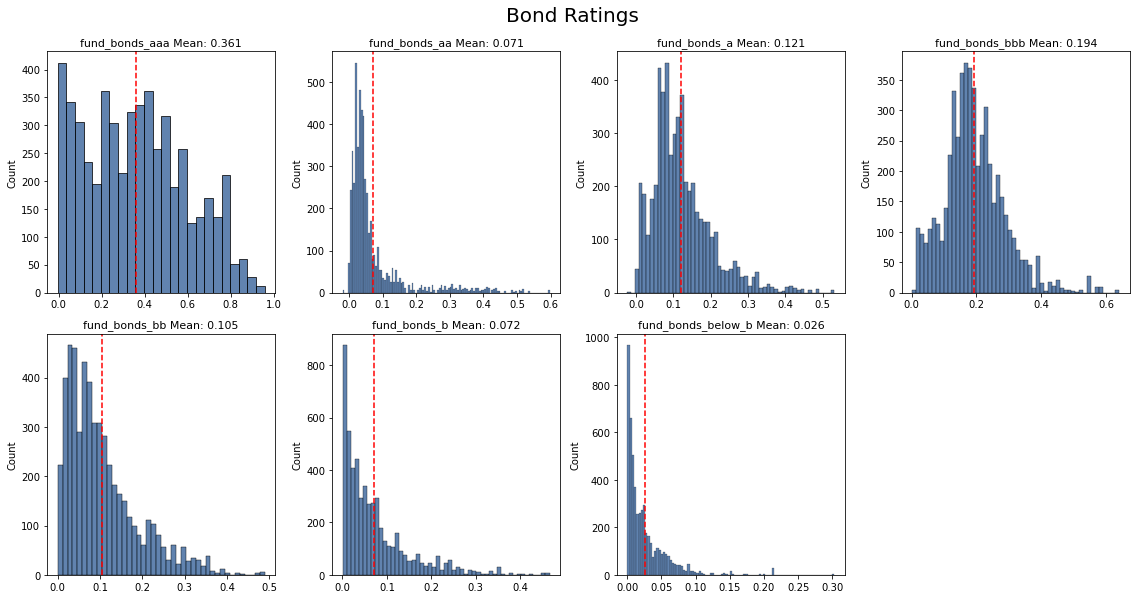

In [233]:
multi_histo(bond_r, bond_ratings, 'Bond Ratings', color='#2c5a94')

The histograms represent the breakdown of bonds with those ratings:
- Fortunately 36% of the bonds scored the highest rating of AAA
- Second highest is 19.4% bonds scoring BBB
- While the third highest is 10.5% of the bonds scoring BB

### Bond duration and maturity

A bond's duration refers to the measure of sensitivity of price to changes in interest rates. The higher a bond's duration, the more the bond's price will change when interest rates move. So when investors believe interest rates will increase, they would shift to a lower duration strategy to reduce the interest rate risk in their portfolio. 

However, a bond maturity refers to when a bond's principal is repaid with interest. If interest rates rise, the maturity of a bond doesn't change. 

([source](https://www.blackrock.com/us/individual/insights/whats-difference-duration-maturity))

#### `MutualFunds.csv`

In [234]:
no_zero_duration = mutual_fund.copy()
no_zero_duration = no_zero_duration.drop(no_zero_duration[no_zero_duration['fund_bond_duration'] == 0].index)

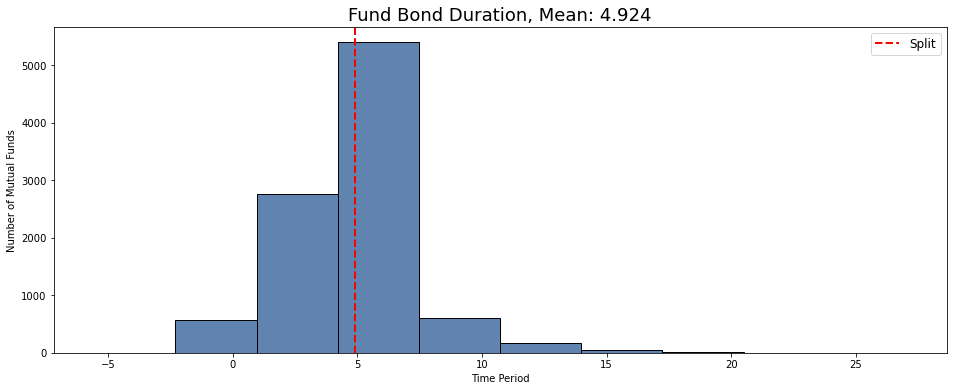

In [235]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_duration['fund_bond_duration'], bins=10, color='#2c5a94')
mean = no_zero_duration['fund_bond_duration'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Fund Bond Duration, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The average bond duration in a mutual fund is 4.9 years.

In [236]:
no_zero_duration['fund_bond_duration'].groupby(no_zero_duration['size_type']).describe()

count      mean       std   min   25%   50%    75%    max
size_type                                                            
Large      4632.0  5.374270  2.440508 -5.55  4.24  5.50  6.300  26.91
Medium     2802.0  4.757420  2.248717  0.05  2.93  5.17  6.325  15.60
None        160.0  4.293625  4.843537 -1.17  1.93  3.42  5.460  27.01
Small      2007.0  4.167598  2.434608  0.01  2.22  3.87  5.920  16.05

In [237]:
no_zero_duration['fund_bond_duration'].groupby(no_zero_duration['investment_type']).describe()

count      mean       std   min   25%   50%     75%    max
investment_type                                                             
Blend            5356.0  5.568456  1.993543 -5.55  4.85  5.73  6.3425  19.15
Growth            817.0  7.213917  2.791543  0.30  6.17  7.45  8.0500  26.91
None              160.0  4.293625  4.843537 -1.17  1.93  3.42  5.4600  27.01
Value            3268.0  3.326151  2.018349 -4.66  1.88  3.26  4.3400  16.05

When we look at the duration based on fund types,
- `Large` mutual funds have the longest average bond duration of 5.4 years
- `Growth` mutual funds have the longest average bond duration of 7.2 years

In [238]:
no_zero_cat_duration = mutual_fund.copy()
no_zero_cat_duration = no_zero_cat_duration.drop(no_zero_cat_duration[no_zero_cat_duration['category_bond_duration'] == 0].index)

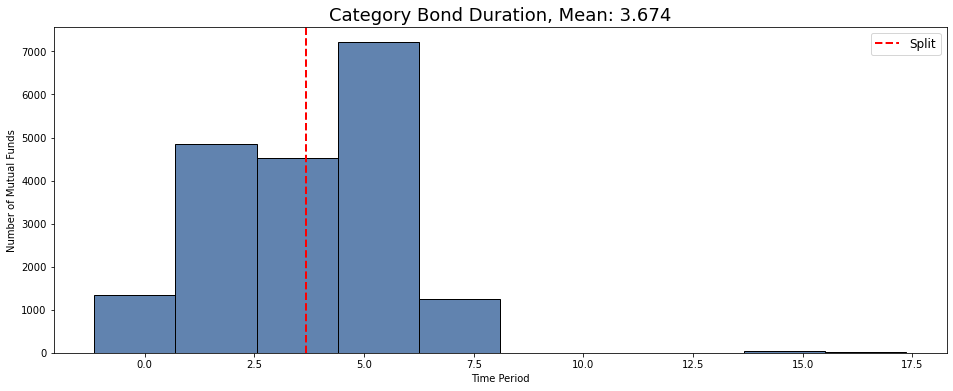

In [239]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_cat_duration['category_bond_duration'], bins=10, color='#2c5a94')
mean = no_zero_cat_duration['category_bond_duration'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Category Bond Duration, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

After exposure to the market, the average category bond duration is 3.7 years.

In [240]:
no_zero_cat_duration['category_bond_maturity'].groupby(no_zero_cat_duration['size_type']).describe()

count      mean       std  min   25%   50%   75%    max
size_type                                                           
Large      11209.0  4.819326  2.451529  0.0  3.14  4.46  6.75  21.34
Medium      3949.0  5.856189  3.708329  0.0  3.03  6.73  7.69  19.90
None         913.0  6.186988  3.780193  0.0  3.13  6.77  7.69  21.34
Small       3169.0  5.219735  3.867287  0.0  1.88  5.21  7.69  19.90

In [241]:
no_zero_cat_duration['category_bond_maturity'].groupby(no_zero_cat_duration['investment_type']).describe()

count      mean       std  min   25%   50%   75%    max
investment_type                                                          
Blend            9942.0  5.375666  3.059065  0.0  1.88  6.37  7.22  19.90
Growth           2501.0  5.627653  3.688447  0.0  3.63  3.63  7.39  21.34
None              909.0  6.200528  3.782978  0.0  3.14  6.77  7.69  21.34
Value            5888.0  4.446343  2.646381  0.0  3.03  3.96  6.11  19.90

Interestingly after exposure to the market, the values have adjusted:
- `Medium` mutual funds have the longest average category bond duration of 5.9 years
- `Growth` mutual funds have the longest average category bond duration of 5.6 years

In [242]:
no_zero_maturity = mutual_fund.copy()
no_zero_maturity = no_zero_maturity.drop(no_zero_maturity[no_zero_maturity['fund_bond_maturity'] == 0].index)

In [243]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_maturity['fund_bond_maturity'], bins=10, color='#2c5a94')
mean = no_zero_maturity['fund_bond_maturity'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Fund Bond Maturity, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The average mutual fund bond maturity is 7.5 years, much higher than the duration.

In [244]:
no_zero_maturity['fund_bond_maturity'].groupby(no_zero_maturity['size_type']).describe()

count      mean       std   min   25%   50%   75%    max
size_type                                                           
Large      3487.0  7.306206  2.995587  0.15  5.83  7.21  8.24  28.61
Medium     2344.0  8.041706  5.044197  0.21  4.35  7.18  9.90  24.25
None        222.0  6.248604  4.909501  0.03  3.12  5.43  7.49  24.10
Small      1779.0  7.486976  4.764336  0.09  4.30  6.28  8.75  26.06

In [245]:
no_zero_maturity['fund_bond_maturity'].groupby(no_zero_maturity['investment_type']).describe()

count       mean       std   min   25%    50%    75%    max
investment_type                                                              
Blend            4345.0   8.199300  3.503932  0.56  6.21   7.52   8.82  24.39
Growth            647.0  12.169892  5.794497  1.00  7.67  11.62  16.22  28.61
None              222.0   6.248604  4.909501  0.03  3.12   5.43   7.49  24.10
Value            2618.0   5.403342  3.346480  0.09  3.11   4.69   7.28  26.06

When we look at the maturity based on fund types,
- `Medium` mutual funds have the longest average bond maturity of 8 years
- `Growth` mutual funds have the longest average bond maturity of 12.2 years

In [246]:
no_zero_cat_maturity = mutual_fund.copy()
no_zero_cat_maturity = no_zero_cat_maturity.drop(no_zero_cat_maturity[no_zero_cat_maturity['category_bond_maturity'] == 0].index)

In [247]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_cat_maturity['category_bond_maturity'], bins=10, color='#2c5a94')
mean = no_zero_cat_maturity['category_bond_maturity'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Category Bond Maturity, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

After exposure to the market, the average category bond maturity is 5.4 years.

In [248]:
no_zero_cat_maturity['category_bond_maturity'].groupby(no_zero_cat_maturity['size_type']).describe()

count      mean       std   min   25%   50%   75%    max
size_type                                                            
Large      10852.0  4.977869  2.327757  0.26  3.63  5.39  6.75  21.34
Medium      3482.0  6.713725  3.133330  0.14  4.46  6.90  7.96  19.90
None         859.0  6.575925  3.553677  0.24  4.46  6.89  7.69  21.34
Small       3152.0  5.260279  3.850678  0.14  1.88  5.21  7.69  19.90

In [249]:
no_zero_cat_maturity['category_bond_maturity'].groupby(no_zero_cat_maturity['investment_type']).describe()

count      mean       std   min   25%   50%     75%    max
investment_type                                                             
Blend            9267.0  5.787697  2.767451  0.14  3.63  6.72  7.2600  19.90
Growth           2459.0  5.753274  3.621143  0.14  3.63  3.63  7.3900  21.34
None              855.0  6.592140  3.554046  0.24  4.46  6.89  7.6900  21.34
Value            5764.0  4.546837  2.588919  0.14  3.03  3.96  6.1425  19.90

When we look at the maturity based on fund types,
- `Medium` mutual funds have the longest average category bond maturity of 6.7 years
- `Blend` mutual funds have the longest average category bond maturity of 5.8 years

#### `ETFs`

In [250]:
no_zero_duration_etf = etf.copy()
no_zero_duration_etf = no_zero_duration_etf.drop(no_zero_duration_etf[no_zero_duration_etf['fund_bond_duration'] == 0].index)

In [251]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_duration_etf['fund_bond_duration'], bins=10, color='#87afe2')
mean = no_zero_duration_etf['fund_bond_duration'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Bond Duration, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The ETF average bond duration is 5.5 years, slightly higher than the mutual funds' duration.

In [252]:
no_zero_duration_etf['fund_bond_duration'].groupby(no_zero_duration_etf['size_type']).describe()

count      mean       std   min    25%   50%    75%    max
size_type                                                            
Large       26.0  6.823462  5.436271  0.41  3.430  4.29  10.22  18.58
Medium      21.0  6.005238  3.328217  0.20  4.110  6.42   7.42  14.59
None       139.0  5.245396  4.880403  0.05  1.985  4.47   6.67  27.58
Small       17.0  4.386471  1.992109  1.81  3.570  3.96   4.86  10.32

In [253]:
no_zero_duration_etf['fund_bond_duration'].groupby(no_zero_duration_etf['investment_type']).describe()

count      mean       std   min    25%   50%      75%    max
investment_type                                                              
Blend             23.0  6.436087  3.832412  2.47  3.905  4.85   6.9200  17.82
Growth            15.0  8.953333  5.287497  1.81  5.200  8.96  10.8200  18.58
None             139.0  5.245396  4.880403  0.05  1.985  4.47   6.6700  27.58
Value             26.0  3.683077  1.964132  0.20  2.560  3.76   4.0925   7.20

When we look at the maturity based on fund types,
- `Large` ETFs have the longest average bond duration of 6.8 years
- `Growth` ETFs have the longest average bond duration of 8.9 years

These are much higher than those of mutual funds.

In [254]:
no_zero_maturity_etf = etf.copy()
no_zero_maturity_etf = no_zero_maturity_etf.drop(no_zero_maturity_etf[no_zero_maturity_etf['fund_bond_maturity'] == 0].index)

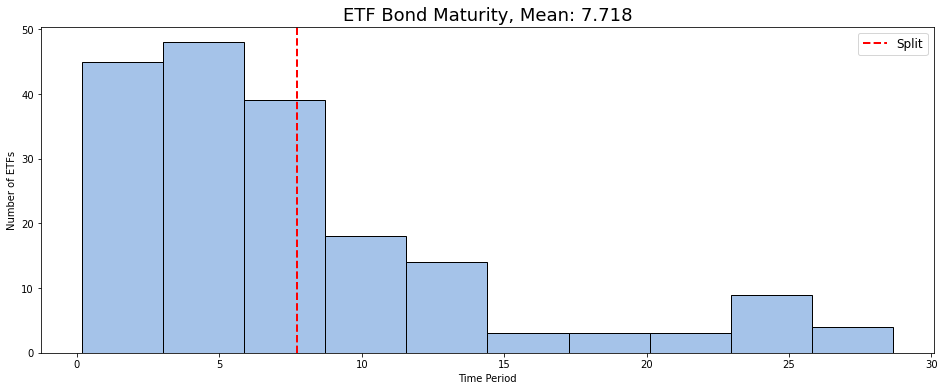

In [255]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_maturity_etf['fund_bond_maturity'], bins=10, color='#87afe2')
mean = no_zero_maturity_etf['fund_bond_maturity'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Time Period')
plt.ylabel('Number of ETFs')
plt.title(f'ETF Bond Maturity, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The average ETF bond maturity is 7.7 years, around the same as mutual funds' bond maturity.

In [256]:
no_zero_maturity_etf['fund_bond_maturity'].groupby(no_zero_maturity_etf['size_type']).describe()

count      mean       std   min    25%   50%     75%    max
size_type                                                             
Large       25.0  9.655200  7.533669  0.59  4.360  5.95  14.100  26.18
Medium      19.0  8.796842  5.512476  0.74  5.390  8.25   9.500  22.07
None       127.0  7.286220  6.462578  0.16  2.825  5.47   9.120  28.66
Small       15.0  6.782667  4.941970  1.87  4.460  5.80   6.325  18.93

In [257]:
no_zero_maturity_etf['fund_bond_maturity'].groupby(no_zero_maturity_etf['investment_type']).describe()

count       mean       std   min     25%    50%      75%  \
investment_type                                                             
Blend             23.0   9.096522  5.590373  3.70  5.5050   6.49  11.7300   
Growth            14.0  13.000000  8.706656  1.87  6.1325  12.57  20.4675   
None             127.0   7.286220  6.462578  0.16  2.8250   5.47   9.1200   
Value             22.0   5.410909  2.722689  0.59  4.2250   4.93   8.0075   

                   max  
investment_type         
Blend            24.30  
Growth           26.18  
None             28.66  
Value             9.56

When we look at the maturity based on fund types,
- `Large` ETFs have the longest average bond maturity of 9.7 years
- `Growth` ETFs have the longest average bond maturity of 13 years

These are also slightly higher than the mutual funds' bond maturity.

### ESG metrics

The Environmental, Social and Governance (ESG) scores are based on [Morningstar's Sustainalytics](https://www.sustainalytics.com/esg-data) research that measures a a company’s exposure to industry-specific material ESG risks and how well a company is managing those risks. Sustainalytics identified five categories of ESG risk severity:
- 0-10: Negligible
- Low: 10-20
- Medium: 20-30
- High: 30-40
- Severe: 40+

Ideally companies should remain around the Medium mark or less.

In [258]:
# first we drop rows that are zero

no_zero_esg = mutual_fund.copy()
no_zero_esg_score = no_zero_esg.drop(no_zero_esg[no_zero_esg['esg_score'] == 0].index)
# no_zero_esg = no_zero_esg.drop(no_zero_esg[no_zero_esg['environment_score'] == 0].index)
# no_zero_esg = no_zero_esg.drop(no_zero_esg[no_zero_esg['social_score'] == 0].index)
# no_zero_gov = no_zero_esg.drop(no_zero_esg[no_zero_esg['governance_score'] == 0].index)

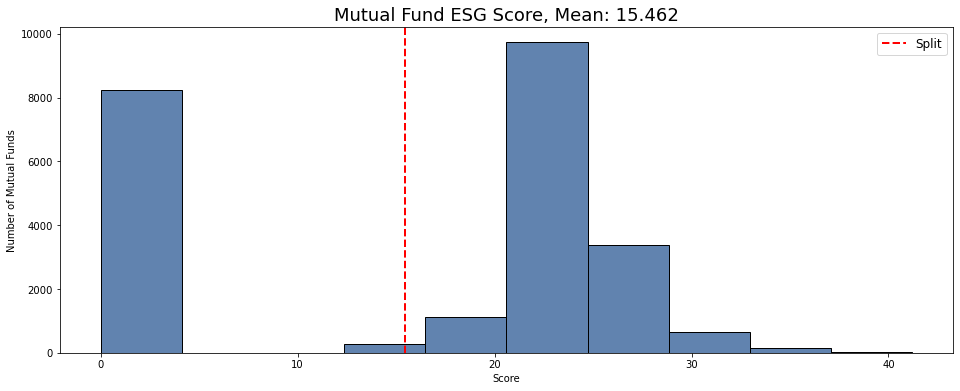

In [259]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
sns.histplot(no_zero_esg['esg_score'], bins=10, color='#2c5a94')
mean = no_zero_esg['esg_score'].mean()
plt.axvline(mean, ls='--', c='red', label='Split', lw=2)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Score')
plt.ylabel('Number of Mutual Funds')
plt.title(f'Mutual Fund ESG Score, Mean: {round(mean, 3)}', fontsize=18)
plt.show()

The overall ESG score is 23.1 - which means most funds have medium ESG risks. 

In [260]:
e_s_g = ['environment_score', 'social_score', 'governance_score']
multi_histo(no_zero_esg, e_s_g, 'ESG Individual Scores', color='#2c5a94')

When we look at the individual breakdown of scores, we can see that each area is below 10 - meaning the risks are negligible. Since the individual scores may not make much impact in our modeling, we will most likely only use ESG score.

In [261]:
mutual_fund.columns.get_loc('esg_score')

268

In [262]:
mutual_fund.columns.get_loc('peer_governance_max')

283

In [263]:
mutual_fund.iloc[:,268:284].groupby(mutual_fund['size_type']).mean()

esg_score  peer_esg_min  peer_esg_avg  peer_esg_max  \
size_type                                                        
Large      18.645865     15.701402     18.732328     23.656892   
Medium     11.973944      9.612763     11.967262     14.728469   
None        2.555311      2.196932      2.558145      2.855056   
Small      12.872813     10.080419     12.697774     14.886259   

           environment_score  peer_environment_min  peer_environment_avg  \
size_type                                                                  
Large               3.355826              1.736146              3.400841   
Medium              1.880269              1.343875              2.398771   
None                0.277146              0.273058              0.422130   
Small               0.163366              1.143296              1.485799   

           peer_environment_max  social_score  peer_social_min  \
size_type                                                        
Large                  6.350100      7.846055         5.741921   
Medium                 3.914571      3.228155         3.002319   
None                   0.699857      0.688787         0.818634   
Small                  1.866492      0.295737         2.291187   

           peer_social_avg  peer_social_max  governance_score  \
size_type                                                       
Large             7.856447         9.454566          6.089625   
Medium            4.220410         5.428292          2.418001   
None              0.971835         1.118135          0.520754   
Small             2.617112         2.896639          0.236624   

           peer_governance_min  peer_governance_avg  peer_governance_max  
size_type                                                                 
Large                 4.501038             6.091263             7.455816  
Medium                2.335941             3.176718             4.170009  
None                  0.591713             0.736942             0.860815  
Small                 1.733653             2.069847             2.452130

In [264]:
mutual_fund.iloc[:,268:284].groupby(mutual_fund['investment_type']).mean()

esg_score  peer_esg_min  peer_esg_avg  peer_esg_max  \
investment_type                                                        
Blend            15.595251     13.246326     15.704834     19.238161   
Growth           19.739945     16.224587     19.902493     25.793151   
None              2.484933      2.138250      2.490532      2.762712   
Value            14.015728     11.094143     13.785159     16.917138   

                 environment_score  peer_environment_min  \
investment_type                                            
Blend                     2.529252              1.657318   
Growth                    2.236370              1.227663   
None                      0.278280              0.264043   
Value                     2.468757              1.574400   

                 peer_environment_avg  peer_environment_max  social_score  \
investment_type                                                             
Blend                        2.827227              4.793295      5.621050   
Growth                       2.734887              5.464808      6.406231   
None                         0.409089              0.674964      0.691607   
Value                        2.895125              4.946878      4.387078   

                 peer_social_min  peer_social_avg  peer_social_max  \
investment_type                                                      
Blend                   4.658315         6.112434         7.235948   
Growth                  5.110964         7.179651         9.140932   
None                    0.799509         0.947134         1.087953   
Value                   3.738124         5.193884         6.219660   

                 governance_score  peer_governance_min  peer_governance_avg  \
investment_type                                                               
Blend                    4.404755             3.640557             4.784388   
Growth                   4.862386             3.931874             5.474037   
None                     0.522886             0.579335             0.719294   
Value                    3.350125             2.951771             3.966828   

                 peer_governance_max  
investment_type                       
Blend                       5.818040  
Growth                      6.909606  
None                        0.840604  
Value                       4.947472

When we look at the breakdown of ESG scores by fund types,
- `Large` funds has the highest average ESG score,as well as the other scores across the board - this makes sense as the portfolio is much bigger
- Meanwhile, `Growth` focused funds have the highest average ESG risk score - this could be because innovative companies likely focus their time on the R&D versus ESG

## Feature Selection

Now that we've done comprehensive EDA, we can start shortlisting features to include in the modeling process. 

We'll start with dropping all categorical variables that are irrelevant and excluding the performance columns, e.g. returns and performance risk ratios. Reason we should remove the performance-based columns is to avoid data leakage as these columns have a function or are related to the target variable.

For our target variables, we'll explore predicting against year-to-date return and 3-year fund alpha ratios. Unfortunately fund prediction models are known to not be effective, so to mitigate we will focus on shorter-term prediction. 

### `MutualFunds.csv`

In [265]:
# drop categorical variables

mutual_fund.drop(['fund_symbol', 'fund_short_name', 'fund_long_name', 'fund_category', 'fund_family', 'management_name', 'management_bio', 'management_start_date', 'inception_date', 'investment_strategy', 'returns_as_of_date', 'top10_holdings','esg_peer_group'], axis=1, inplace=True)

In [266]:
# shortlisting features

mutual_fund = mutual_fund[['total_net_assets', 'year_to_date_return', 'fund_yield', 'morningstar_overall_rating', 'morningstar_risk_rating', 'last_dividend', 'annual_holdings_turnover', 'investment_type', 'size_type', 'fund_annual_report_net_expense_ratio', 'asset_cash', 'asset_stocks', 'asset_bonds', 'asset_others', 'asset_preferred', 'asset_convertible', 'fund_sector_basic_materials', 'fund_sector_communication_services', 'fund_sector_consumer_cyclical', 'fund_sector_consumer_defensive', 'fund_sector_energy', 'fund_sector_financial_services', 'fund_sector_healthcare', 'fund_sector_industrials', 'fund_sector_real_estate', 'fund_sector_technology', 'fund_sector_utilities', 'fund_price_book_ratio', 'fund_price_cashflow_ratio', 'fund_price_earning_ratio', 'fund_price_sales_ratio', 'fund_bond_maturity', 'fund_bond_duration','fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb', 'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b', 'fund_bonds_others', 'morningstar_return_rating', 'fund_return_ytd', 'fund_alpha_3years', 'esg_score', 'environment_score', 'social_score', 'governance_score']]

As `investment_type` and `size_type` are crucial indicators for our model, we'll drop the rows with `None` input. 

We'll then proceed to encode these columns so we can include it in the modeling process.

In [267]:
# drop `None` rows

mutual_fund = mutual_fund.drop(mutual_fund[mutual_fund['investment_type'] == 'None'].index)

In [268]:
mutual_fund = mutual_fund.drop(mutual_fund[mutual_fund['size_type'] == 'None'].index)

In [269]:
# one hot encode

mutual_fund = pd.get_dummies(mutual_fund, columns=['investment_type', 'size_type'])

In [270]:
mutual_fund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22586 entries, 0 to 23565
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   total_net_assets                      22586 non-null  float64
 1   year_to_date_return                   22586 non-null  float64
 2   fund_yield                            22586 non-null  float64
 3   morningstar_overall_rating            22586 non-null  float64
 4   morningstar_risk_rating               22586 non-null  float64
 5   last_dividend                         22586 non-null  float64
 6   annual_holdings_turnover              22586 non-null  float64
 7   fund_annual_report_net_expense_ratio  22586 non-null  float64
 8   asset_cash                            22586 non-null  float64
 9   asset_stocks                          22586 non-null  float64
 10  asset_bonds                           22586 non-null  float64
 11  asset_others   

#### Heatmap

We have two similar year-to-date returns columns, so we'll put together the correlation heatmap to see which one is more relevant to our other features.

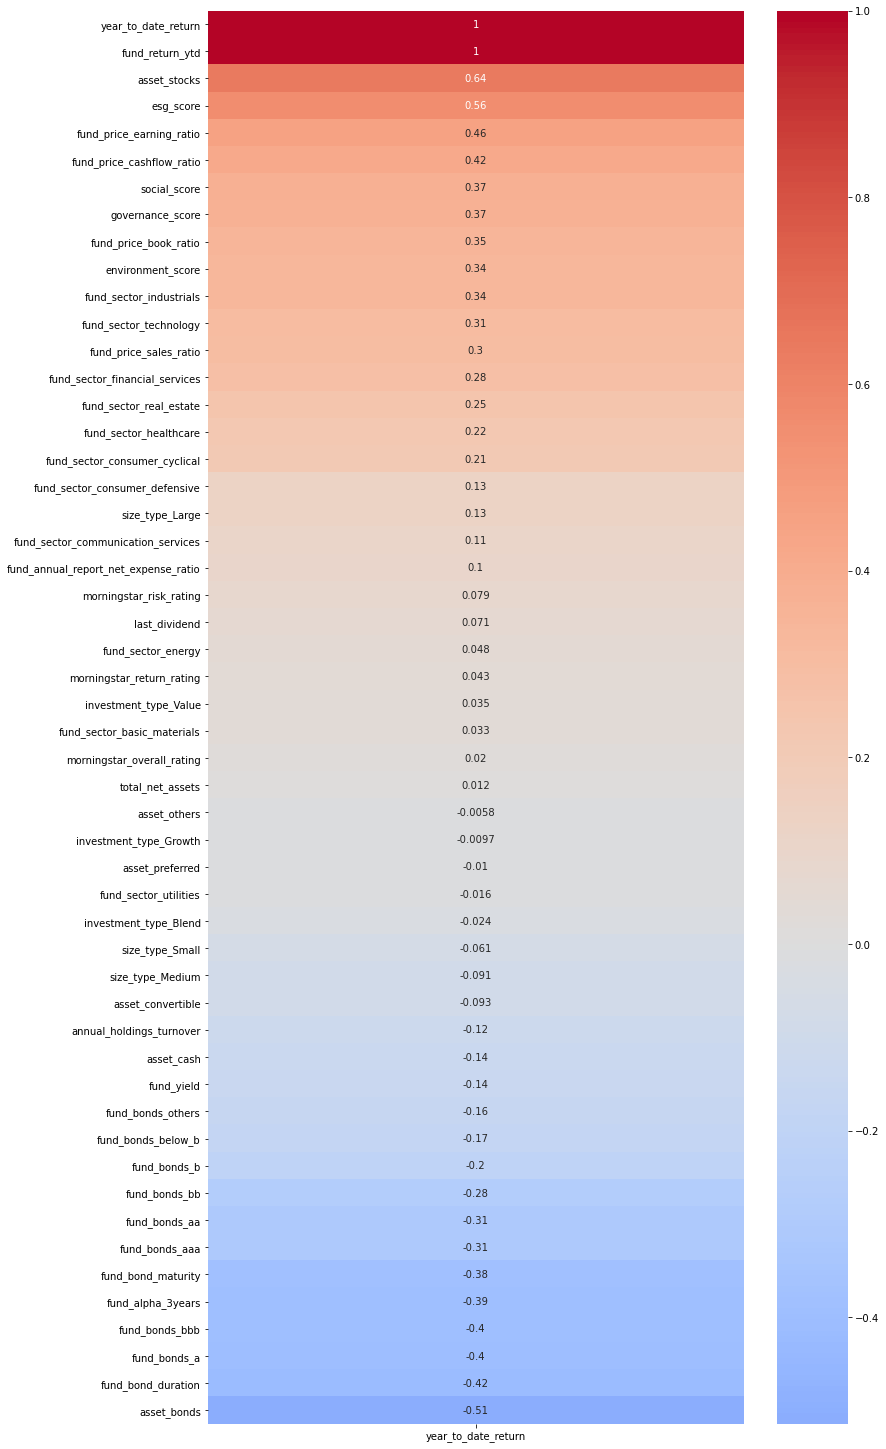

In [271]:
figure = plt.figure(figsize=(12,26))
sns.heatmap(mutual_fund.corr()[['year_to_date_return']].sort_values('year_to_date_return',ascending=False),annot=True, cmap='coolwarm', center=0);

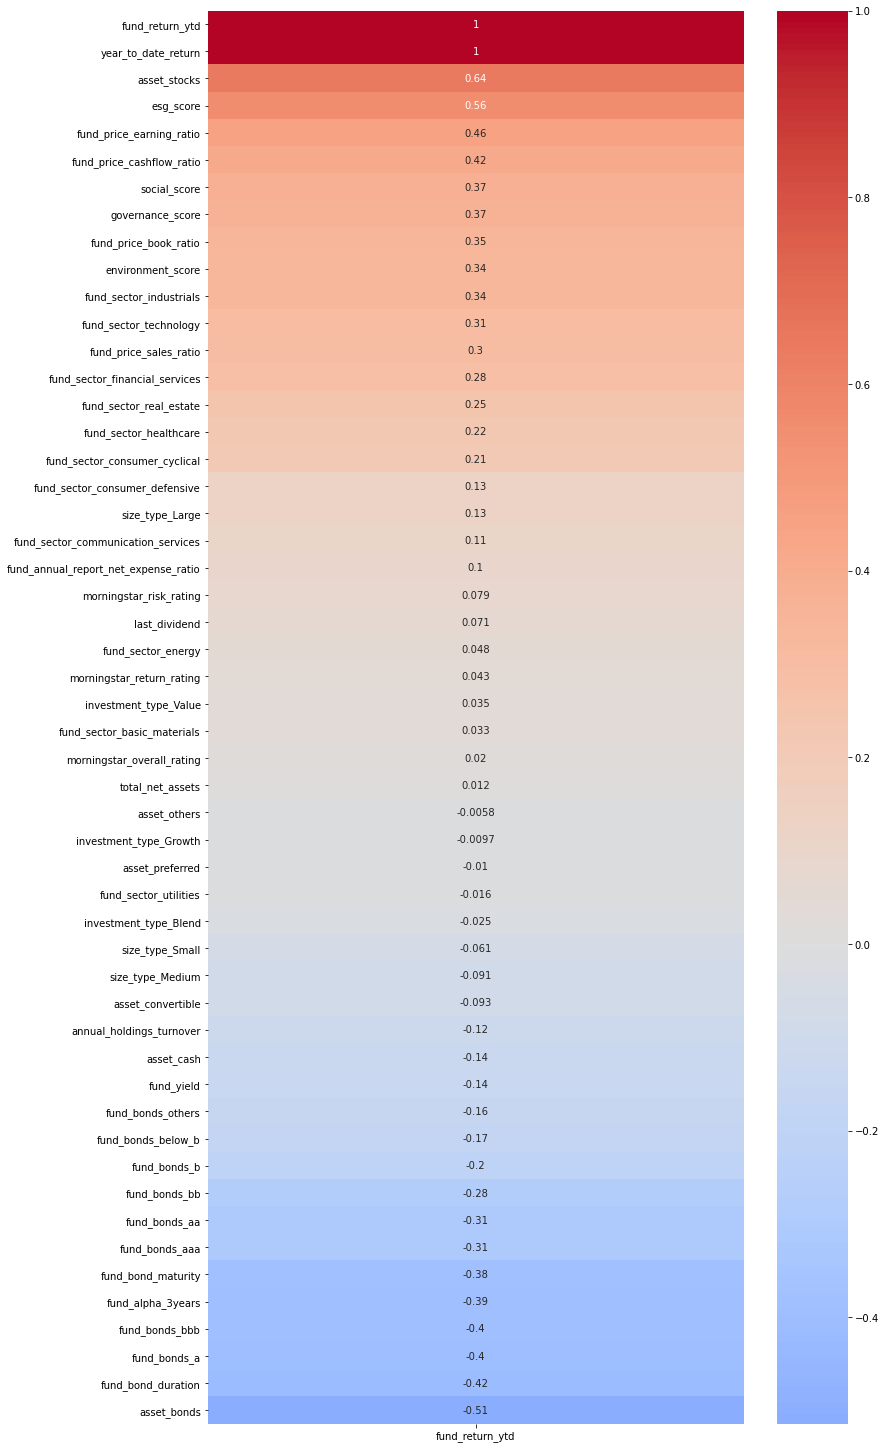

In [272]:
figure = plt.figure(figsize=(12,26))
sns.heatmap(mutual_fund.corr()[['fund_return_ytd']].sort_values('fund_return_ytd',ascending=False),annot=True, cmap='coolwarm', center=0);

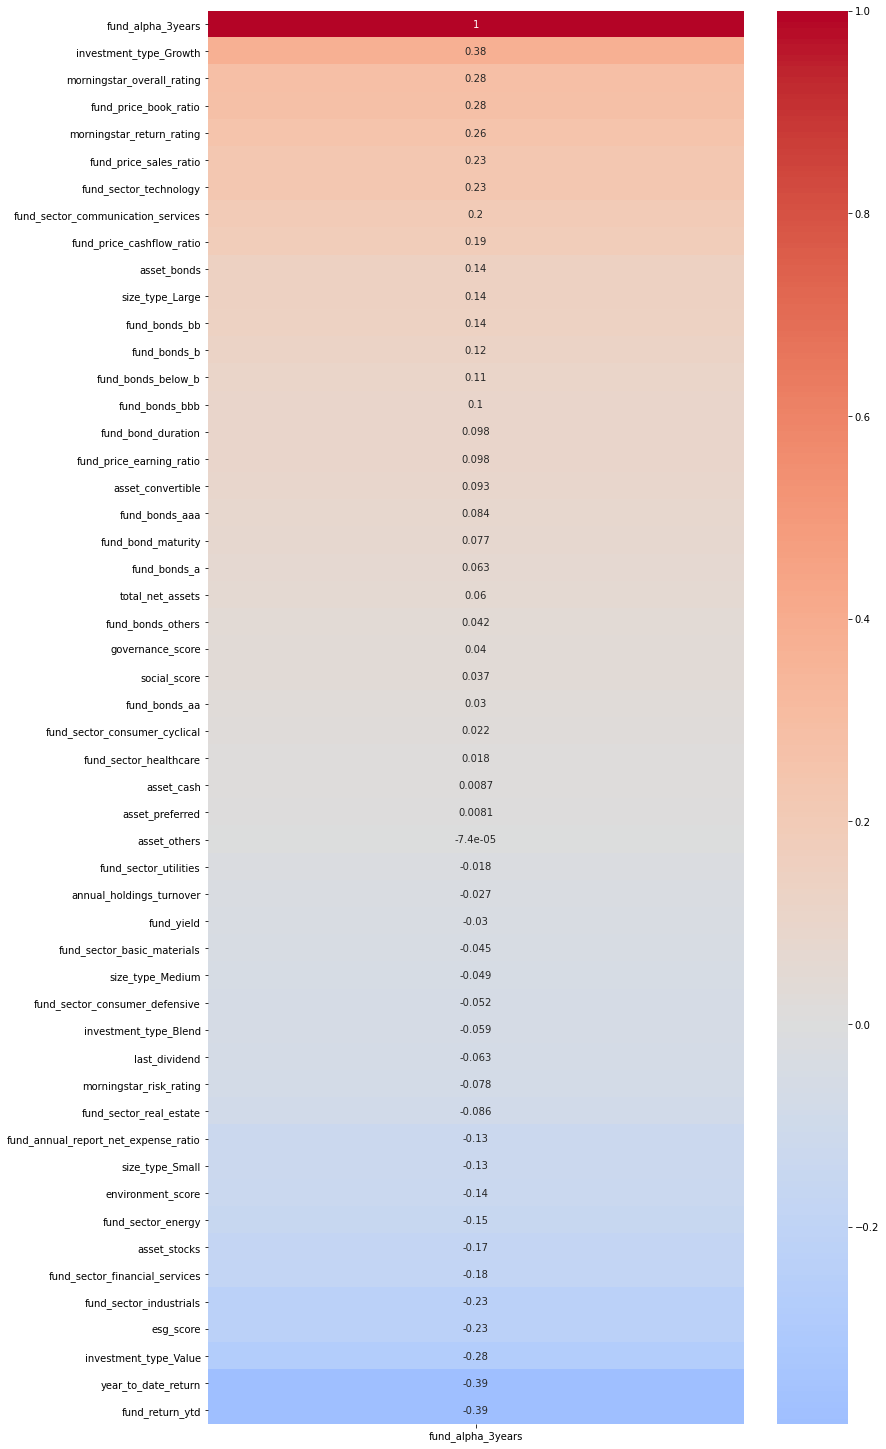

In [273]:
figure = plt.figure(figsize=(12,26))
sns.heatmap(mutual_fund.corr()[['fund_alpha_3years']].sort_values('fund_alpha_3years',ascending=False),annot=True, cmap='coolwarm', center=0);

It appears that that there's quite a number of multicollinearity happening, so we'll take a closer look at which of these features are correlated.

In [274]:
corr_matrix = mutual_fund.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False))
sol.head(20)

year_to_date_return         fund_return_ytd              0.999997
social_score                governance_score             0.985697
morningstar_overall_rating  morningstar_return_rating    0.939373
fund_price_cashflow_ratio   fund_price_earning_ratio     0.876492
fund_price_book_ratio       fund_price_cashflow_ratio    0.871710
environment_score           governance_score             0.829439
                            social_score                 0.829431
asset_stocks                esg_score                    0.825722
fund_price_book_ratio       fund_price_earning_ratio     0.794642
fund_sector_technology      fund_price_book_ratio        0.774289
fund_bonds_bb               fund_bonds_b                 0.765674
fund_bonds_b                fund_bonds_below_b           0.763999
fund_sector_technology      fund_price_cashflow_ratio    0.747288
fund_bond_maturity          fund_bond_duration           0.744239
asset_stocks                asset_bonds                  0.741275
esg_score 

Based on the above, 
- We'll drop the `fund_return_ytd` column as it's less correlated to the other features
- We'll drop the individual ESG scores (`social_score`, `governance_score`, `environment_score`) as their values already add up to the `esg_score`
- We'll drop `morningstar_return_rating` that's highly correlated to the `morningstar_overall_rating`
- We'll focus on `fund_price_earning_ratio` and drop the remaining stock valuation indicators

In [275]:
# remove one of the return columns

mutual_fund.drop('fund_return_ytd', axis=1, inplace=True)

In [276]:
# remove high collinearity features

mutual_fund.drop(['social_score', 'governance_score', 'environment_score', 'morningstar_return_rating', 'fund_price_book_ratio', 'fund_price_sales_ratio', 'fund_price_cashflow_ratio'], axis=1, inplace=True)

In [277]:
mutual_fund.corr()[['year_to_date_return']].sort_values('year_to_date_return',ascending=False)

year_to_date_return
year_to_date_return                              1.000000
asset_stocks                                     0.643645
esg_score                                        0.559924
fund_price_earning_ratio                         0.458929
fund_sector_industrials                          0.338525
fund_sector_technology                           0.306144
fund_sector_financial_services                   0.282172
fund_sector_real_estate                          0.248125
fund_sector_healthcare                           0.222553
fund_sector_consumer_cyclical                    0.214734
fund_sector_consumer_defensive                   0.127938
size_type_Large                                  0.125664
fund_sector_communication_services               0.112527
fund_annual_report_net_expense_ratio             0.099644
morningstar_risk_rating                          0.079398
last_dividend                                    0.071021
fund_sector_energy                               0.048121
investment_type_Value                            0.035370
fund_sector_basic_materials                      0.033312
morningstar_overall_rating                       0.019555
total_net_assets                                 0.012273
asset_others                                    -0.005768
investment_type_Growth                          -0.009656
asset_preferred                                 -0.010154
fund_sector_utilities                           -0.016203
investment_type_Blend                           -0.024488
size_type_Small                                 -0.061020
size_type_Medium                                -0.090579
asset_convertible                               -0.092620
annual_holdings_turnover                        -0.122830
asset_cash                                      -0.139344
fund_yield                                      -0.142930
fund_bonds_others                               -0.157080
fund_bonds_below_b                              -0.174615
fund_bonds_b                                    -0.200756
fund_bonds_bb                                   -0.277377
fund_bonds_aa                                   -0.311256
fund_bonds_aaa                                  -0.312879
fund_bond_maturity                              -0.379008
fund_alpha_3years                               -0.394612
fund_bonds_bbb                                  -0.395299
fund_bonds_a                                    -0.400605
fund_bond_duration                              -0.416040
asset_bonds                                     -0.514191

Seeing that some of the `others` columns under assets and fund bonds do not have very high correlation, we'll go ahead and drop these first.

In [278]:
# remove some of the 'others' columns

mutual_fund.drop(['asset_others', 'asset_preferred', 'asset_convertible', 'fund_bonds_others'] , axis=1, inplace=True)

In [279]:
mutual_fund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22586 entries, 0 to 23565
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   total_net_assets                      22586 non-null  float64
 1   year_to_date_return                   22586 non-null  float64
 2   fund_yield                            22586 non-null  float64
 3   morningstar_overall_rating            22586 non-null  float64
 4   morningstar_risk_rating               22586 non-null  float64
 5   last_dividend                         22586 non-null  float64
 6   annual_holdings_turnover              22586 non-null  float64
 7   fund_annual_report_net_expense_ratio  22586 non-null  float64
 8   asset_cash                            22586 non-null  float64
 9   asset_stocks                          22586 non-null  float64
 10  asset_bonds                           22586 non-null  float64
 11  fund_sector_bas

After the initial cleaning, we had 23,567 rows and 284 columns. Finally, we are down to 22,586 rows and 40 columns for modeling.

### `ETFs.csv`

We'll take on the same steps for the `ETFs.csv` dataset as well:

In [280]:
# drop categorical variables

etf.drop(['fund_symbol', 'fund_short_name', 'fund_long_name', 'fund_category', 'fund_family', 'inception_date', 'investment_strategy', 'returns_as_of_date', 'top10_holdings'], axis=1, inplace=True)

In [281]:
# shortlisting features

etf = etf[['total_net_assets', 'fund_yield', 'annual_holdings_turnover', 'investment_type', 'size_type', 'fund_annual_report_net_expense_ratio', 'asset_stocks', 'asset_bonds', 'fund_sector_basic_materials', 'fund_sector_communication_services', 'fund_sector_consumer_cyclical', 'fund_sector_consumer_defensive', 'fund_sector_energy', 'fund_sector_financial_services', 'fund_sector_healthcare', 'fund_sector_industrials', 'fund_sector_real_estate', 'fund_sector_technology', 'fund_sector_utilities', 'fund_price_book_ratio', 'fund_price_cashflow_ratio', 'fund_price_earning_ratio', 'fund_price_sales_ratio', 'fund_bond_maturity', 'fund_bond_duration','fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb', 'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b', 'fund_bonds_others', 'fund_return_ytd', 'fund_alpha_3years']]

In [282]:
# drop `None` rows

etf = etf.drop(etf[etf['investment_type'] == 'None'].index)

In [283]:
etf = etf.drop(etf[etf['size_type'] == 'None'].index)

In [284]:
# one hot encode

etf = pd.get_dummies(etf, columns=['investment_type', 'size_type'])

In [285]:
etf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 1 to 1302
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   total_net_assets                      973 non-null    float64
 1   fund_yield                            973 non-null    float64
 2   annual_holdings_turnover              973 non-null    float64
 3   fund_annual_report_net_expense_ratio  973 non-null    float64
 4   asset_stocks                          973 non-null    float64
 5   asset_bonds                           973 non-null    float64
 6   fund_sector_basic_materials           973 non-null    float64
 7   fund_sector_communication_services    973 non-null    float64
 8   fund_sector_consumer_cyclical         973 non-null    float64
 9   fund_sector_consumer_defensive        973 non-null    float64
 10  fund_sector_energy                    973 non-null    float64
 11  fund_sector_financ

#### Heatmap

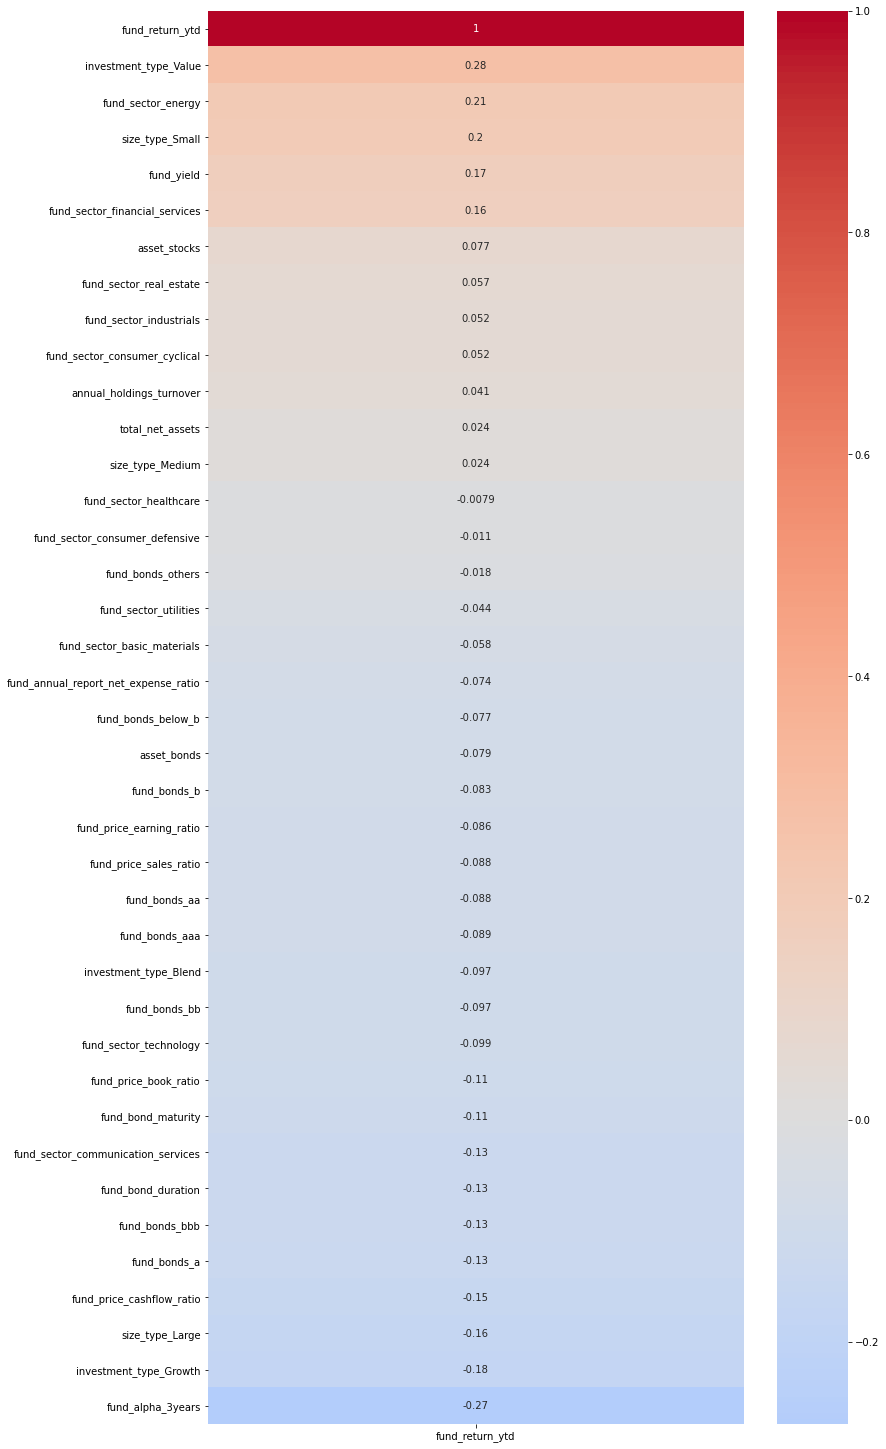

In [286]:
figure = plt.figure(figsize=(12,26))
sns.heatmap(etf.corr()[['fund_return_ytd']].sort_values('fund_return_ytd',ascending=False),annot=True, cmap='coolwarm', center=0);

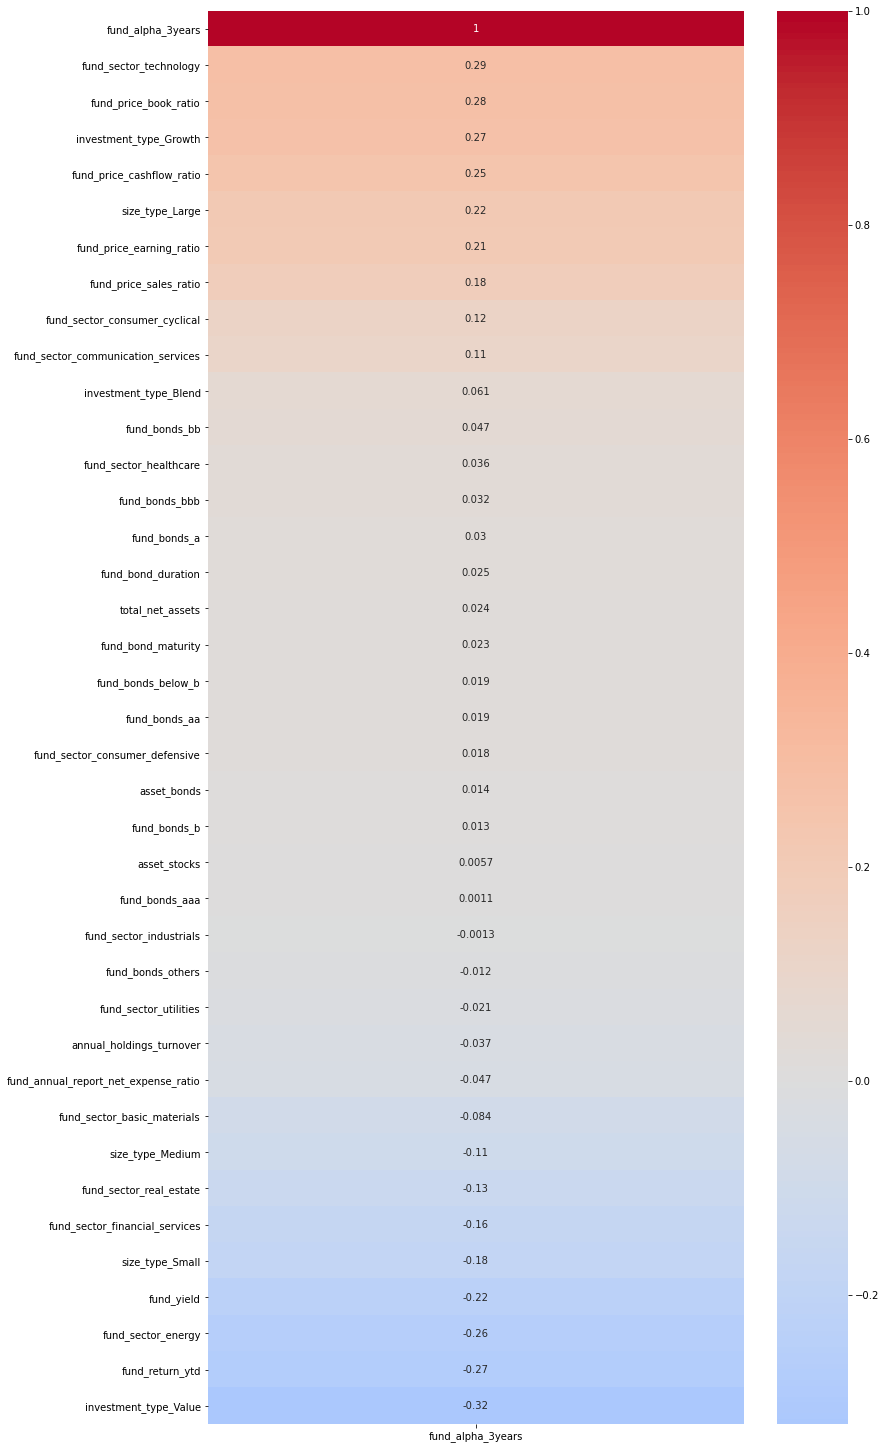

In [287]:
figure = plt.figure(figsize=(12,26))
sns.heatmap(etf.corr()[['fund_alpha_3years']].sort_values('fund_alpha_3years',ascending=False),annot=True, cmap='coolwarm', center=0);

In [288]:
etf_corr_matrix = etf.corr().abs()
sol = (etf_corr_matrix.where(np.triu(np.ones(etf_corr_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False))
sol.head(20)

fund_bonds_b               fund_bonds_below_b           0.946670
fund_bond_maturity         fund_bond_duration           0.927159
fund_bonds_a               fund_bonds_bbb               0.843237
fund_bonds_bb              fund_bonds_b                 0.762104
fund_price_book_ratio      fund_price_cashflow_ratio    0.759452
size_type_Large            size_type_Medium             0.740647
fund_bonds_bb              fund_bonds_below_b           0.711165
fund_price_cashflow_ratio  fund_price_earning_ratio     0.675263
fund_sector_technology     fund_price_book_ratio        0.637443
fund_bond_duration         fund_bonds_aaa               0.635019
fund_bond_maturity         fund_bonds_aaa               0.613049
investment_type_Blend      investment_type_Value        0.601911
fund_price_book_ratio      fund_price_sales_ratio       0.587070
fund_bonds_aa              fund_bonds_a                 0.580966
fund_price_book_ratio      fund_price_earning_ratio     0.580911
                         

In [289]:
# remove high collinearity features

etf.drop(['fund_bonds_b', 'fund_bond_duration', 'fund_price_book_ratio', 'fund_price_sales_ratio', 'fund_price_cashflow_ratio'], axis=1, inplace=True)


In [290]:
etf.corr()[['fund_return_ytd']].sort_values('fund_return_ytd',ascending=False)

fund_return_ytd
fund_return_ytd                              1.000000
investment_type_Value                        0.275002
fund_sector_energy                           0.213222
size_type_Small                              0.201902
fund_yield                                   0.167000
fund_sector_financial_services               0.162323
asset_stocks                                 0.076694
fund_sector_real_estate                      0.057152
fund_sector_industrials                      0.052392
fund_sector_consumer_cyclical                0.051642
annual_holdings_turnover                     0.041441
total_net_assets                             0.023921
size_type_Medium                             0.023829
fund_sector_healthcare                      -0.007901
fund_sector_consumer_defensive              -0.010820
fund_bonds_others                           -0.018122
fund_sector_utilities                       -0.043742
fund_sector_basic_materials                 -0.057786
fund_annual_report_net_expense_ratio        -0.074062
fund_bonds_below_b                          -0.076763
asset_bonds                                 -0.078952
fund_price_earning_ratio                    -0.085821
fund_bonds_aa                               -0.088026
fund_bonds_aaa                              -0.088854
investment_type_Blend                       -0.097171
fund_bonds_bb                               -0.097485
fund_sector_technology                      -0.098519
fund_bond_maturity                          -0.114094
fund_sector_communication_services          -0.126075
fund_bonds_bbb                              -0.129728
fund_bonds_a                                -0.134658
size_type_Large                             -0.159823
investment_type_Growth                      -0.178056
fund_alpha_3years                           -0.274204

In [291]:
# remove some of the 'others' columns

etf.drop(['fund_bonds_others'] , axis=1, inplace=True)

In [292]:
etf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 1 to 1302
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   total_net_assets                      973 non-null    float64
 1   fund_yield                            973 non-null    float64
 2   annual_holdings_turnover              973 non-null    float64
 3   fund_annual_report_net_expense_ratio  973 non-null    float64
 4   asset_stocks                          973 non-null    float64
 5   asset_bonds                           973 non-null    float64
 6   fund_sector_basic_materials           973 non-null    float64
 7   fund_sector_communication_services    973 non-null    float64
 8   fund_sector_consumer_cyclical         973 non-null    float64
 9   fund_sector_consumer_defensive        973 non-null    float64
 10  fund_sector_energy                    973 non-null    float64
 11  fund_sector_financ

After the initial cleaning, we had 1,303 entries and 113 columns. Now we have 973 rows and 33 columns - we are conscious that this dataset is significantly smaller due to the lack of quality data. It would be difficult for our machine learning models to train sufficiently and the results for this prediction model accuracy will be much lower. 

### Save into new csv

In [293]:
mutual_fund.to_csv('../datasets/mutual_fund_processed.csv', index=False)
etf.to_csv('../datasets/etf_processed.csv', index=False)